In [1]:
import os
import copy
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
%matplotlib inline
from transformers import AutoTokenizer, AutoModelWithLMHead, AutoModelForSeq2SeqLM, BartForConditionalGeneration,BartTokenizer
import shap
import scipy as sp
import nlp
import torch
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.set_option("max_rows", None)
from shap.utils import assert_import, record_import_error, safe_isinstance, make_masks, OpChain, MaskedModel
from shap import maskers, links
from transformers.file_utils import ModelOutput
#from shap.utils import cal_conditional_logits
import sys
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

In [2]:
def cuda_memory_stats():
    t = torch.cuda.get_device_properties(0).total_memory
    c = torch.cuda.memory_cached(0)
    a = torch.cuda.memory_allocated(0)
    f = c-a
    print(t)
    print(c)
    print(a)
    print(f)

In [3]:
cuda_memory_stats()

4294967296
0
0
0


In [4]:
tokenizer = BartTokenizer.from_pretrained("sshleifer/distilbart-xsum-12-6")
model =  BartForConditionalGeneration.from_pretrained("sshleifer/distilbart-xsum-12-6").cuda()

In [48]:
dataset = nlp.load_dataset('xsum',split='train')

Using custom data configuration default


In [51]:
dataset['document'][0]

'The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn\'t affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads. "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The PlayStation Network is used by millions of people around the world.It allows users to play their friends at games like Fifa over the internet and also do things like download software o

In [93]:
def get_encoder_outputs(input_ids,model,attention_mask):
    encoder = model.get_encoder()
    with torch.no_grad():
        encoder_outputs = encoder(input_ids, attention_mask=attention_mask, return_dict=True)
    del encoder
    return encoder_outputs

def get_conditional_logits(model, decoder_input, past, attention_mask, encoder_outputs):
    model_inputs = model.prepare_inputs_for_generation(
                    decoder_input, past=past, attention_mask=attention_mask, use_cache=True, encoder_outputs=encoder_outputs
                )
    with torch.no_grad():
        outputs = model(**model_inputs, return_dict=True)
    if "past_key_values" in outputs:
        past = outputs.past_key_values
    next_token_logits = outputs.logits[:, -1, :].detach().cpu()
    probs=next_token_logits[0].softmax(dim=0)
    del model_inputs, outputs
    probs = sp.special.logit(probs)
    return probs, past

def cal_conditional_logits(input_ids,model,tokenizer,decoder_inputs,encoder_outputs=None,attention_mask=None):
    conditional_logits=[]
    past=None
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    input_ids=input_ids.to(device)
    if attention_mask is None:
        attention_mask = (input_ids!=tokenizer.pad_token_id).type(torch.int64)
    else:
        attention_mask = attention_mask.to(device)
    summary_ids = model.generate(input_ids)
    summary=[tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    del summary_ids
    print(f"\033[1m Summary: \033[0m {summary[0]} \n")
    if encoder_outputs is None:
        encoder_outputs = get_encoder_outputs(input_ids,model,attention_mask)
    del input_ids
    for i in range(1,decoder_inputs.shape[1]):
        probs, past = get_conditional_logits(model, decoder_inputs[:,:i], past, attention_mask, encoder_outputs)
        conditional_logits.append(probs[decoder_inputs[0,i].item()])
    del past, attention_mask, encoder_outputs
    """
    token_ids=tokenizer.convert_ids_to_tokens(decoder_inputs[0,1:].detach().cpu().numpy())
    mlp.rcParams['figure.figsize']=(10,5)
    plt.bar(token_ids,conditional_logits)
    plt.xticks(rotation=90)
    plt.show()
    """
    return np.array(conditional_logits)

In [130]:
s_input=dataset['document'][159]
summ=gen_summary(s_input)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Keyword arguments {'min_length': 0} not recognized.


In [131]:
def get_teacher_forced_logits(input_ids,decoder_input_ids):
    with torch.no_grad():
        outputs = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids, labels=decoder_input_ids, return_dict=True)
    logits=outputs.logits.detach().cpu().numpy()
    del outputs
    return logits

def calculate_conditional_logits(model,input_ids,decoder_input_ids,attention_mask=None):
    conditional_logits = []
    logits=get_teacher_forced_logits(input_ids,decoder_input_ids)
    #print(logits)
    for i in range(1,logits.shape[1]):
        #probs=logits[0][i-1].softmax(dim=0)
        probs = (np.exp(logits[0][i-1]).T / np.exp(logits[0][i-1]).sum(-1)).T
        probs = sp.special.logit(probs)
        conditional_logits.append(probs[decoder_input_ids[0,i].item()])
    return np.array(conditional_logits)

In [132]:
calculate_conditional_logits(model,summ['input_ids'],summ['decoder_inputs'],attention_mask=None)

array([-1.18319, 2.51806, 1.35061, 0.43288, -0.55594, 0.29507, 2.78175,
       4.95327, 3.39317, 0.16912, 0.06265, 2.13338, -0.15092, 2.92442,
       3.19038, 0.35947], dtype=float32)

In [133]:
cal_conditional_logits(summ['input_ids'],model,tokenizer,summ['decoder_inputs'])

 Summary:   Thousands of people have gathered at Stonehenge to mark the summer solstice. 



array([-1.18319, 2.51805, 1.35063, 0.43289, -0.55593, 0.29507, 2.78249,
       4.95960, 3.39362, 0.16912, 0.06265, 2.13338, -0.15092, 2.92504,
       3.19038, 0.35947], dtype=float32)

In [60]:
def gen_summary(x):
    inputs = tokenizer([x], max_length=1024, return_tensors='pt',min_length=0)
    input_ids=inputs['input_ids'].cuda()
    with torch.no_grad():
        out=model.generate(input_ids)
    decoder_inputs=out[:,:-1]
    del out
    return {'decoder_inputs':decoder_inputs,'input_ids':input_ids}

In [7]:
def f_kwargs(x):
    kwargs = gen_summary(x)
    return kwargs

In [8]:
s="abcde"
s=s.replace("ab","\033[1m"+"ab"+"\033[0m")
print(s)

abcde


In [29]:
def f_cp(x_batch,**kwargs):
    output_batch=[]
    decoder_inputs=kwargs['decoder_inputs']
    sent_ids = kwargs['input_ids']
    for i,x in enumerate(x_batch):
        if 'text_highlight_mask' in kwargs:
            highlight_text = tokenizer.decode(sent_ids[0,1:-1][kwargs['text_highlight_mask'][i][1:-1]])
            masked_text = x
            masked_text = masked_text.replace(highlight_text,"\033[1m"+highlight_text+"\033[0m")
            print(f"\n \033[1m Masked input: \033[0m {masked_text}")
            print(f"\n \033[1mFixed_Context:0\033[0m")
            inputs = tokenizer([highlight_text], max_length=1024, return_tensors='pt',truncation=True)
            input_ids=inputs['input_ids']
            conditional_logits = cal_conditional_logits(input_ids,model,tokenizer,decoder_inputs)
        else:
            print(f"\n \033[1m Masked input: \033[0m {x}")
        print(f"\n \033[1mFixed_Context:1\033[0m")
        inputs = tokenizer([x], max_length=1024, return_tensors='pt',truncation=True)
        input_ids=inputs['input_ids']
        conditional_logits = cal_conditional_logits(input_ids,model,tokenizer,decoder_inputs)
        for x,y in zip(decoder_inputs[0,1:].cpu().numpy(),conditional_logits):
            print(f'{tokenizer.decode(int(x))}->{y:.5f}', end = ';')
        print('\n')
        output_batch.append(conditional_logits)
    return np.array(output_batch)

In [10]:
def f_cp_attn(x_batch,**kwargs):
    output_batch=[]
    decoder_inputs=kwargs['decoder_inputs']
    masks = kwargs['masks']
    input_ids = kwargs['input_ids']
    for i,(x,mask) in enumerate(zip(x_batch,masks)):
        #print(f"\033[1m Masked input: \033[0m {x}")
        #inputs = tokenizer([x], max_length=1024, return_tensors='pt',truncation=True)
        #input_ids=inputs['input_ids']
        attention_mask = torch.tensor(mask).unsqueeze(0)
        conditional_logits = cal_conditional_logits(input_ids,model,tokenizer,decoder_inputs,attention_mask=attention_mask)
        output_batch.append(conditional_logits)
    return np.array(output_batch)

In [30]:
explainer = shap.Explainer(f_cp,tokenizer,model_kwargs=f_kwargs)
explainer.masker.mask_token=None
explainer.masker.mask_token_str=""
explainer.masker.fixed_background = True

explainers.Partition is still in an alpha state, so use with caution...


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Keyword arguments {'min_length': 0} not recognized.



  Masked input:  

 Fixed_Context:1
 Summary:  Questions are still being asked on social media about the impact of the EU referendum. 



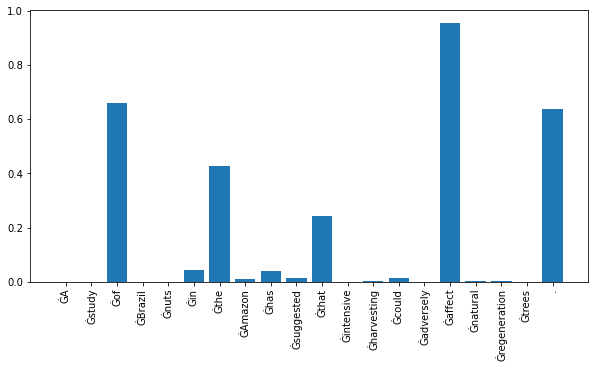

 A->0.00000; study->0.00028; of->0.04559; Brazil->0.00011; nuts->0.00000; in->0.04151; the->0.13203; Amazon->0.00823; has->0.03826; suggested->0.01375; that->0.24255; intensive->0.00002; harvesting->0.00113; could->0.01183; adversely->0.00045; affect->0.95657; the->0.26359; natural->0.00068; regeneration->0.00105; of->0.65923; the->0.42657; trees->0.00007;.->0.63917;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracke

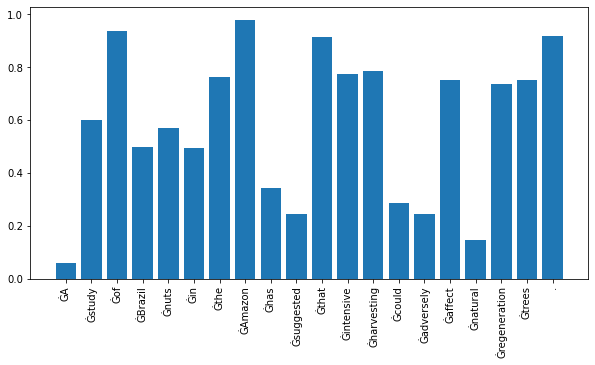

 A->0.05961; study->0.60105; of->0.45336; Brazil->0.49874; nuts->0.56860; in->0.49298; the->0.76387; Amazon->0.97918; has->0.34262; suggested->0.24560; that->0.91463; intensive->0.77559; harvesting->0.78669; could->0.28814; adversely->0.24552; affect->0.75259; the->0.74030; natural->0.14615; regeneration->0.73613; of->0.93553; the->0.76056; trees->0.75176;.->0.91678;

Index in batch: 1956

  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were d

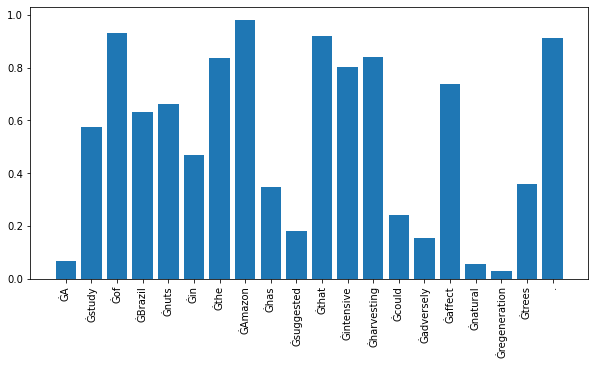


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has suggested that intensive harvesting could adversely affect the tree's survival. 



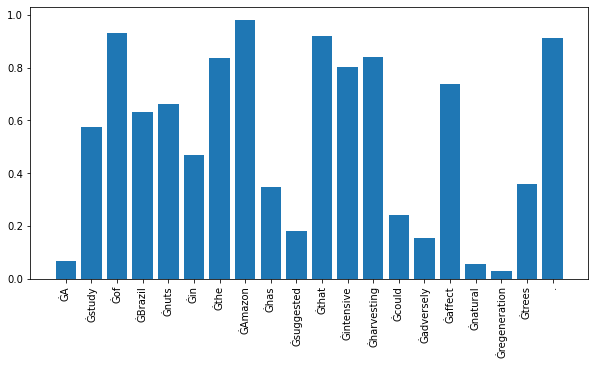

 A->0.06671; study->0.57410; of->0.38545; Brazil->0.63062; nuts->0.66323; in->0.46774; the->0.70149; Amazon->0.98176; has->0.34888; suggested->0.18038; that->0.91850; intensive->0.80171; harvesting->0.84178; could->0.24264; adversely->0.15342; affect->0.73925; the->0.73378; natural->0.05484; regeneration->0.02785; of->0.93194; the->0.83748; trees->0.36052;.->0.91339;


  Masked input:   trees and few or no juveniles.But, they observed: "Juveniles were most common in unharvested and lightly harvested stands."However, Dr Haugaasen said, the people harvesting the nuts could unknowingly be contributing to the regeneration of the trees, as some nuts were accidentally dropped as they were carried out of the forest."We actually found seedlings along the path used by the collectors. However, this does not mean that they are all going to reach maturity because they are in (vulnerable) places."But he warned that restricting nut collecting could prove to be counterproductive because the harvests 

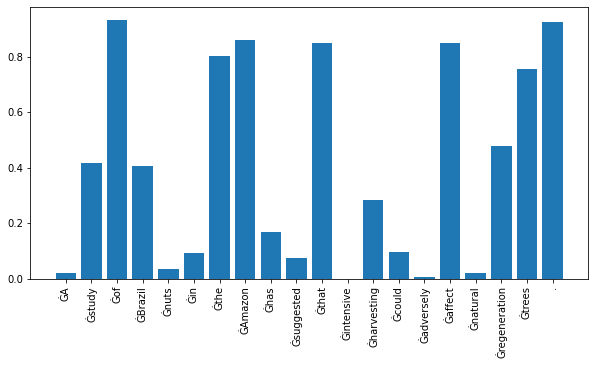


 Fixed_Context:1
 Summary:  Researchers at the University of Salford in Sweden have found that Brazil nut trees are vulnerable to the hunting of small rodents. 



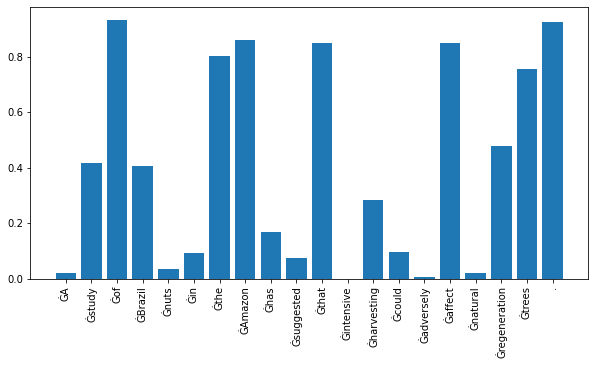

 A->0.02078; study->0.41826; of->0.28819; Brazil->0.40740; nuts->0.03593; in->0.09375; the->0.38326; Amazon->0.86084; has->0.16654; suggested->0.07546; that->0.84861; intensive->0.00011; harvesting->0.28445; could->0.09672; adversely->0.00654; affect->0.84781; the->0.74440; natural->0.02167; regeneration->0.47891; of->0.93230; the->0.80114; trees->0.75478;.->0.92291;



Interaction effect for index 1956: [0.02788 0.39102 0.17469 0.53917 0.13055 0.02699 0.18885 0.85518 0.13454
 -0.00351 0.60993 0.02621 0.33841 0.03939 -0.08602 -0.12210 0.47429
 -0.07031 -0.23041 0.26948 0.45148 0.36347 0.28034]
Index in batch: 1956

  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracked 1,800 marked seeds to see how seasonal food availability affected agoutis' and acouchis' - large scatter-hoarding rodent

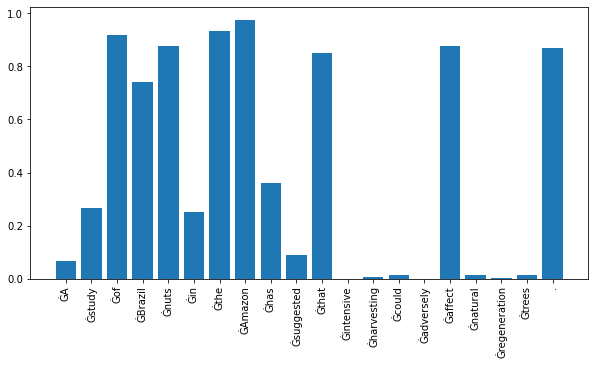


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has revealed that the amount of nuts that are eaten by small rodents affects the dispersal of the seeds. 



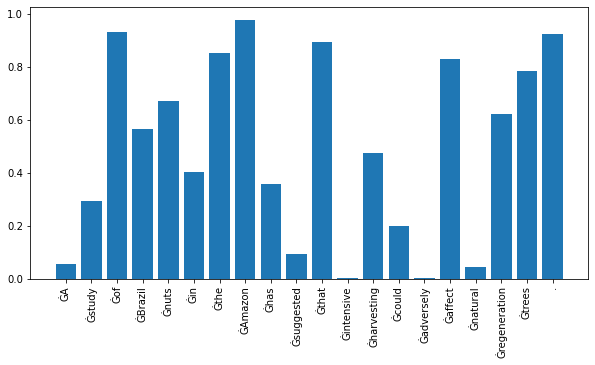

 A->0.05438; study->0.29265; of->0.50886; Brazil->0.56356; nuts->0.67202; in->0.40438; the->0.74843; Amazon->0.97711; has->0.35680; suggested->0.09491; that->0.89503; intensive->0.00072; harvesting->0.47509; could->0.19883; adversely->0.00174; affect->0.82914; the->0.66645; natural->0.04484; regeneration->0.62258; of->0.93108; the->0.85329; trees->0.78327;.->0.92207;


  Masked input:   - when there are a lot of other fruits in the forest - more seeds were cached for later retrieval," he added."In the dry season (September), on the other hand, more seeds were eaten immediately because there was not that much food around and the rodents needed to draw on the food resource."Seeds were also taken further away during the dry season, which suggests that the rodents saw them as a more valuable resource than during the wet season," Dr Haugaasen told BBC News.The field study, carried out during 2006, showed that 74.4% of seeds were buried during the wet season, compared with just 38.2% during 

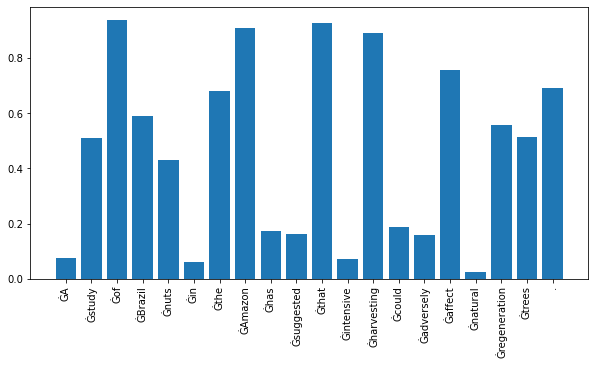


 Fixed_Context:1
 Summary:  Researchers at the University of Salford in Sweden have found that Brazil nut trees are more likely to be eaten by large rodents than in the wet season. 



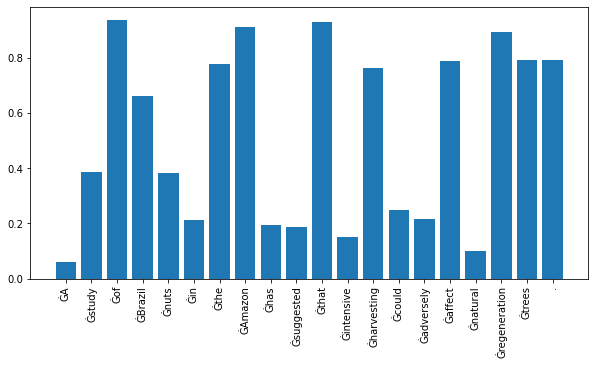

 A->0.06074; study->0.38676; of->0.15035; Brazil->0.66236; nuts->0.38325; in->0.21404; the->0.39709; Amazon->0.91165; has->0.19486; suggested->0.18562; that->0.93118; intensive->0.15084; harvesting->0.76304; could->0.25055; adversely->0.21551; affect->0.78972; the->0.77745; natural->0.09930; regeneration->0.89475; of->0.93829; the->0.76632; trees->0.79122;.->0.79400;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracke

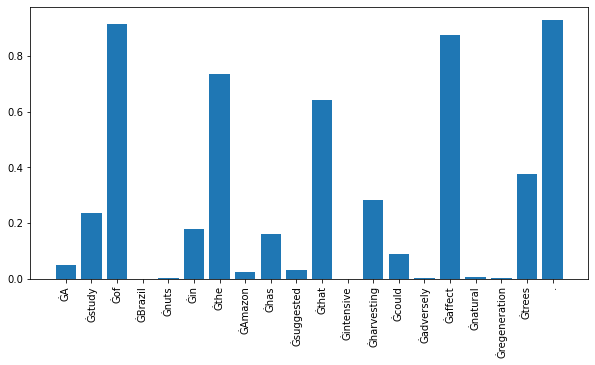


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has suggested that intensive harvesting could adversely affect the tree's survival. 



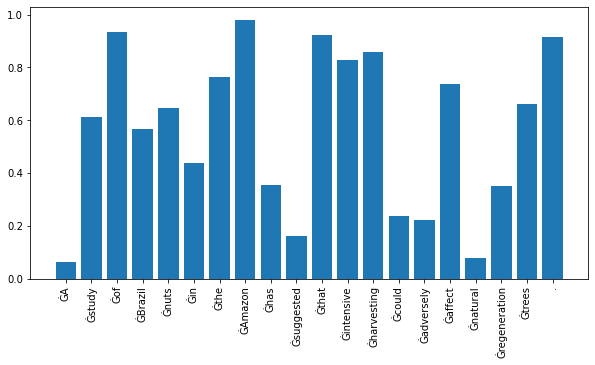

 A->0.06143; study->0.61169; of->0.39556; Brazil->0.56517; nuts->0.64515; in->0.43809; the->0.73486; Amazon->0.98047; has->0.35474; suggested->0.15998; that->0.92289; intensive->0.82948; harvesting->0.85722; could->0.23884; adversely->0.22086; affect->0.73569; the->0.75095; natural->0.07835; regeneration->0.35001; of->0.93290; the->0.76463; trees->0.66072;.->0.91698;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracke

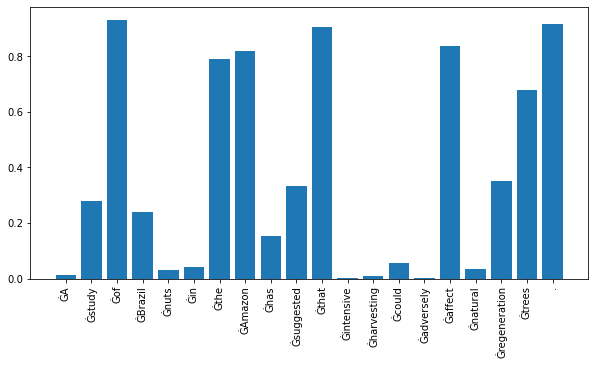


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has suggested that intensive harvesting could adversely affect the tree's natural regeneration. 



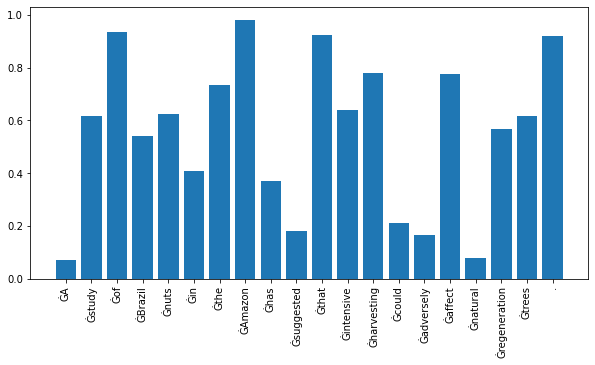

 A->0.07131; study->0.61500; of->0.42029; Brazil->0.54289; nuts->0.62604; in->0.40884; the->0.73346; Amazon->0.98159; has->0.37221; suggested->0.17890; that->0.92545; intensive->0.64006; harvesting->0.78170; could->0.21270; adversely->0.16516; affect->0.77656; the->0.73366; natural->0.07664; regeneration->0.56668; of->0.93521; the->0.70385; trees->0.61551;.->0.91848;

Interaction effect for index 1955: [0.03473 -0.33990 -0.08234 0.31978 0.45073 0.03168 -0.00160 0.04874
 0.04249 -0.04052 0.06296 -0.62414 0.16700 0.06452 -0.03481 0.01846
 -0.04081 -0.02368 0.30229 0.00155 0.05791 0.06796 -0.12363]
Interaction effect for index 1953: [0.00642 0.05154 -0.02296 -0.02130 0.03936 -0.11380 0.00296 0.00112
 0.03545 -0.08711 0.01521 -0.10776 0.01045 -0.07924 -0.01292 0.02041
 0.01054 -0.04600 0.15271 0.00064 -0.12957 0.16395 0.00529]
Index in batch: 1953

  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies w

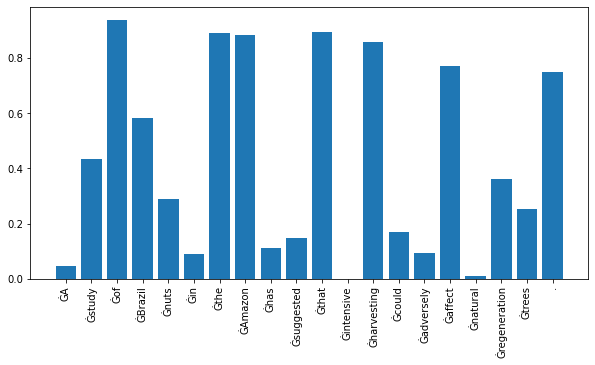


 Fixed_Context:1
 Summary:   A study of Brazil nut trees in the Amazon has revealed that the amount of nuts that are eaten by rodents affects the dispersal of the seeds. 



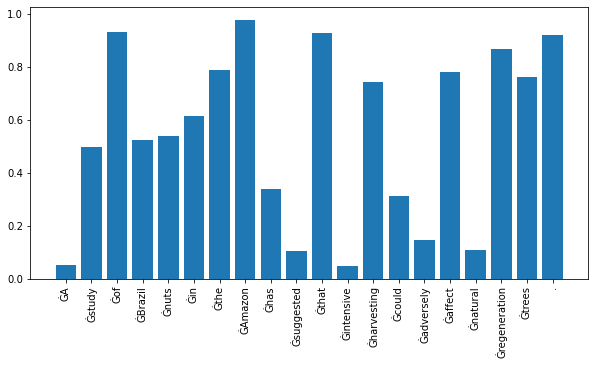

 A->0.05237; study->0.49768; of->0.58269; Brazil->0.52591; nuts->0.53824; in->0.61343; the->0.71686; Amazon->0.97838; has->0.33822; suggested->0.10442; that->0.92907; intensive->0.04766; harvesting->0.74150; could->0.31276; adversely->0.14715; affect->0.78226; the->0.72325; natural->0.10859; regeneration->0.86919; of->0.93344; the->0.78957; trees->0.76357;.->0.92034;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracke

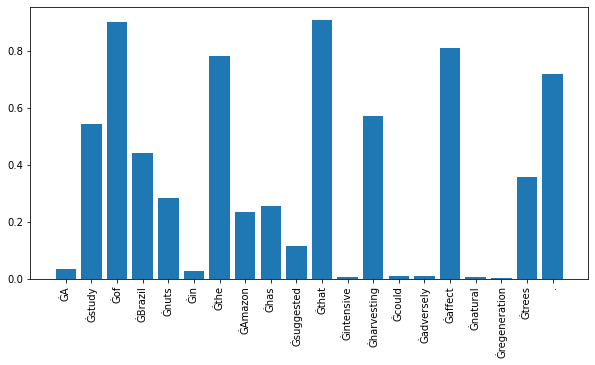


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has revealed that the seeds can survive for at least six years, even if they are eaten. 



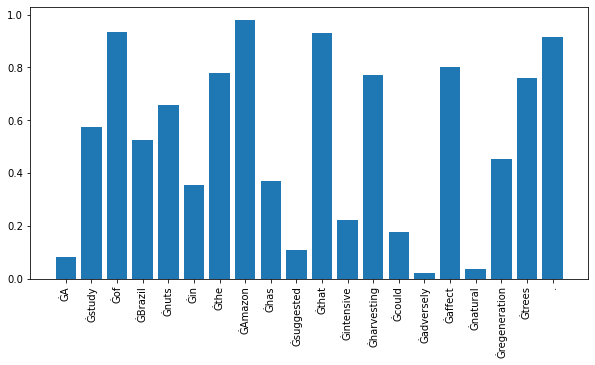

 A->0.08300; study->0.57515; of->0.35713; Brazil->0.52698; nuts->0.65925; in->0.35307; the->0.72101; Amazon->0.98021; has->0.36978; suggested->0.10799; that->0.93101; intensive->0.22077; harvesting->0.77292; could->0.17701; adversely->0.02218; affect->0.80053; the->0.67461; natural->0.03651; regeneration->0.45241; of->0.93254; the->0.77829; trees->0.75998;.->0.91561;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia. - when there are a lot of other fruits in the forest - more seeds were cached for 

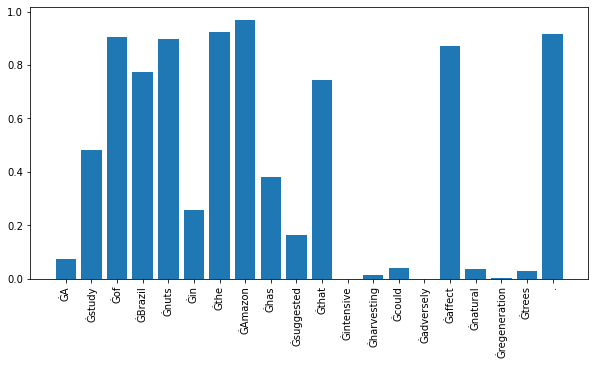


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has suggested that intensive harvesting could adversely affect the regeneration of the trees. 



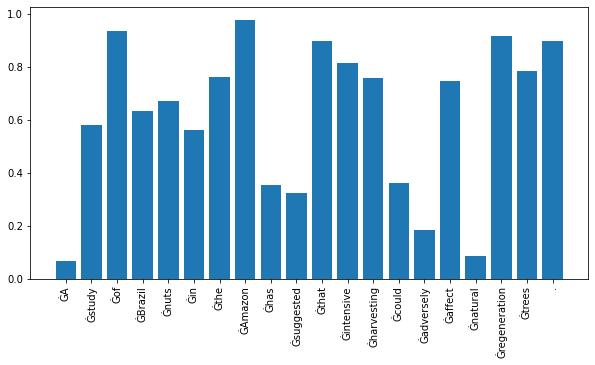

 A->0.06561; study->0.57981; of->0.58462; Brazil->0.63483; nuts->0.66961; in->0.56068; the->0.72489; Amazon->0.97732; has->0.35296; suggested->0.32245; that->0.89598; intensive->0.81298; harvesting->0.75587; could->0.36166; adversely->0.18450; affect->0.74596; the->0.76238; natural->0.08662; regeneration->0.91523; of->0.93573; the->0.74788; trees->0.78455;.->0.89678;


  Masked input:  In order to get a better understanding of how the seeds were dispersed, they tracked 1,800 marked seeds to see how seasonal food availability affected agoutis' and acouchis' - large scatter-hoarding rodents - caching rates, dispersal distances and how long the seeds were buried before being eaten."We basically found that the seasons had a very strong effect on the dispersal distances and what happened to the seeds themselves," explained Torbjorn Haugaasen, an ecologist at the Norwegian University of Life Sciences."During the wet season (April) - when there are a lot of other fruits in the forest - more s

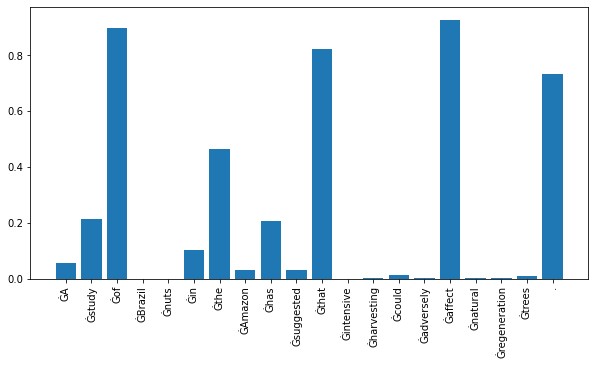


 Fixed_Context:1
 Summary:  Researchers in Norway have discovered that large rodents are responsible for the dispersal of Brazil nut tree seeds. 



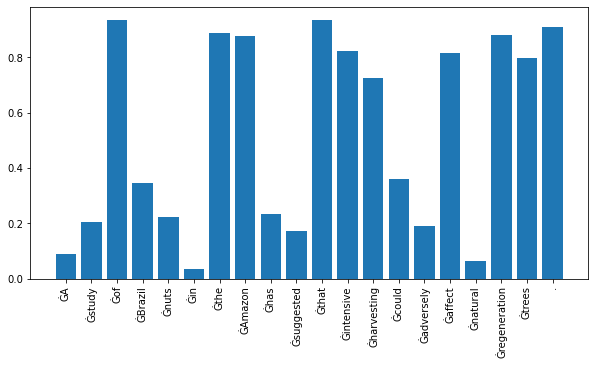

 A->0.08799; study->0.20354; of->0.19801; Brazil->0.34628; nuts->0.22333; in->0.03502; the->0.56894; Amazon->0.87735; has->0.23435; suggested->0.17068; that->0.93502; intensive->0.82096; harvesting->0.72585; could->0.35949; adversely->0.19022; affect->0.81381; the->0.81622; natural->0.06396; regeneration->0.87995; of->0.93439; the->0.88583; trees->0.79574;.->0.91028;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracke

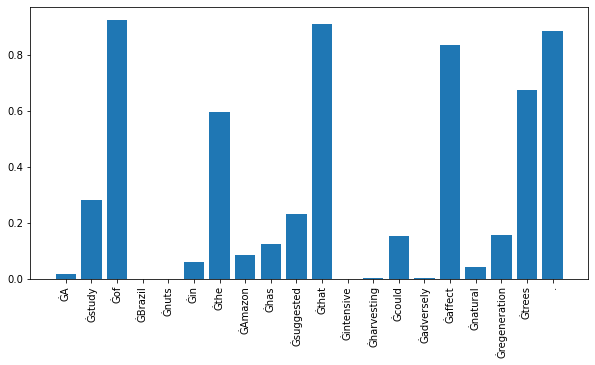


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has suggested that intensive harvesting could adversely affect the tree's natural regeneration. 



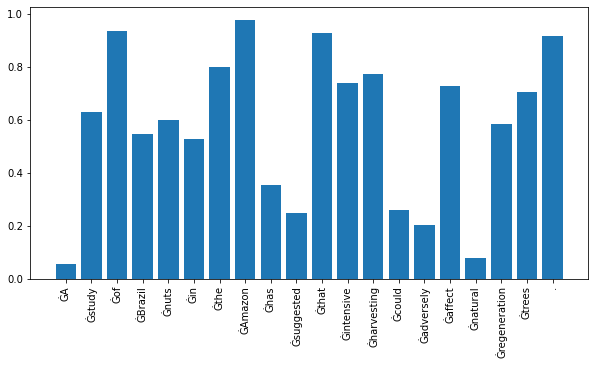

 A->0.05653; study->0.62954; of->0.45359; Brazil->0.54745; nuts->0.59938; in->0.52703; the->0.76070; Amazon->0.97863; has->0.35345; suggested->0.24800; that->0.92788; intensive->0.73951; harvesting->0.77372; could->0.25792; adversely->0.20108; affect->0.72960; the->0.73701; natural->0.07985; regeneration->0.58437; of->0.93489; the->0.80092; trees->0.70433;.->0.91825;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracke

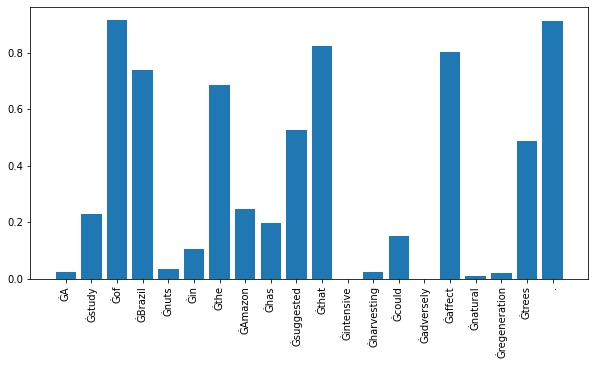


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has suggested that intensive harvesting could adversely affect the natural regeneration of the trees. 



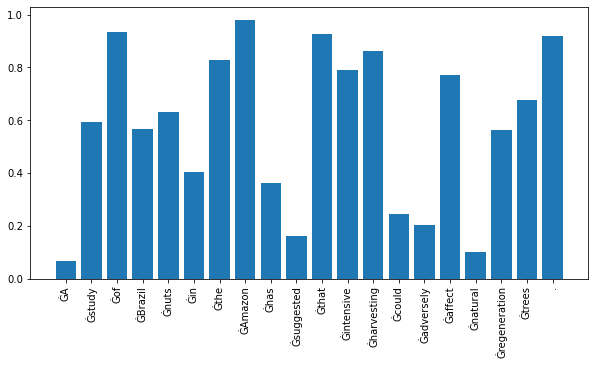

 A->0.06538; study->0.59505; of->0.44762; Brazil->0.56835; nuts->0.62956; in->0.40357; the->0.75372; Amazon->0.98057; has->0.36161; suggested->0.16347; that->0.92790; intensive->0.78937; harvesting->0.86133; could->0.24687; adversely->0.20385; affect->0.77091; the->0.75911; natural->0.10279; regeneration->0.56437; of->0.93428; the->0.82813; trees->0.67774;.->0.91929;

Interaction effect for index 1954: [0.02138 0.17913 -0.02239 -0.00940 -0.04312 0.06914 -0.07444 0.00230
 0.00858 -0.12810 0.05042 -0.50788 0.25264 0.00280 -0.07793 0.00105
 -0.00890 -0.04589 -0.03711 -0.00063 -0.04599 -0.01148 -0.00291]
Interaction effect for index 1950: [0.03325 -0.20446 0.17892 -0.17999 -0.05891 -0.11132 0.13287 -0.03615
 0.04983 0.06192 -0.01482 0.70751 -0.06801 0.18247 -0.08631 0.01745
 0.06085 -0.09487 0.16431 -0.00370 0.10683 0.03732 0.09628]
Interaction effect for index 1949: [0.00087 0.01185 0.05230 0.05188 0.01520 -0.00048 0.01569 -0.00045 0.01770
 0.00589 0.01826 -0.07618 -0.00885 -0.02218 -0.06

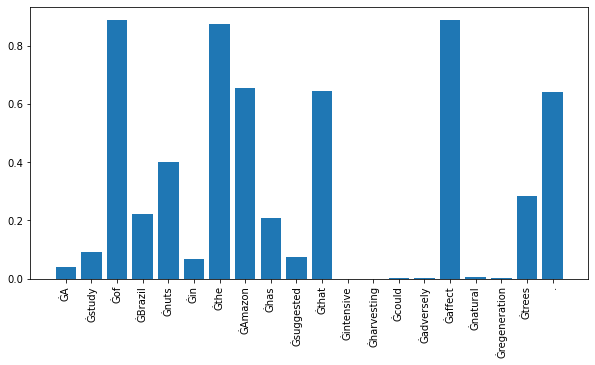


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has revealed that the amount of nuts that are eaten by large rodents affects the dispersal of the tree's seeds. 



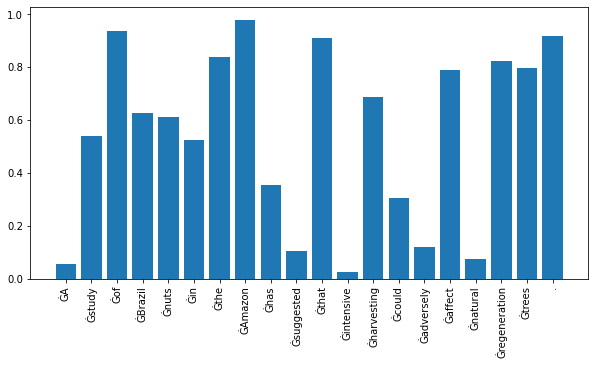

 A->0.05544; study->0.53833; of->0.54417; Brazil->0.62524; nuts->0.61065; in->0.52360; the->0.70127; Amazon->0.97881; has->0.35475; suggested->0.10300; that->0.90966; intensive->0.02470; harvesting->0.68826; could->0.30342; adversely->0.12029; affect->0.79084; the->0.70702; natural->0.07578; regeneration->0.82166; of->0.93528; the->0.83891; trees->0.79799;.->0.91802;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracke

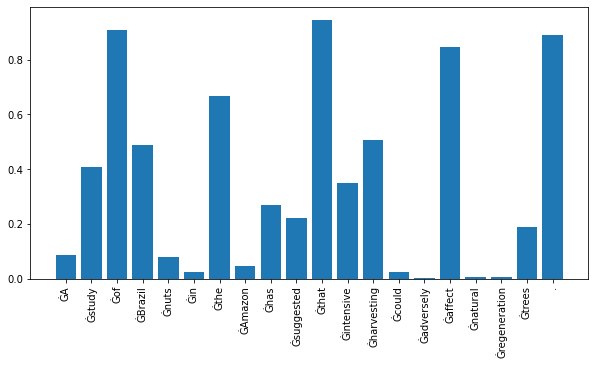


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has revealed that the amount of nuts that are eaten by rodents affects the dispersal of the seeds. 



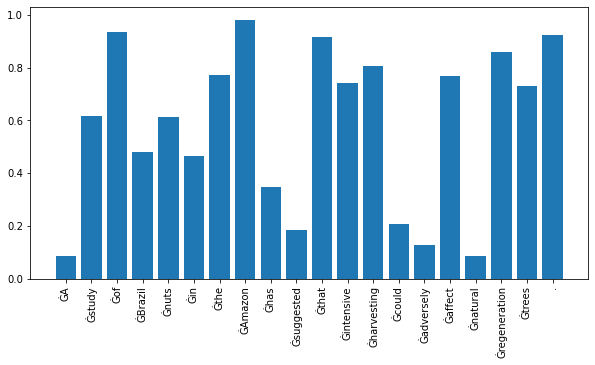

 A->0.08784; study->0.61716; of->0.48014; Brazil->0.48004; nuts->0.61098; in->0.46674; the->0.74394; Amazon->0.98124; has->0.34659; suggested->0.18326; that->0.91581; intensive->0.74272; harvesting->0.80767; could->0.20881; adversely->0.12829; affect->0.76771; the->0.74563; natural->0.08735; regeneration->0.86068; of->0.93338; the->0.77357; trees->0.73057;.->0.92265;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracke

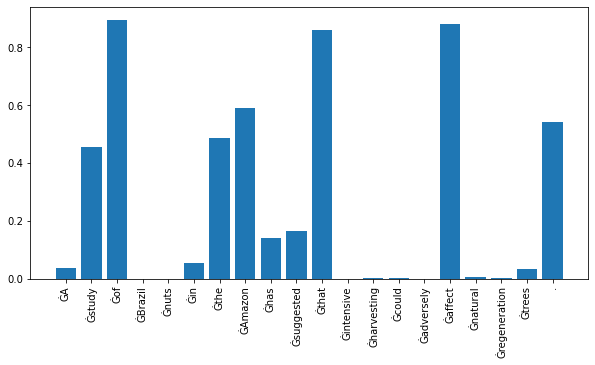


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has revealed that the amount of nuts that are eaten by large rodents affects the dispersal of the seeds. 



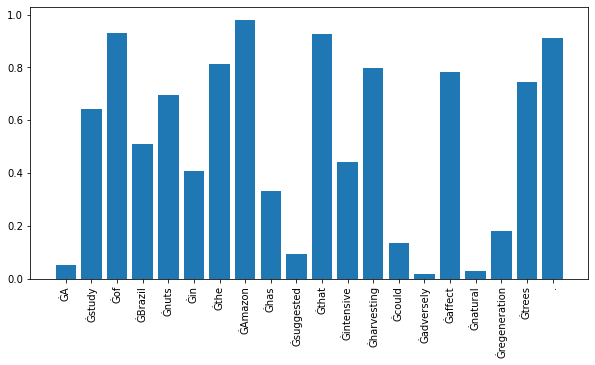

 A->0.05154; study->0.64336; of->0.35244; Brazil->0.51085; nuts->0.69473; in->0.40820; the->0.72548; Amazon->0.97989; has->0.33363; suggested->0.09486; that->0.92596; intensive->0.44114; harvesting->0.79845; could->0.13643; adversely->0.01864; affect->0.78366; the->0.70802; natural->0.02940; regeneration->0.18225; of->0.92890; the->0.81378; trees->0.74529;.->0.90937;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracke

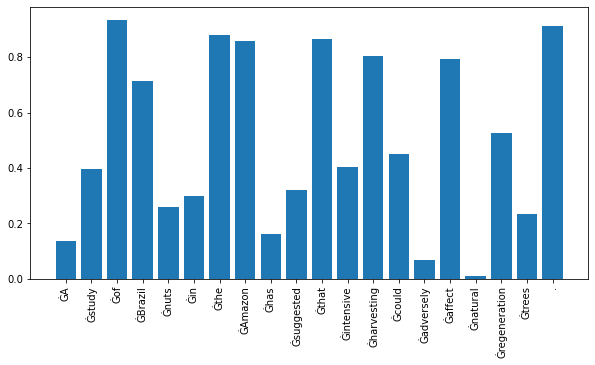


 Fixed_Context:1
 Summary:   A study of Brazil nuts has suggested that intensive harvesting could adversely affect the regeneration of the trees. 



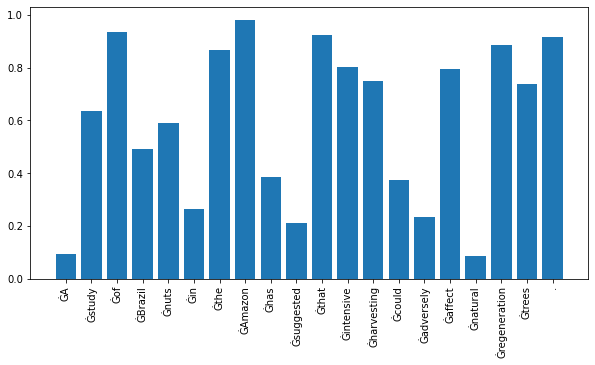

 A->0.09377; study->0.63430; of->0.35997; Brazil->0.49020; nuts->0.59065; in->0.26535; the->0.66339; Amazon->0.98171; has->0.38530; suggested->0.20958; that->0.92313; intensive->0.80272; harvesting->0.74828; could->0.37556; adversely->0.23343; affect->0.79371; the->0.78600; natural->0.08637; regeneration->0.88510; of->0.93409; the->0.86635; trees->0.73745;.->0.91742;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.In order to get a better understanding of how the seeds were dispersed, they tracked 1,800 marked seeds to see how seasonal food availability affected agoutis' and acouchis' - large scatter-hoarding rodents - caching rates, dispersal distances and how long the seeds were buried before being eaten."We basically found that the seasons had a very strong effect on the 

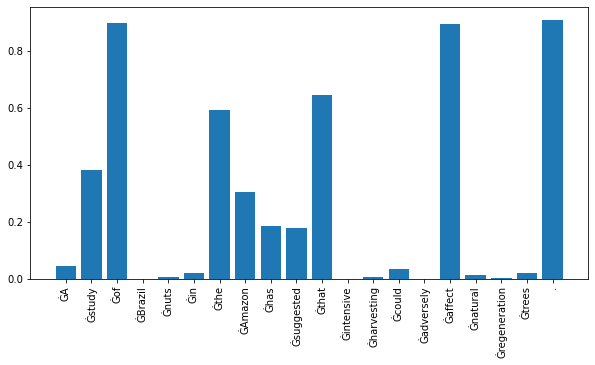


 Fixed_Context:1
 Summary:   A study of Brazil nut tree seeds has suggested that intensive harvesting could adversely affect the regeneration of the trees. 



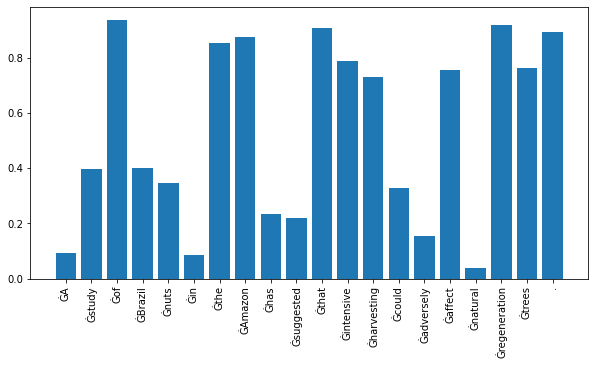

 A->0.09133; study->0.39855; of->0.37812; Brazil->0.40098; nuts->0.34548; in->0.08707; the->0.55489; Amazon->0.87582; has->0.23490; suggested->0.21908; that->0.90541; intensive->0.78650; harvesting->0.72891; could->0.32682; adversely->0.15347; affect->0.75339; the->0.77416; natural->0.03928; regeneration->0.91851; of->0.93658; the->0.85266; trees->0.76338;.->0.89098;


  Masked input:  The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracked 1,800 marked seeds to see how seasonal food availability affected agoutis' and acouchis' - large scatter-hoarding rodents - caching rates, dispersal distances and how long the seeds were buried before being eaten."We basically found that the 

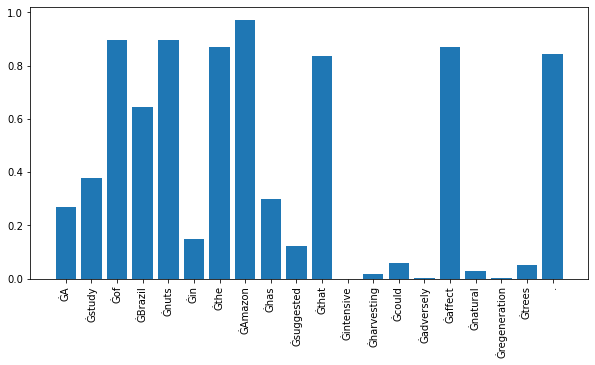


 Fixed_Context:1
 Summary:  Researchers have discovered that intensive harvesting of Brazil nuts in the Amazon can have a negative impact on the natural regeneration of the trees. 



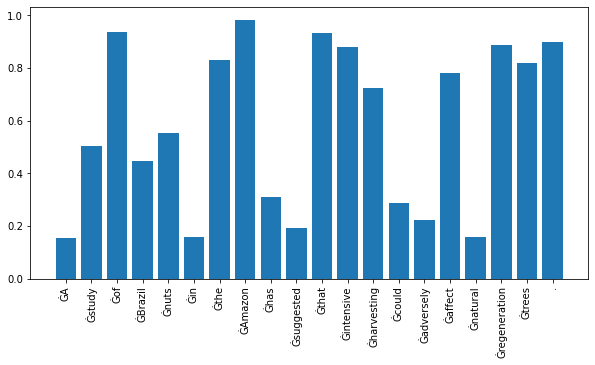

 A->0.15553; study->0.50344; of->0.38308; Brazil->0.44745; nuts->0.55445; in->0.15904; the->0.58329; Amazon->0.98299; has->0.31030; suggested->0.19308; that->0.93208; intensive->0.88018; harvesting->0.72553; could->0.28630; adversely->0.22381; affect->0.78173; the->0.82754; natural->0.15870; regeneration->0.88818; of->0.93543; the->0.82922; trees->0.81730;.->0.89927;

Interaction effect for index 1952: [0.03131 0.05675 -0.01175 0.08063 0.11479 -0.11608 -0.03552 0.00248
 0.02050 -0.06376 -0.01823 -0.05582 -0.03225 -0.08867 -0.14409 0.02371
 -0.01089 -0.09161 0.07702 -0.00031 0.06235 0.01324 0.00354]
Interaction effect for index 1951: [0.00270 0.10145 -0.09808 -0.02467 0.05753 -0.17250 -0.09601 0.00221
 0.00652 -0.04915 0.00344 0.24750 -0.01288 0.04685 -0.01564 0.02425
 0.07911 -0.06688 -0.12119 -0.00507 0.14127 -0.02900 -0.00559]
Interaction effect for index 1942: [0.09927 0.09740 0.10983 0.00341 0.10801 -0.28189 -0.19464 0.00228
 -0.03177 -0.00412 -0.01217 0.07013 -0.05810 -0.03451 -0.

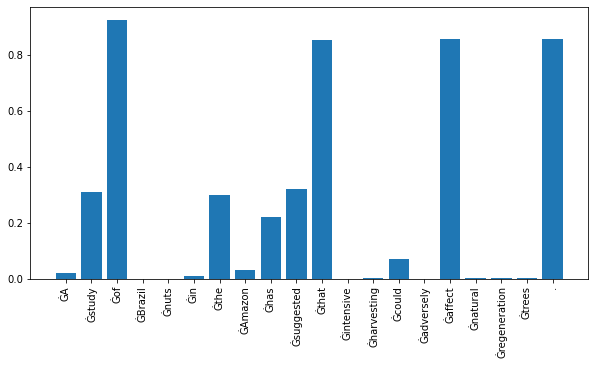


 Fixed_Context:1
 Summary:   The availability of food and the dispersal of Brazil nuts can have a significant impact on their survival, a study has found. 



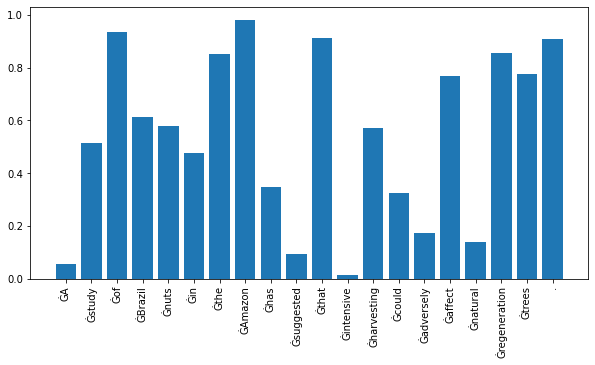

 A->0.05427; study->0.51495; of->0.47428; Brazil->0.61374; nuts->0.57724; in->0.47662; the->0.67826; Amazon->0.98155; has->0.34813; suggested->0.09253; that->0.91415; intensive->0.01269; harvesting->0.57022; could->0.32516; adversely->0.17256; affect->0.76796; the->0.78116; natural->0.14075; regeneration->0.85754; of->0.93663; the->0.85149; trees->0.77577;.->0.90975;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracke

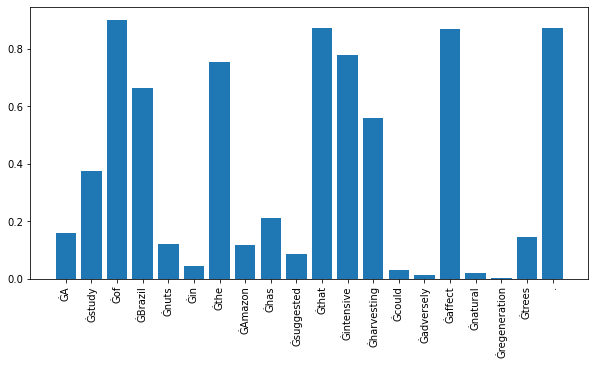


 Fixed_Context:1
 Summary:  Researchers say intensive harvesting of Brazil nuts in the Amazon could adversely affect the regeneration of the trees. 



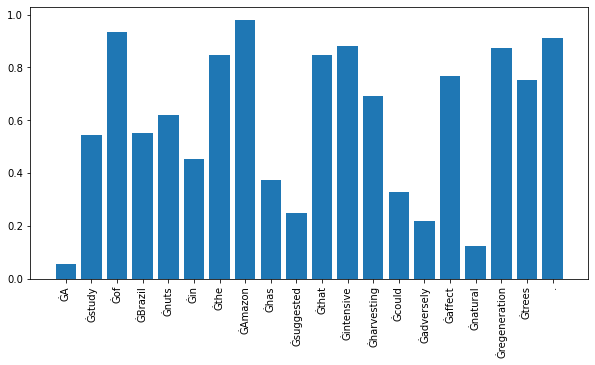

 A->0.05472; study->0.54443; of->0.46739; Brazil->0.55270; nuts->0.61802; in->0.45249; the->0.72665; Amazon->0.98033; has->0.37221; suggested->0.24763; that->0.84657; intensive->0.88280; harvesting->0.69136; could->0.32800; adversely->0.21806; affect->0.76702; the->0.77394; natural->0.12201; regeneration->0.87403; of->0.93546; the->0.84718; trees->0.75286;.->0.91231;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracke

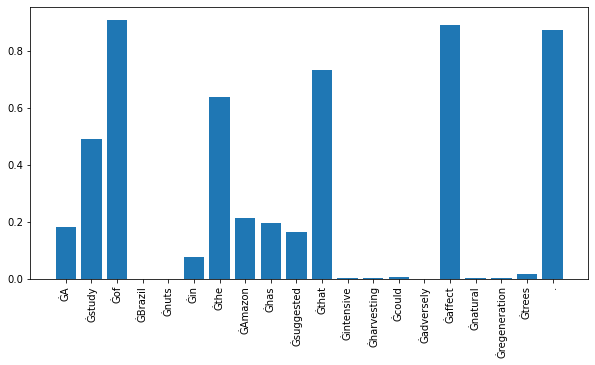


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has revealed that the amount of nuts that are eaten by large rodents affects the survival of the trees. 



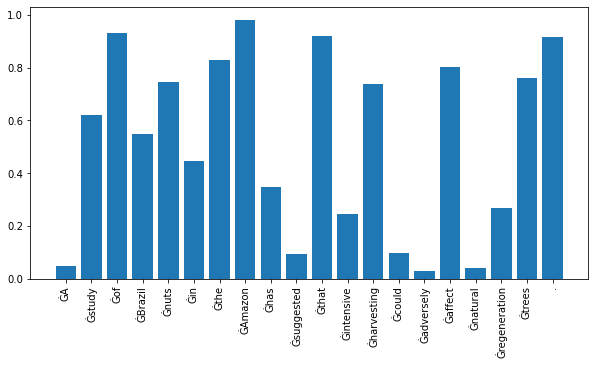

 A->0.04983; study->0.62204; of->0.37381; Brazil->0.54746; nuts->0.74668; in->0.44492; the->0.69855; Amazon->0.98176; has->0.34712; suggested->0.09258; that->0.92217; intensive->0.24367; harvesting->0.73657; could->0.09889; adversely->0.02796; affect->0.80196; the->0.72361; natural->0.03882; regeneration->0.26921; of->0.93127; the->0.82824; trees->0.76126;.->0.91667;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracke

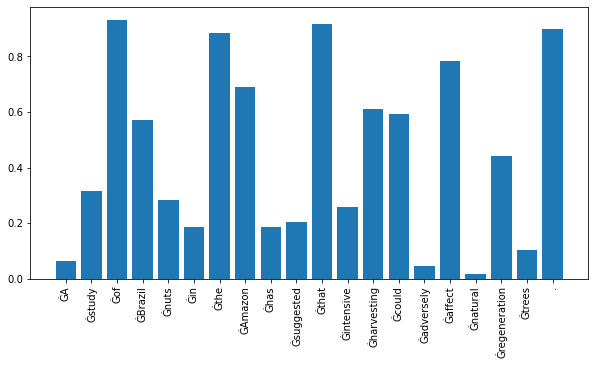


 Fixed_Context:1
 Summary:   The dispersal of Brazil nut tree seeds is influenced by seasonal food availability, a study has found. 



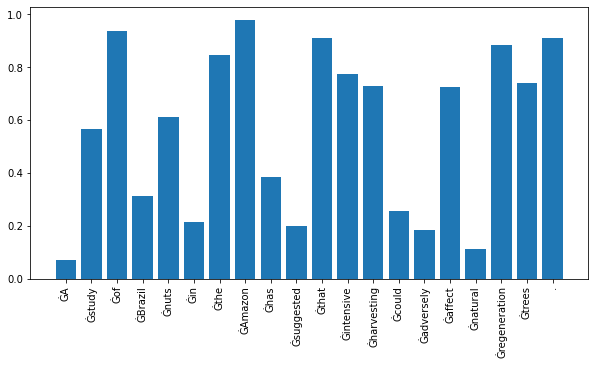

 A->0.06910; study->0.56697; of->0.30508; Brazil->0.31142; nuts->0.61329; in->0.21412; the->0.74377; Amazon->0.97920; has->0.38336; suggested->0.19780; that->0.90881; intensive->0.77472; harvesting->0.72984; could->0.25585; adversely->0.18564; affect->0.72671; the->0.78787; natural->0.11357; regeneration->0.88582; of->0.93610; the->0.84774; trees->0.73965;.->0.90970;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition,In order to get a better understanding of how the seeds were dispersed, they tracked 1,800 marked seeds to see how seasonal food availability affected agoutis' and acouchis' - large

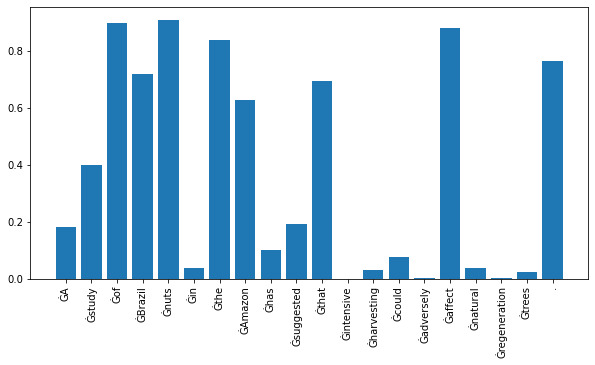


 Fixed_Context:1
 Summary:   A study of Brazil nuts has suggested that intensive harvesting could adversely affect the natural regeneration of the trees. 



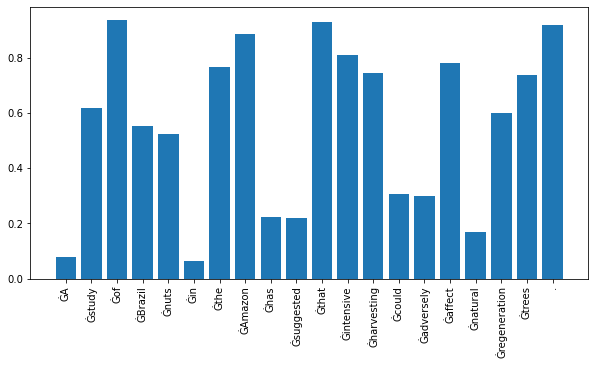

 A->0.07782; study->0.61830; of->0.39074; Brazil->0.55356; nuts->0.52204; in->0.06372; the->0.63235; Amazon->0.88354; has->0.22180; suggested->0.22004; that->0.92965; intensive->0.80996; harvesting->0.74574; could->0.30671; adversely->0.30008; affect->0.78102; the->0.76307; natural->0.16785; regeneration->0.59861; of->0.93631; the->0.76738; trees->0.73607;.->0.91648;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added. despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracked 1,800 marked seeds to see how seasonal food availability affected agoutis' and acouchis' - large scatter-hoarding rodents - caching rates, dispersal distances and how long the seeds we

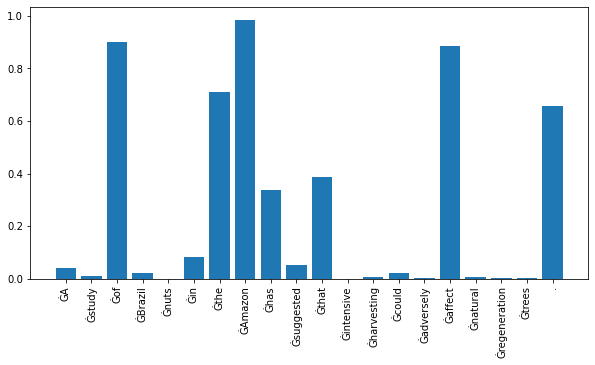


 Fixed_Context:1
 Summary:   A study of Brazil nut tree seeds has suggested that intensive harvesting could adversely affect the regeneration of the trees. 



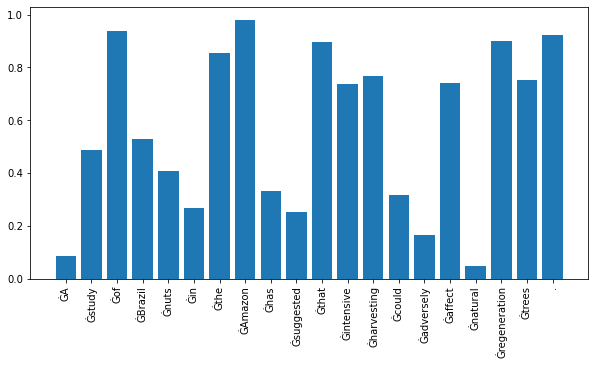

 A->0.08502; study->0.48754; of->0.42337; Brazil->0.52834; nuts->0.40879; in->0.26894; the->0.62990; Amazon->0.98009; has->0.33027; suggested->0.25260; that->0.89737; intensive->0.73690; harvesting->0.76591; could->0.31846; adversely->0.16417; affect->0.74084; the->0.82078; natural->0.04779; regeneration->0.89861; of->0.93667; the->0.85627; trees->0.75253;.->0.92078;

Interaction effect for index 1946: [-0.00606 -0.08000 -0.05585 0.04246 0.01601 -0.08748 -0.06024 0.00389
 0.02297 -0.00844 -0.06356 0.09520 -0.21337 0.06161 0.02482 -0.00846
 0.10778 0.04083 0.17378 0.00129 0.09919 -0.02112 -0.01275]
Interaction effect for index 1947: [0.00777 -0.05540 -0.12691 -0.15072 0.09664 -0.24215 -0.04703 0.00188
 0.05423 -0.05008 -0.00962 -0.19834 -0.11872 -0.06983 -0.05056 -0.00757
 0.06316 -0.02316 0.23665 0.00293 0.10163 0.00386 0.00021]
Interaction effect for index 1932: [0.01190 0.10623 -0.01737 0.18218 0.01674 -0.24739 -0.05650 0.00863
 -0.02545 0.00795 0.00698 -0.01522 -0.00395 0.01021 0.06

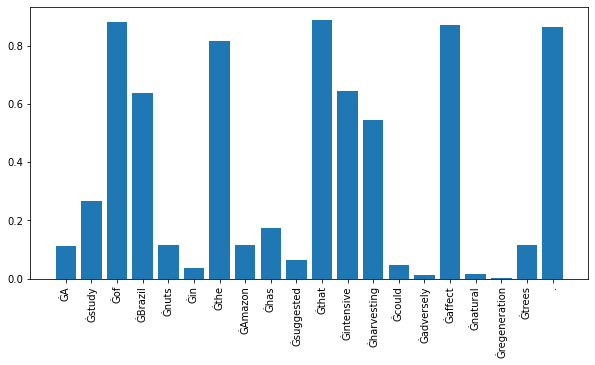


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has suggested that intensive harvesting could adversely affect the regeneration of the trees. 



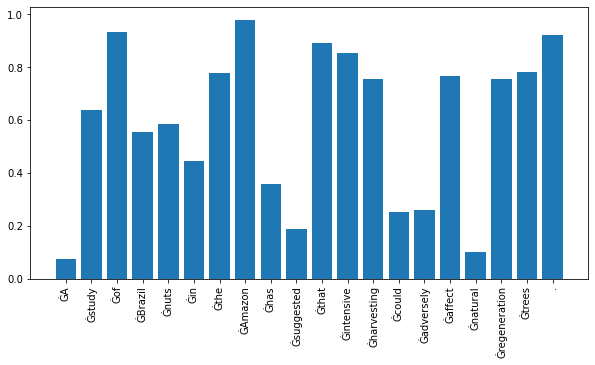

 A->0.07311; study->0.63673; of->0.41210; Brazil->0.55498; nuts->0.58347; in->0.44494; the->0.72614; Amazon->0.97949; has->0.35693; suggested->0.18777; that->0.89020; intensive->0.85250; harvesting->0.75650; could->0.25307; adversely->0.25868; affect->0.76681; the->0.77188; natural->0.10263; regeneration->0.75462; of->0.93396; the->0.77655; trees->0.78230;.->0.92034;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracke

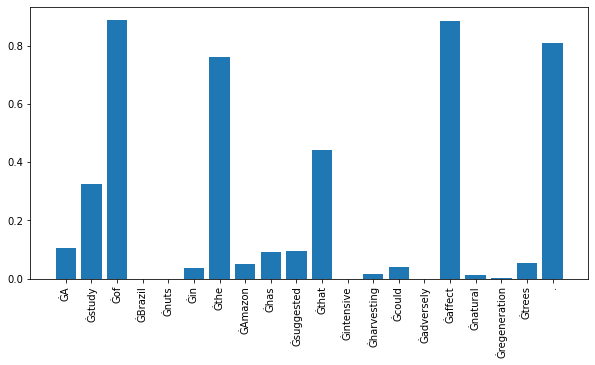


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has revealed that the amount of nuts that are eaten by large rodents affects the dispersal of the seeds. 



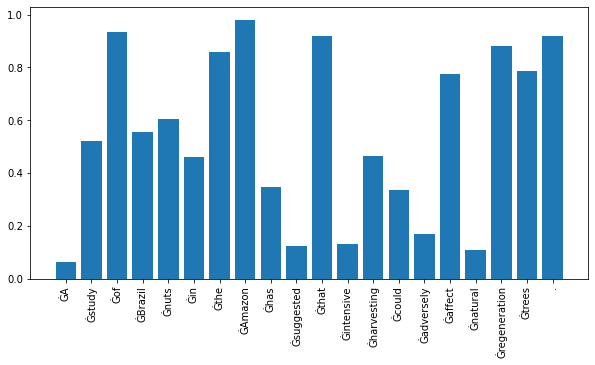

 A->0.06138; study->0.52125; of->0.48810; Brazil->0.55705; nuts->0.60363; in->0.46180; the->0.73410; Amazon->0.98013; has->0.34782; suggested->0.12418; that->0.91840; intensive->0.13279; harvesting->0.46291; could->0.33440; adversely->0.16737; affect->0.77444; the->0.75874; natural->0.10740; regeneration->0.88186; of->0.93520; the->0.85735; trees->0.78486;.->0.91768;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracke

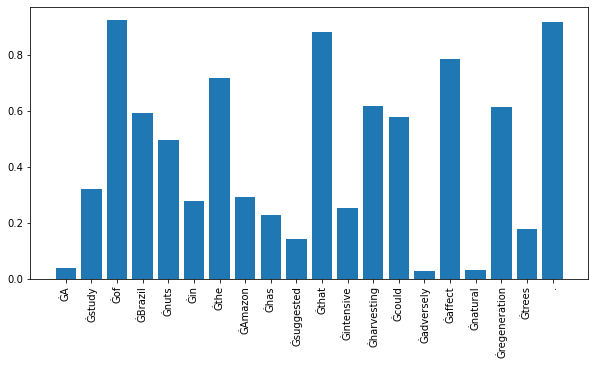


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has suggested that intensive harvesting could adversely affect the regeneration of the trees. 



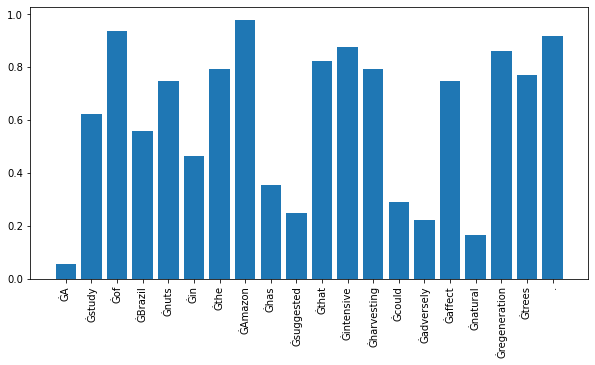

 A->0.05509; study->0.62216; of->0.44740; Brazil->0.55971; nuts->0.74810; in->0.46471; the->0.73898; Amazon->0.97880; has->0.35548; suggested->0.24771; that->0.82438; intensive->0.87429; harvesting->0.79212; could->0.28997; adversely->0.22157; affect->0.74697; the->0.79427; natural->0.16625; regeneration->0.86270; of->0.93724; the->0.72578; trees->0.77032;.->0.91613;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracke

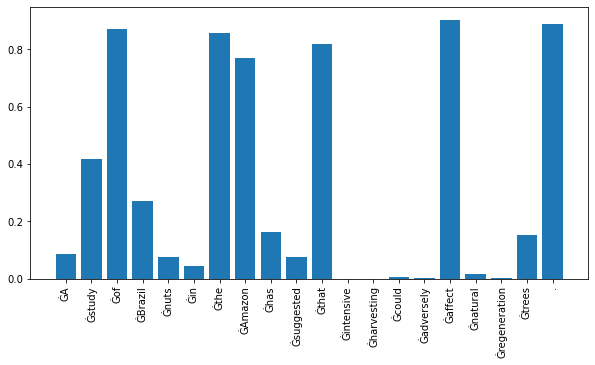


 Fixed_Context:1
 Summary:   The availability of food in the Amazon has a significant impact on the dispersal of Brazil nuts, a study has found. 



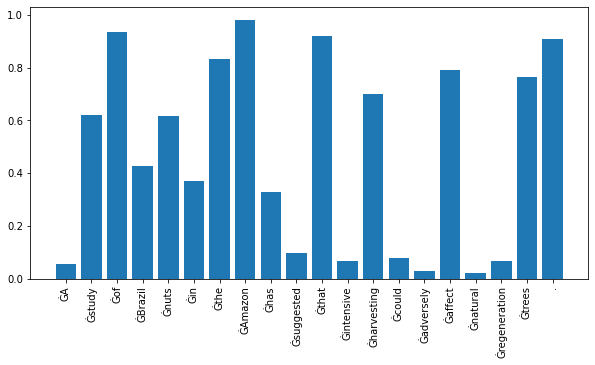

 A->0.05374; study->0.61934; of->0.41561; Brazil->0.42695; nuts->0.61578; in->0.37193; the->0.66894; Amazon->0.98089; has->0.32753; suggested->0.09581; that->0.92019; intensive->0.06639; harvesting->0.70153; could->0.07720; adversely->0.02968; affect->0.79088; the->0.67925; natural->0.02334; regeneration->0.06567; of->0.93585; the->0.83125; trees->0.76346;.->0.90658;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economicallyIn order to get a better understanding of how the seeds were dispersed, they tracked 1,800 marked seeds to see how seasonal food availa

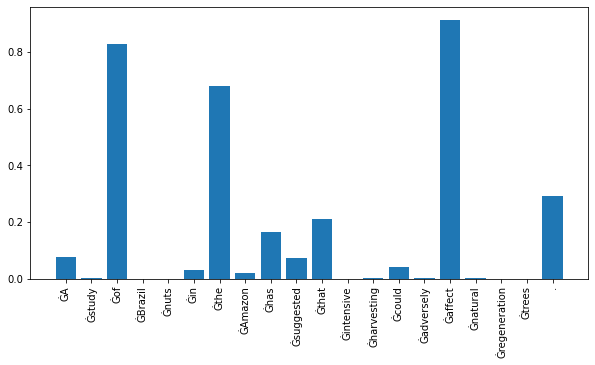


 Fixed_Context:1
 Summary:   A study of Brazil nuts has suggested that intensive harvesting could adversely affect the natural regeneration of the trees. 



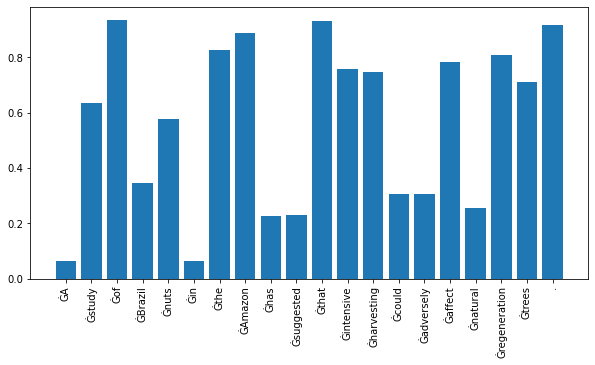

 A->0.06359; study->0.63288; of->0.37860; Brazil->0.34508; nuts->0.57746; in->0.06276; the->0.59804; Amazon->0.88820; has->0.22694; suggested->0.23111; that->0.93175; intensive->0.75730; harvesting->0.74779; could->0.30528; adversely->0.30436; affect->0.78387; the->0.77253; natural->0.25431; regeneration->0.80778; of->0.93515; the->0.82606; trees->0.71036;.->0.91582;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracked 1,800 marked seeds to see how seasonal food 

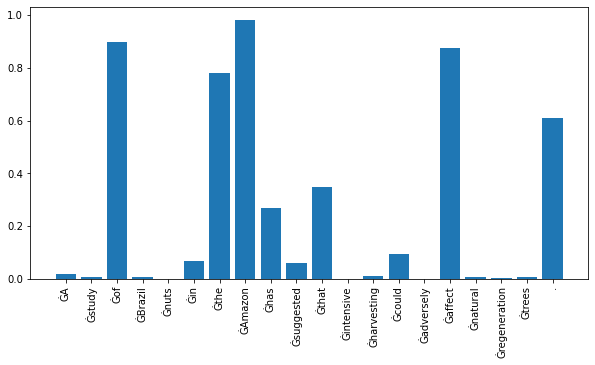


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has suggested that intensive harvesting could adversely affect the regeneration of the trees. 



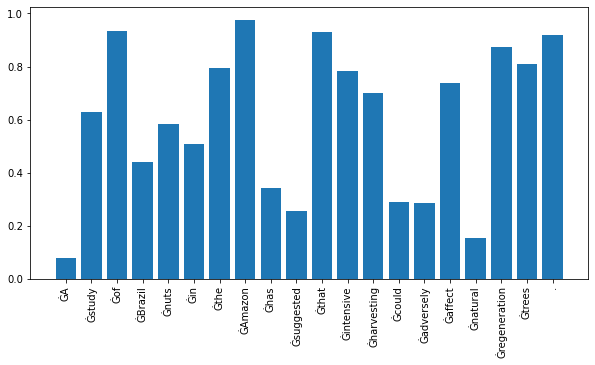

 A->0.07714; study->0.62818; of->0.45994; Brazil->0.44103; nuts->0.58511; in->0.50780; the->0.76074; Amazon->0.97616; has->0.34292; suggested->0.25455; that->0.93142; intensive->0.78258; harvesting->0.70004; could->0.28874; adversely->0.28586; affect->0.73844; the->0.73567; natural->0.15295; regeneration->0.87507; of->0.93393; the->0.79450; trees->0.81057;.->0.91754;

Interaction effect for index 1938: [0.02061 0.04198 -0.02745 -0.00045 0.04126 -0.06287 0.01811 -0.00112
 0.01400 -0.02617 -0.02019 0.19702 -0.13750 -0.02584 0.00796 0.02069
 0.00916 -0.07687 0.04282 -0.00300 0.02185 0.03963 0.01149]
Interaction effect for index 1941: [-0.00061 0.01842 0.03585 -0.05955 0.04861 -0.10126 -0.05450 -0.00125
 -0.00673 0.00534 -0.09223 -0.07858 -0.02961 -0.01987 -0.02223 -0.01671
 0.00961 0.00462 -0.07696 0.00630 -0.03177 0.02077 -0.01074]
Interaction effect for index 1881: [0.00330 0.04171 -0.00556 -0.26618 0.07194 0.01385 -0.03745 0.00164
 0.00544 0.02002 0.01888 -0.04566 -0.08460 -0.00083 0.0

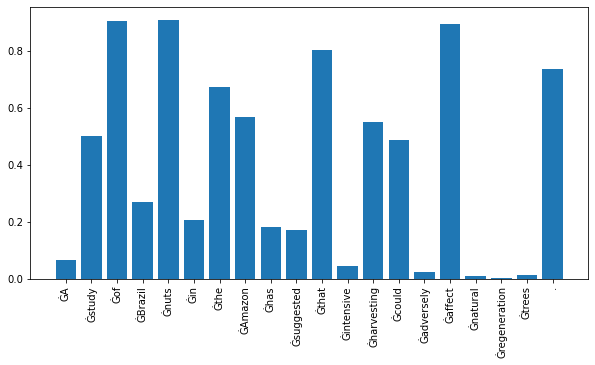


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has suggested that intensive harvesting can have a negative impact on the tree's natural regeneration. 



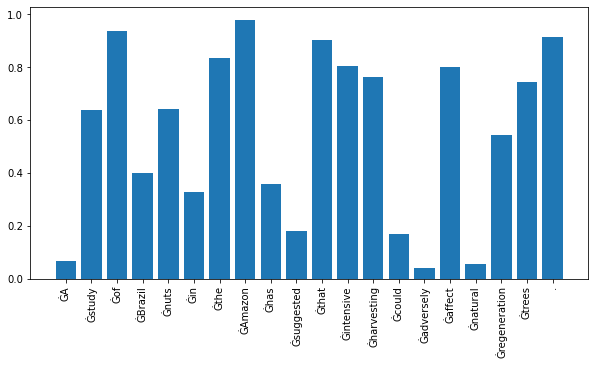

 A->0.06831; study->0.63864; of->0.39822; Brazil->0.40165; nuts->0.64128; in->0.32866; the->0.72903; Amazon->0.97960; has->0.35794; suggested->0.18057; that->0.90283; intensive->0.80444; harvesting->0.76308; could->0.16902; adversely->0.03952; affect->0.80102; the->0.73617; natural->0.05489; regeneration->0.54297; of->0.93556; the->0.83514; trees->0.74339;.->0.91287;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracke

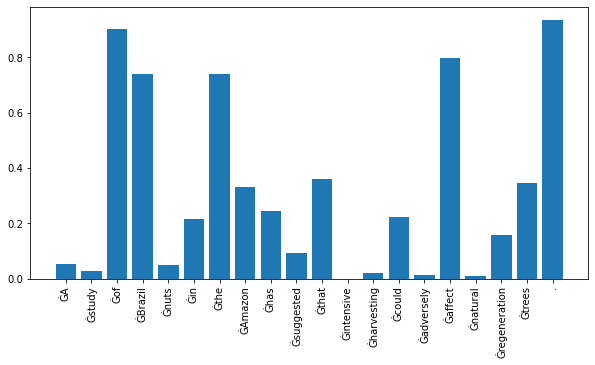


 Fixed_Context:1
 Summary:   A study of Brazil nut trees in the Amazon has suggested that intensive harvesting could adversely affect the tree's natural regeneration. 



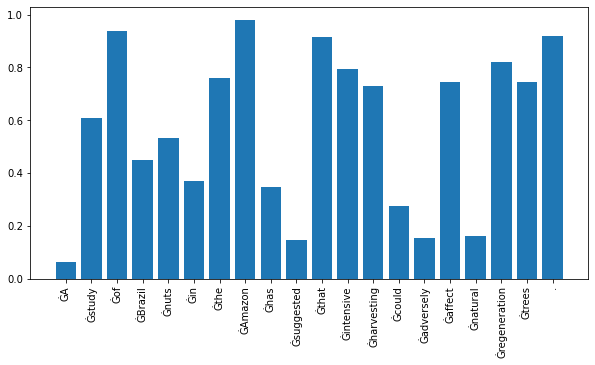

 A->0.06393; study->0.60833; of->0.40324; Brazil->0.45012; nuts->0.53184; in->0.36876; the->0.71489; Amazon->0.98062; has->0.34686; suggested->0.14531; that->0.91568; intensive->0.79383; harvesting->0.73166; could->0.27515; adversely->0.15390; affect->0.74445; the->0.75939; natural->0.16052; regeneration->0.82136; of->0.93736; the->0.72314; trees->0.74532;.->0.91881;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracke

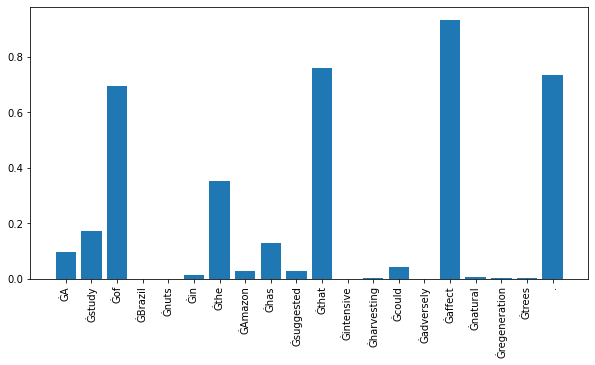


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has revealed that the amount of nuts that are eaten by rodents affects the dispersal of the seeds. 



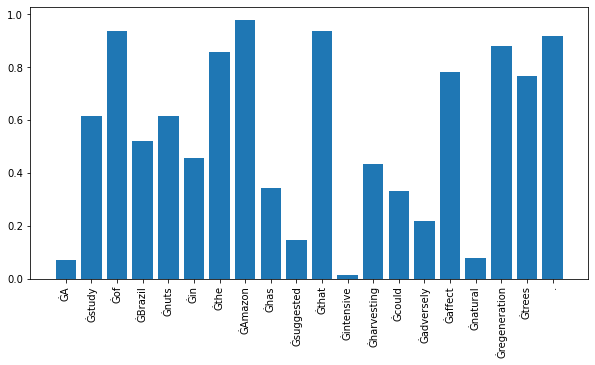

 A->0.06886; study->0.61678; of->0.42053; Brazil->0.52122; nuts->0.61386; in->0.45728; the->0.72304; Amazon->0.97946; has->0.34384; suggested->0.14638; that->0.93666; intensive->0.01462; harvesting->0.43430; could->0.33227; adversely->0.21669; affect->0.78043; the->0.71132; natural->0.07835; regeneration->0.87871; of->0.93563; the->0.85644; trees->0.76559;.->0.91936;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracke

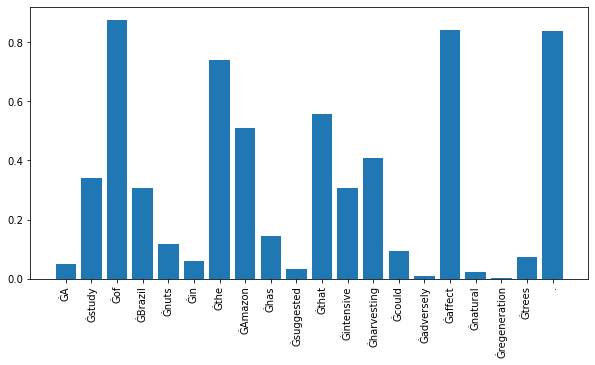


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has suggested that intensive harvesting could adversely affect the regeneration of the trees. 



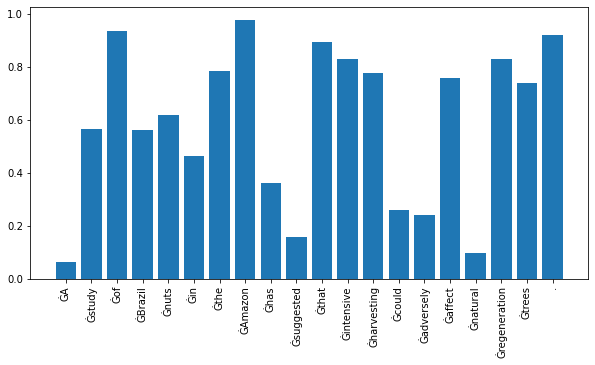

 A->0.06157; study->0.56434; of->0.48080; Brazil->0.56348; nuts->0.61843; in->0.46245; the->0.75642; Amazon->0.97802; has->0.36283; suggested->0.15810; that->0.89407; intensive->0.83177; harvesting->0.77847; could->0.25806; adversely->0.23948; affect->0.75992; the->0.78375; natural->0.09690; regeneration->0.83142; of->0.93662; the->0.77580; trees->0.73932;.->0.91993;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to comeIn order to get a better understanding of how the seeds were dispersed, they tracked 1,800 marked se

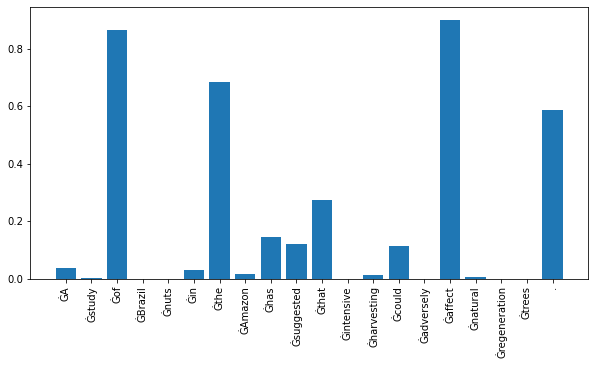


 Fixed_Context:1
 Summary:   A study of Brazil nuts has suggested that intensive harvesting could adversely affect the natural regeneration of the trees. 



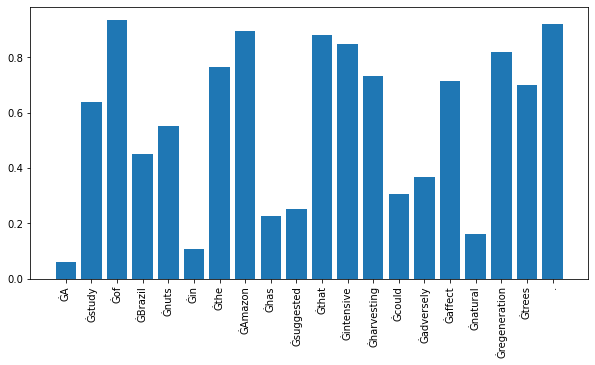

 A->0.06206; study->0.63757; of->0.37889; Brazil->0.45088; nuts->0.55101; in->0.10819; the->0.64885; Amazon->0.89683; has->0.22628; suggested->0.25294; that->0.88033; intensive->0.84884; harvesting->0.73372; could->0.30557; adversely->0.36710; affect->0.71459; the->0.76444; natural->0.16085; regeneration->0.81894; of->0.93559; the->0.76613; trees->0.69953;.->0.92085;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracked 1,800 marked seeds to see how sea

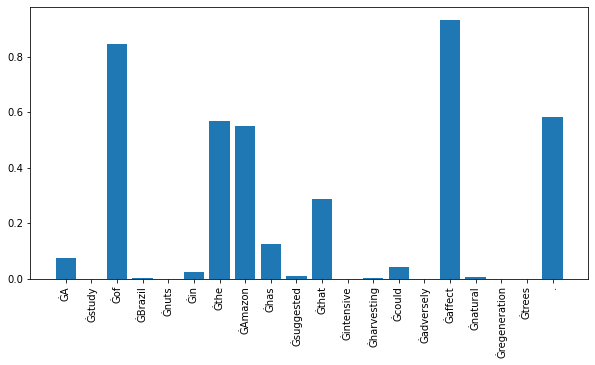


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has suggested that intensive harvesting could adversely affect the natural regeneration of the trees. 



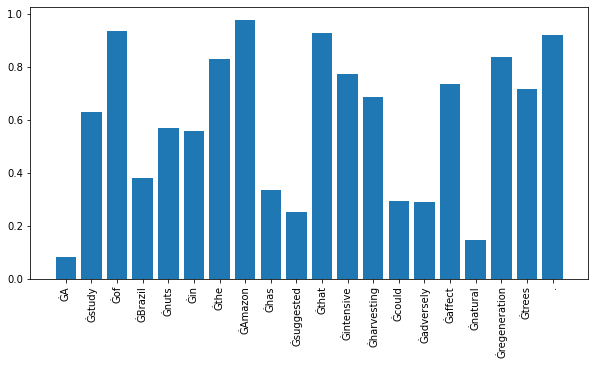

 A->0.08140; study->0.63024; of->0.46395; Brazil->0.38186; nuts->0.56945; in->0.55733; the->0.72579; Amazon->0.97722; has->0.33592; suggested->0.25039; that->0.92861; intensive->0.77421; harvesting->0.68493; could->0.29461; adversely->0.28780; affect->0.73356; the->0.75713; natural->0.14646; regeneration->0.83503; of->0.93434; the->0.82927; trees->0.71770;.->0.91835;

Interaction effect for index 1933: [0.01889 0.02657 -0.06751 -0.07392 -0.01126 -0.16749 0.01110 0.00014
 0.03465 -0.01553 -0.01631 0.75629 0.00653 0.07882 -0.08178 0.00199
 0.07601 0.04592 0.56253 0.00155 -0.03353 -0.02651 0.00831]
Interaction effect for index 1924: [0.00944 0.05881 -0.04014 0.02891 0.06005 -0.03505 -0.01851 -0.00183
 0.01622 -0.06531 -0.00230 -0.06199 -0.03684 -0.03222 0.04329 0.01333
 -0.00397 -0.07830 0.09214 0.00152 0.01432 -0.03171 0.00482]
Interaction effect for index 1829: [0.02027 0.03387 0.01088 -0.01108 -0.02559 0.10978 0.01274 0.00667
 -0.00736 0.02663 -0.03743 0.09016 -0.11583 0.00677 0.10502 

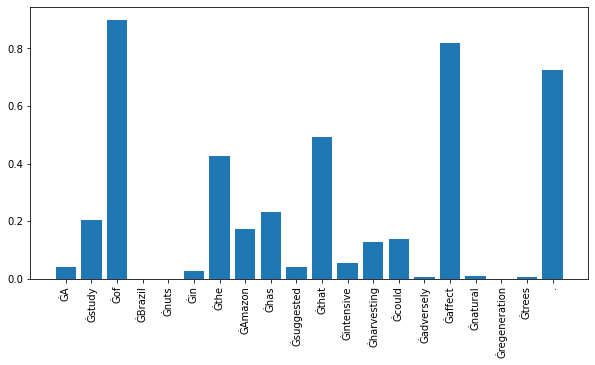


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has suggested that intensive harvesting could adversely affect the tree's natural regeneration. 



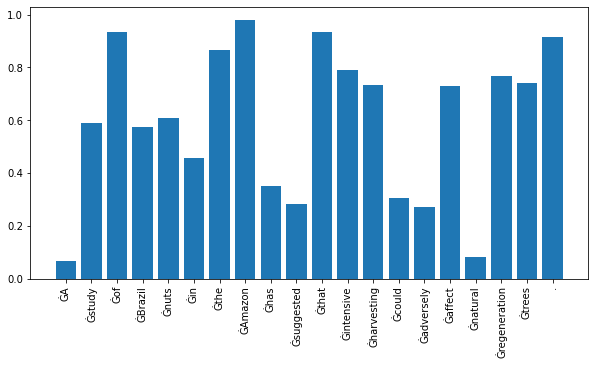

 A->0.06809; study->0.58836; of->0.42389; Brazil->0.57344; nuts->0.60822; in->0.45723; the->0.72979; Amazon->0.98051; has->0.35255; suggested->0.28228; that->0.93268; intensive->0.79111; harvesting->0.73325; could->0.30496; adversely->0.27198; affect->0.72950; the->0.71118; natural->0.08369; regeneration->0.76643; of->0.93385; the->0.86566; trees->0.74285;.->0.91705;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracke

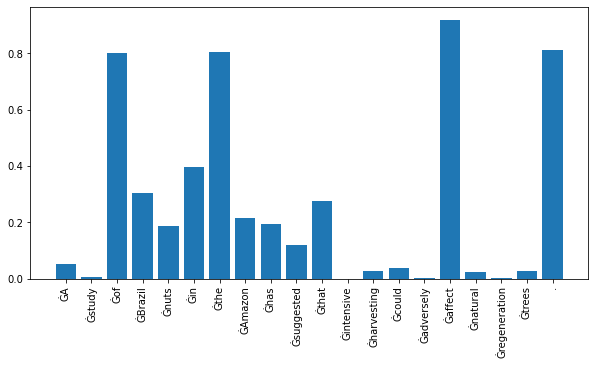


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has revealed that the amount of nuts that are eaten by large rodents affects the dispersal of the seeds. 



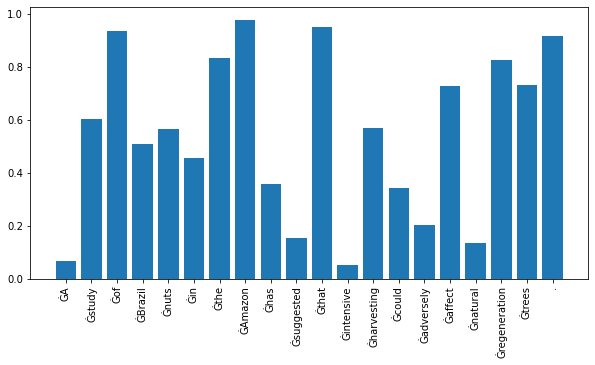

 A->0.06560; study->0.60484; of->0.44400; Brazil->0.50991; nuts->0.56658; in->0.45622; the->0.74170; Amazon->0.97841; has->0.35752; suggested->0.15380; that->0.95060; intensive->0.05072; harvesting->0.57123; could->0.34358; adversely->0.20147; affect->0.72975; the->0.73009; natural->0.13469; regeneration->0.82507; of->0.93466; the->0.83393; trees->0.73230;.->0.91613;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of AmazoniaIn order to get a better understanding of how the seeds were dispersed, they tracked

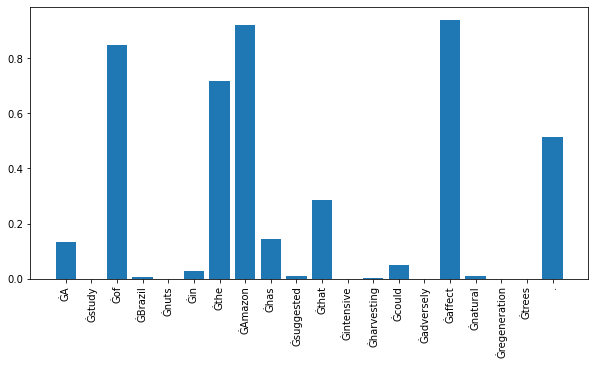


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has suggested that intensive harvesting could adversely affect the natural regeneration of the trees. 



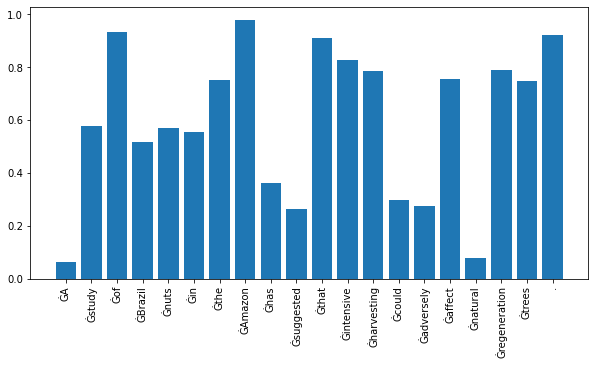

 A->0.06279; study->0.57607; of->0.48600; Brazil->0.51809; nuts->0.56920; in->0.55504; the->0.75187; Amazon->0.97969; has->0.36122; suggested->0.26553; that->0.90952; intensive->0.82798; harvesting->0.78414; could->0.29748; adversely->0.27615; affect->0.75392; the->0.72228; natural->0.07937; regeneration->0.79001; of->0.93435; the->0.73469; trees->0.74779;.->0.92159;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come.In order to get a better understanding of how the seeds were dispersed, they tracked 1,800 marked s

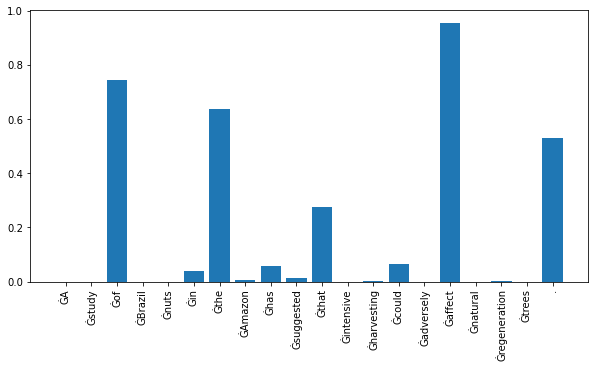


 Fixed_Context:1
 Summary:   A study of Brazil nuts has suggested that intensive harvesting could adversely affect the natural regeneration of the trees. 



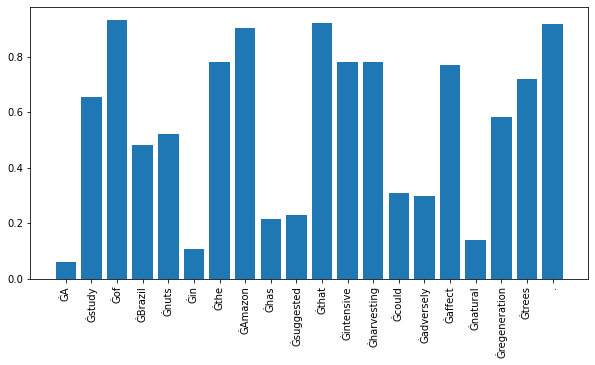

 A->0.06120; study->0.65333; of->0.38135; Brazil->0.48064; nuts->0.52157; in->0.10581; the->0.67447; Amazon->0.90347; has->0.21371; suggested->0.22915; that->0.92140; intensive->0.77973; harvesting->0.78195; could->0.30715; adversely->0.29818; affect->0.76833; the->0.78120; natural->0.13960; regeneration->0.58407; of->0.93269; the->0.72996; trees->0.71834;.->0.91911;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracked 1,800 marked seeds to see how seasonal food availability affected agoutis' and acouchis' - large scatter-hoarding rodents - caching

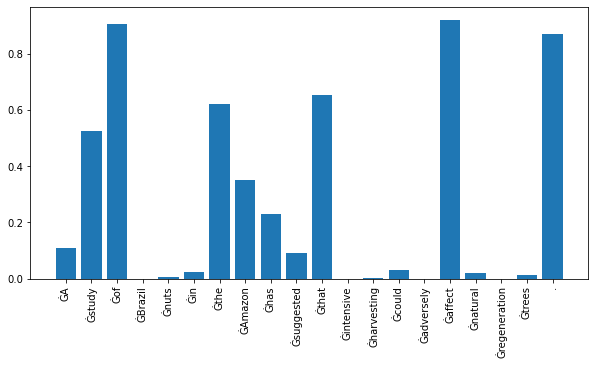


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has suggested that intensive harvesting could adversely affect the natural regeneration of the trees. 



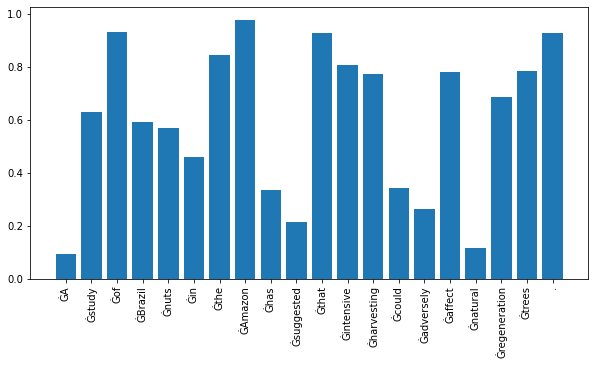

 A->0.09143; study->0.62940; of->0.42762; Brazil->0.59222; nuts->0.56968; in->0.45794; the->0.71183; Amazon->0.97804; has->0.33426; suggested->0.21471; that->0.92656; intensive->0.80697; harvesting->0.77201; could->0.34256; adversely->0.26305; affect->0.78091; the->0.77400; natural->0.11623; regeneration->0.68678; of->0.93355; the->0.84480; trees->0.78411;.->0.92800;


  Masked input:  When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracked 1,800 marked seeds to see how seasonal food availability affected agoutis' and acouchis' - large scatter-hoar

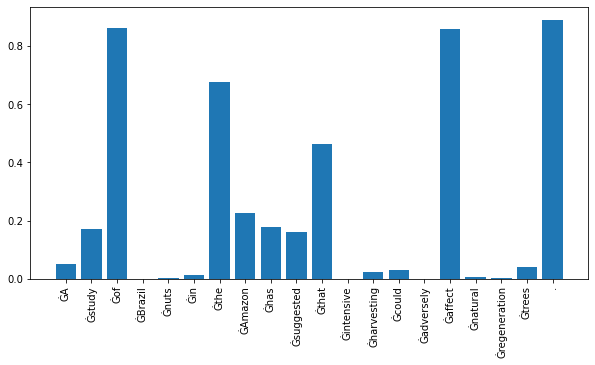


 Fixed_Context:1
 Summary:   A study of Brazil nut trees in the Amazon has found that the amount of nuts eaten by large rodents affects the dispersal of the seeds. 



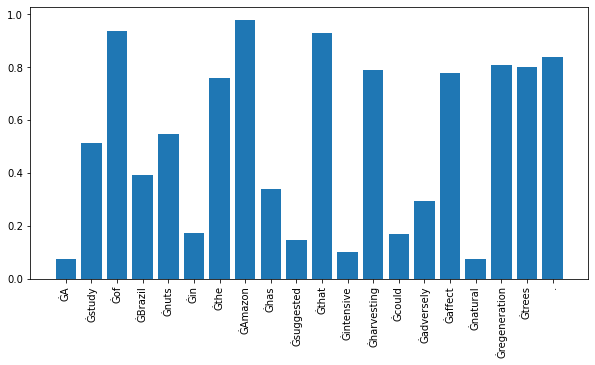

 A->0.07542; study->0.51500; of->0.46300; Brazil->0.39424; nuts->0.54645; in->0.17120; the->0.74090; Amazon->0.97968; has->0.33757; suggested->0.14781; that->0.92919; intensive->0.09957; harvesting->0.79127; could->0.17084; adversely->0.29549; affect->0.77780; the->0.75970; natural->0.07301; regeneration->0.81032; of->0.93814; the->0.74678; trees->0.80074;.->0.83990;

Interaction effect for index 1865: [0.00521 -0.02464 -0.00600 0.06339 -0.00766 -0.03682 -0.01542 0.00028
 0.02361 0.04411 0.03198 0.05163 0.08350 0.02813 0.01124 -0.07377 -0.01034
 -0.00612 -0.02333 -0.00265 0.08259 -0.04220 -0.00296]
Interaction effect for index 1695: [0.00232 -0.00922 0.03510 0.04911 -0.02885 0.05968 0.01362 0.00714 0.00604
 -0.00386 0.03595 -0.01672 0.04568 0.01092 -0.03829 0.05507 -0.00126
 -0.08803 -0.18098 -0.00407 -0.06204 0.01484 0.00307]
Interaction effect for index 1931: [-0.04829 0.03990 0.05418 0.04027 -0.00692 -0.02288 0.10557 -0.00446
 0.01890 -0.07616 0.00904 -0.74922 0.05107 -0.06103 0.089

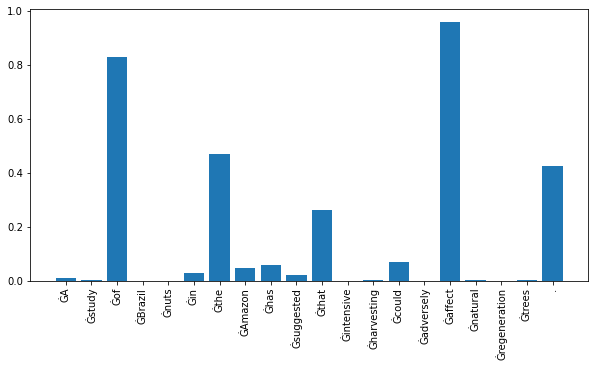


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has revealed that the amount of nuts that are eaten by large rodents affects the dispersal of the seeds. 



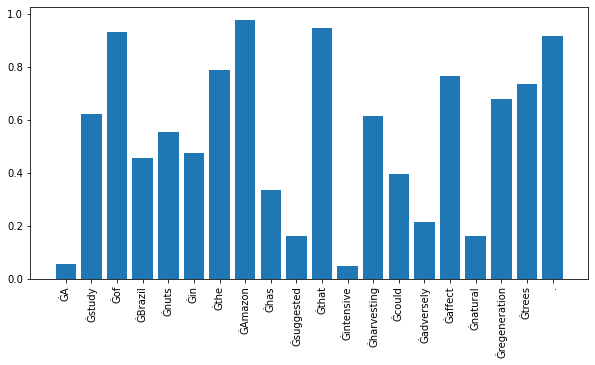

 A->0.05511; study->0.62068; of->0.41557; Brazil->0.45443; nuts->0.55579; in->0.47497; the->0.77105; Amazon->0.97822; has->0.33399; suggested->0.16166; that->0.94709; intensive->0.04792; harvesting->0.61518; could->0.39626; adversely->0.21284; affect->0.76658; the->0.78971; natural->0.15957; regeneration->0.67711; of->0.93283; the->0.72907; trees->0.73649;.->0.91766;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracke

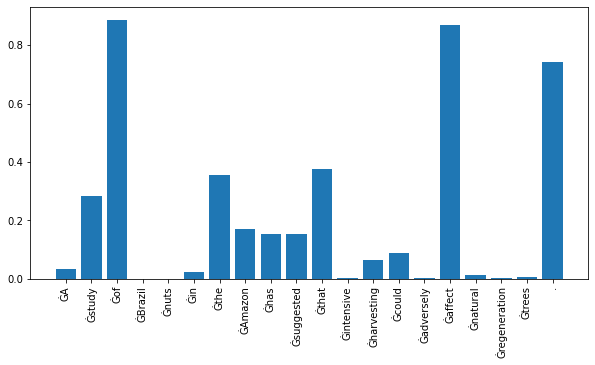


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has suggested that intensive harvesting could adversely affect the natural regeneration of the trees. 



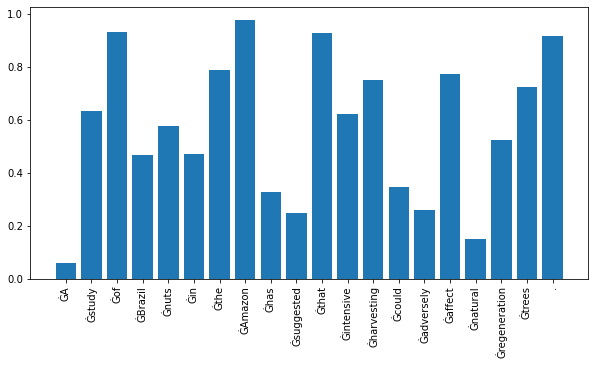

 A->0.06007; study->0.63500; of->0.43256; Brazil->0.46654; nuts->0.57830; in->0.46992; the->0.77184; Amazon->0.97860; has->0.32921; suggested->0.24657; that->0.93034; intensive->0.62384; harvesting->0.75138; could->0.34737; adversely->0.26024; affect->0.77203; the->0.79065; natural->0.15054; regeneration->0.52521; of->0.93261; the->0.67992; trees->0.72572;.->0.91722;


  Masked input:  Researchers found that large rodents quickly ate the nuts,When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracked 1,800 marked seeds to see how seasonal food availab

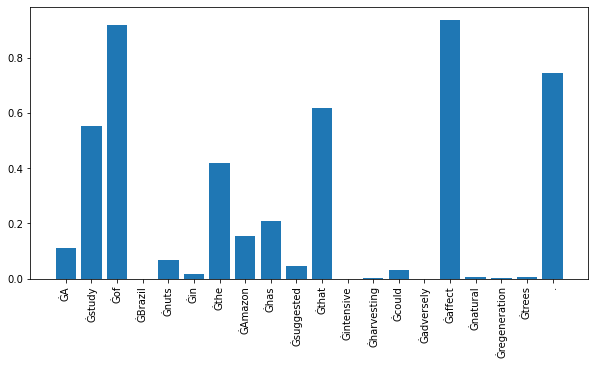


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has suggested that intensive harvesting could adversely affect the regeneration of the trees. 



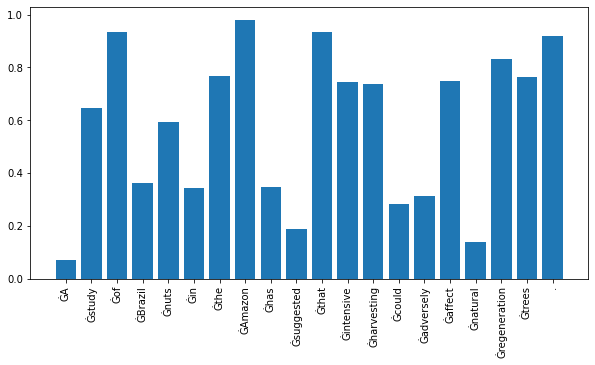

 A->0.06955; study->0.64658; of->0.34451; Brazil->0.36319; nuts->0.59207; in->0.34354; the->0.70942; Amazon->0.98060; has->0.34802; suggested->0.18774; that->0.93447; intensive->0.74480; harvesting->0.73726; could->0.28338; adversely->0.31195; affect->0.74706; the->0.76711; natural->0.13978; regeneration->0.83360; of->0.93550; the->0.72972; trees->0.76215;.->0.91761;


  Masked input:   rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracked 1,800 marked seeds to see how seasonal food availability

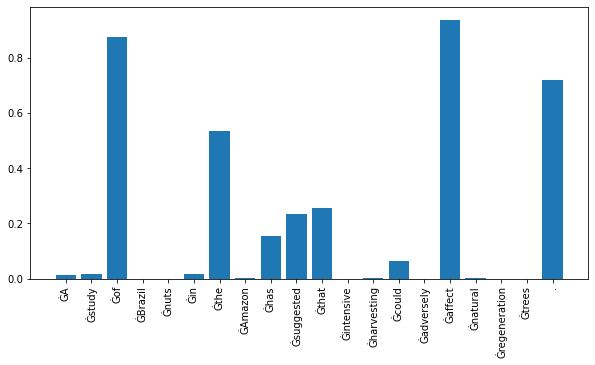


 Fixed_Context:1
 Summary:  Researchers have discovered that Brazil nuts are more likely to be eaten during the wet season than during the dry season. 



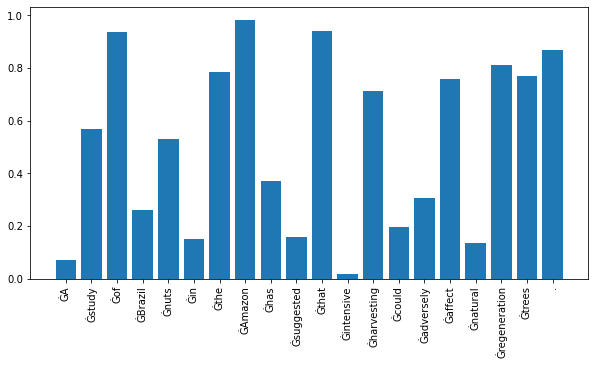

 A->0.06949; study->0.56873; of->0.48449; Brazil->0.26134; nuts->0.53212; in->0.15121; the->0.70762; Amazon->0.98280; has->0.37222; suggested->0.15940; that->0.94215; intensive->0.01692; harvesting->0.71113; could->0.19691; adversely->0.30479; affect->0.75917; the->0.78574; natural->0.13541; regeneration->0.81066; of->0.93694; the->0.72549; trees->0.76993;.->0.86908;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of.In order to get a better understanding of how the seeds were dispersed, they tracked 1,800 m

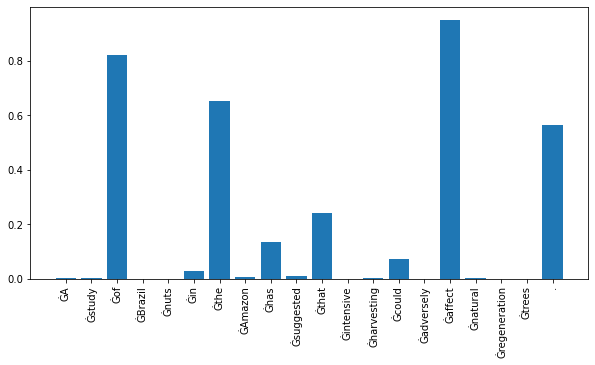


 Fixed_Context:1
 Summary:   A study of Brazil nuts has suggested that intensive harvesting could adversely affect the natural regeneration of the trees. 



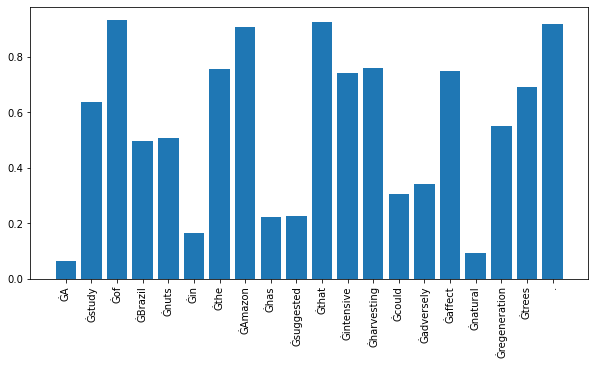

 A->0.06228; study->0.63924; of->0.40093; Brazil->0.49703; nuts->0.50820; in->0.16341; the->0.66567; Amazon->0.90981; has->0.22174; suggested->0.22556; that->0.92543; intensive->0.74234; harvesting->0.75923; could->0.30590; adversely->0.34068; affect->0.74917; the->0.75723; natural->0.09172; regeneration->0.55187; of->0.93435; the->0.73230; trees->0.69269;.->0.91863;


  Masked input:  Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracked 1,800

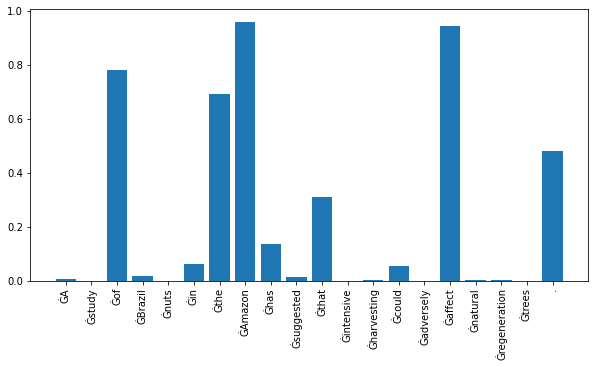


 Fixed_Context:1
 Summary:   A study of Brazil nuts in the Amazon has suggested that intensive harvesting could adversely affect the tree's natural regeneration. 



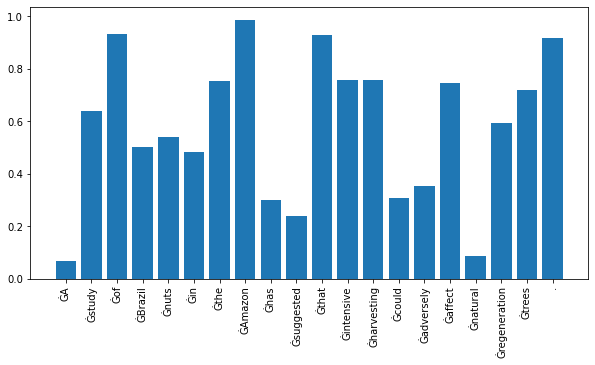

Partition explainer: 2it [03:26, 103.35s/it]                                                                           

 A->0.06584; study->0.64069; of->0.43366; Brazil->0.50338; nuts->0.53927; in->0.48121; the->0.69974; Amazon->0.98638; has->0.29840; suggested->0.23836; that->0.92731; intensive->0.75670; harvesting->0.75584; could->0.30887; adversely->0.35254; affect->0.74682; the->0.75463; natural->0.08786; regeneration->0.59469; of->0.93374; the->0.70101; trees->0.71868;.->0.91687;

Interaction effect for index 1779: [-0.01003 0.04979 -0.04923 -0.08768 -0.00109 -0.00431 0.03732 -0.00076
 -0.03694 0.00884 0.01220 -0.15454 0.00865 0.11191 0.02609 0.05627 0.10996
 0.02928 -0.35887 -0.00476 -0.18550 -0.02186 0.00196]
Interaction effect for index 1900: [0.00401 0.09927 -0.08736 -0.26845 0.00914 -0.16944 -0.08773 0.00454
 0.04004 -0.04627 0.03279 -0.11344 -0.12956 0.02130 0.07574 -0.02415
 0.05285 0.05603 0.09781 -0.00122 -0.05214 -0.02042 0.03000]
Interaction effect for index 1475: [0.00730 0.02554 -0.00011 0.02104 -0.04270 0.04583 -0.07293 0.01354
 -0.03620 -0.01083 0.01671 -0.05627 -0.05355 0.01948 0.14

In [31]:
shap_values = explainer(dataset['document'][10:11])

In [50]:
explainer_attn = shap.Explainer(f_cp_attn,tokenizer,model_kwargs=f_kwargs)
explainer_attn.masker.mask_token=None
explainer_attn.masker.mask_token_str=""
explainer_attn.masker.fixed_background = True

explainers.Partition is still in an alpha state, so use with caution...


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Keyword arguments {'min_length': 0} not recognized.


 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



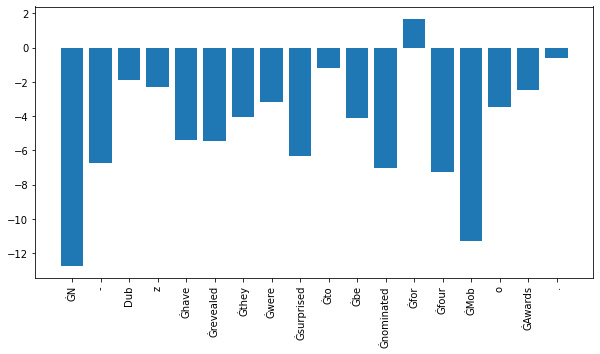

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



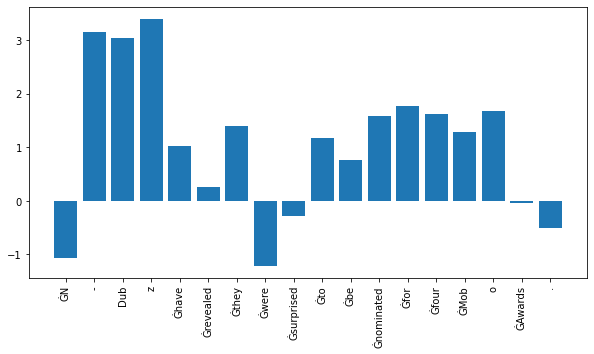

Index in batch: 832
 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



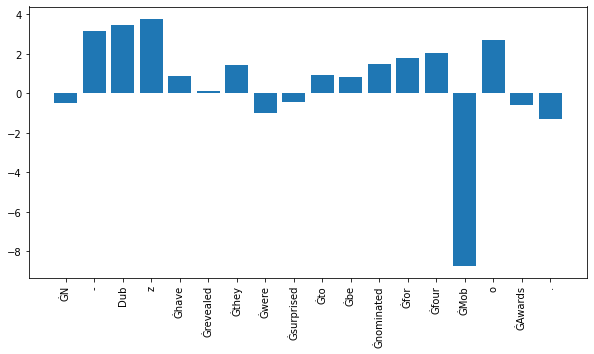

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



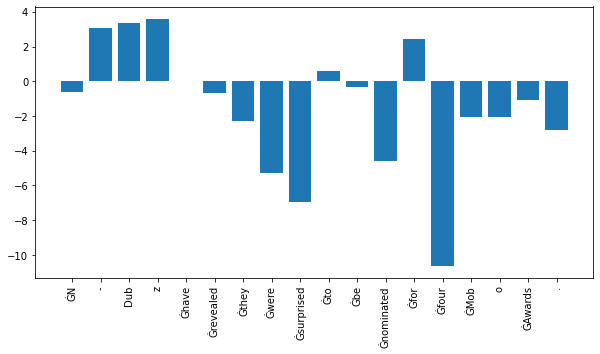

Interaction effect for index 832: [12.70477 9.76902 5.64153 6.29019 5.28552 4.61755 1.74510 -1.87567
 -0.77061 1.51027 3.87139 2.30072 0.80725 -2.95454 -0.80328 2.43546
 0.83675 -3.01906]
Index in batch: 832
 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



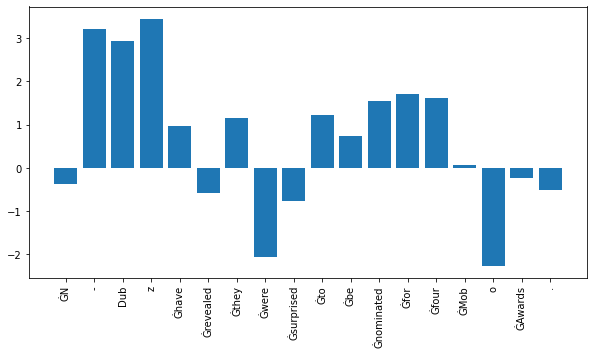

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



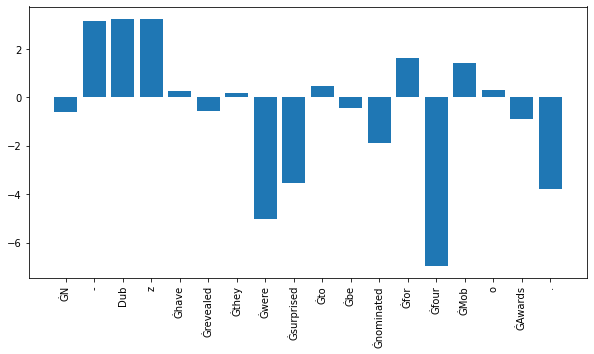

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



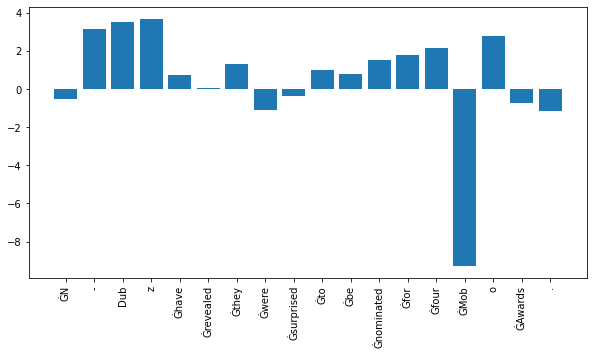

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



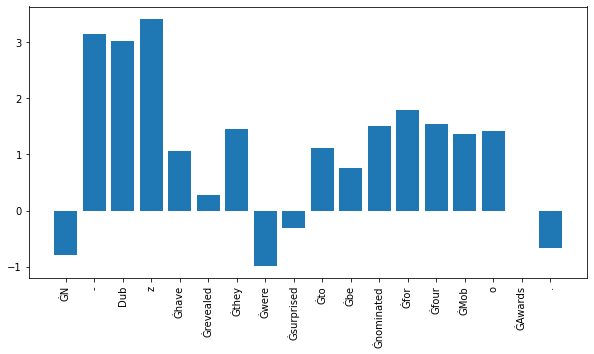

Interaction effect for index 831: [0.68507 0.11959 -0.19578 -0.31833 0.19796 -0.75204 2.25146 -0.57328
 2.94649 -0.06611 -0.15246 2.68309 -0.87813 3.66096 2.26737 -1.55429
 0.01078 -0.98502]
Interaction effect for index 830: [0.23316 -0.00759 0.01272 -0.08720 -0.12489 -0.03871 -0.05836 0.10947
 -0.01340 0.00142 -0.05590 -0.02097 -0.01550 -0.00825 -0.46665 -0.18723
 -0.11302 -0.02355]
Index in batch: 830
 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



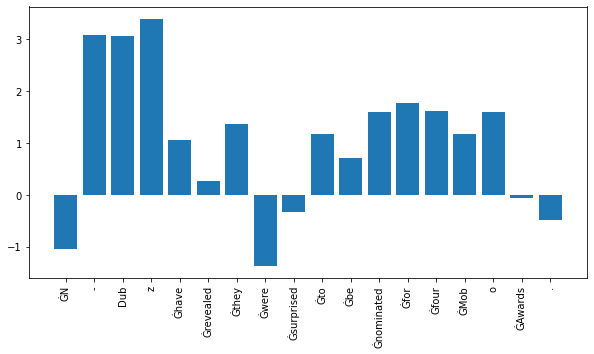

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



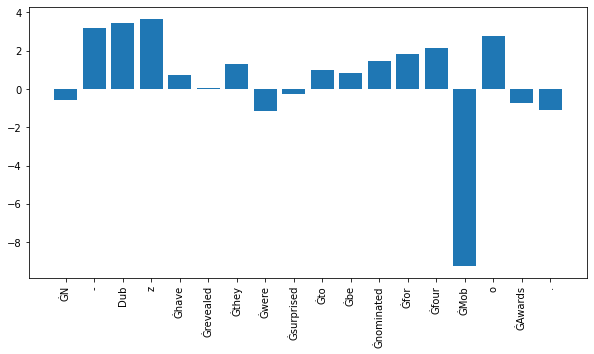

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



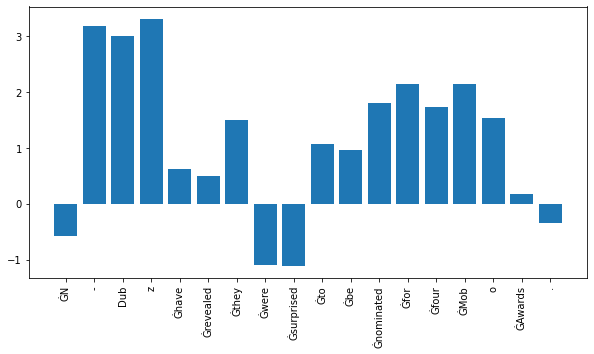

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



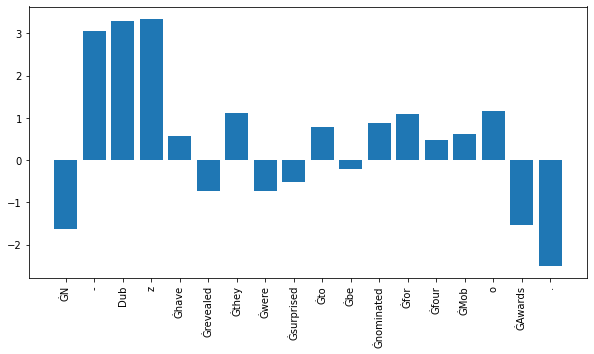

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



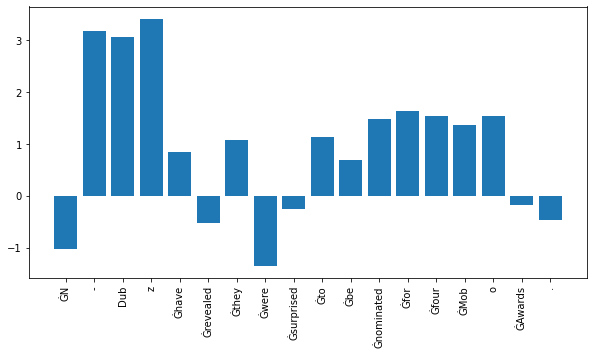

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



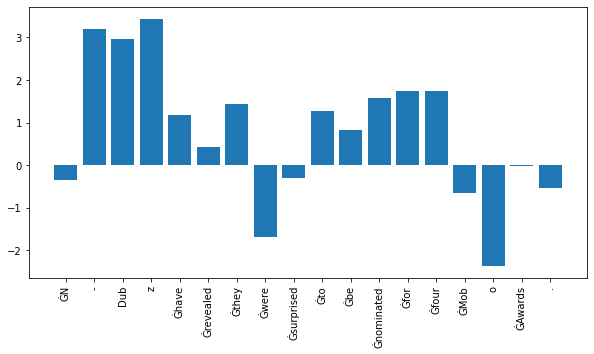

Interaction effect for index 828: [-0.06515 -0.01585 -0.02131 -0.00483 -0.00232 -0.02784 -0.03073 -0.23184
 0.06210 0.01631 -0.00796 -0.05585 0.03845 -0.01931 -0.08869 -0.08357
 0.01452 0.10807]
Interaction effect for index 829: [-0.53508 -0.04996 0.01674 0.02999 -0.07254 0.07132 1.03408 4.39972
 2.17854 0.20510 0.44774 2.98606 -0.18520 7.57190 0.06261 0.71274 -0.41113
 1.43041]
Interaction effect for index 827: [0.05886 0.01120 0.05710 0.01505 0.02110 0.21811 -0.02374 0.23367 0.47819
 -0.00771 0.01259 -0.07278 -0.10441 0.02114 -0.64862 -0.23177 0.08624
 0.01598]
Index in batch: 827
 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



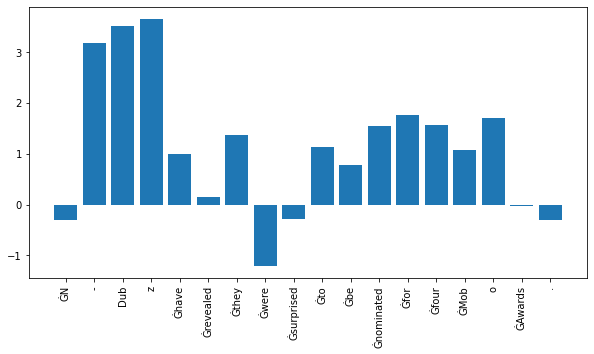

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



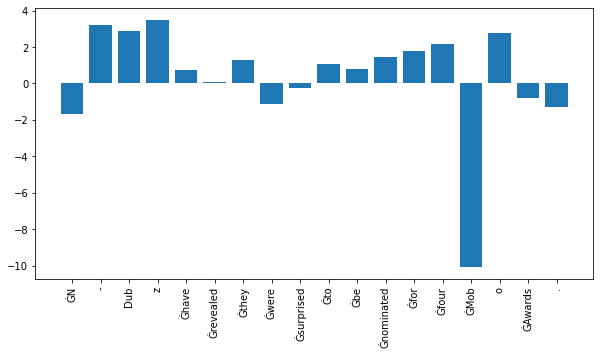

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



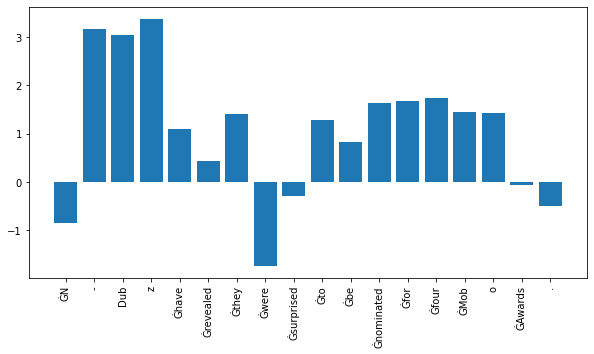

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



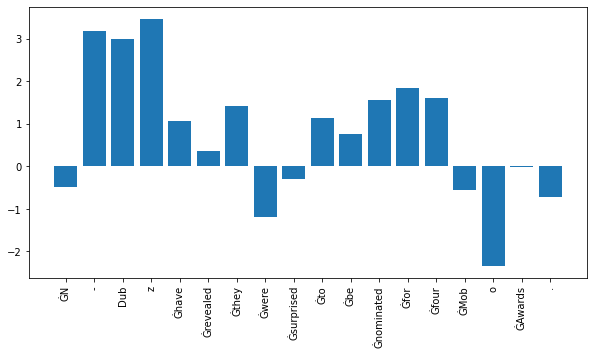

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



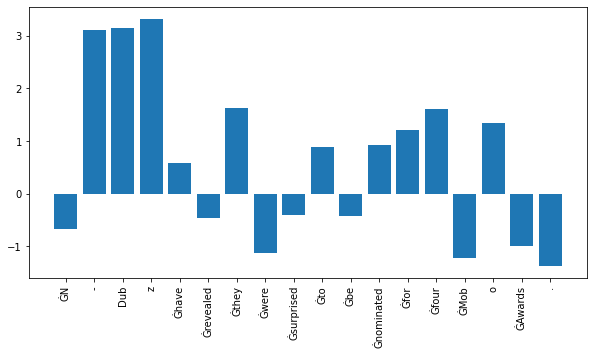

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



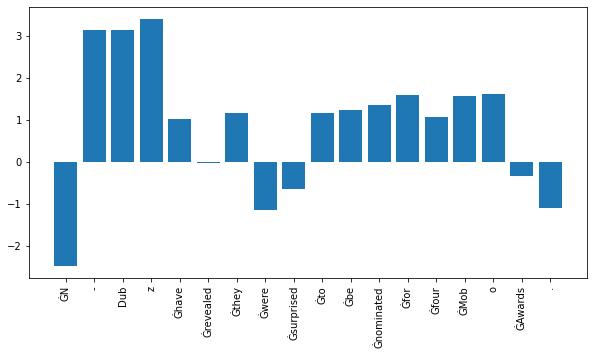

Interaction effect for index 825: [-0.32349 0.05045 -0.13830 0.07924 0.02606 -0.06053 -0.02898 0.05049
 0.01191 0.02129 -0.02320 -0.02314 -0.02459 -0.02205 -1.05164 0.03717
 -0.07242 0.00254]
Interaction effect for index 823: [0.06819 0.01060 0.01165 0.01228 -0.04378 0.09922 0.00170 -0.02891 0.00156
 -0.03408 -0.00121 0.02540 0.01171 -0.01189 0.25589 -0.23222 -0.00986
 -0.16339]
Interaction effect for index 822: [-0.45363 0.04543 -0.06729 -0.01476 -0.01928 -0.00819 0.29923 -0.32652
 -0.24606 0.06926 0.26360 -0.18805 -0.05617 0.56331 -1.56576 0.12207
 0.24017 0.54397]
Index in batch: 822
 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



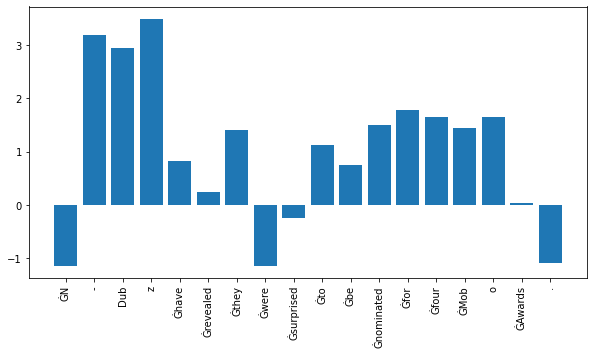

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



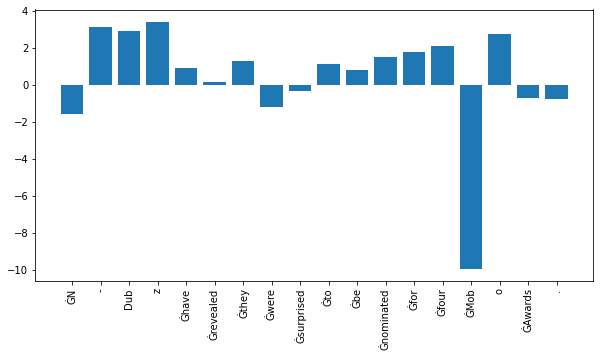

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



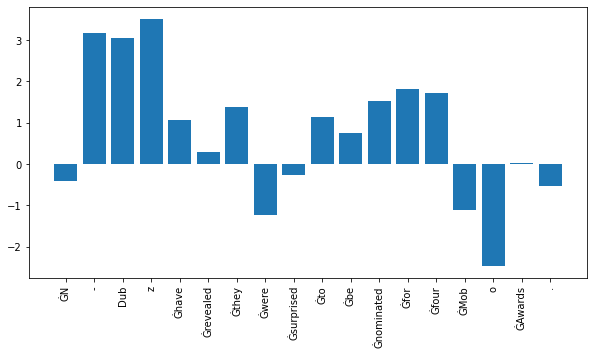

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



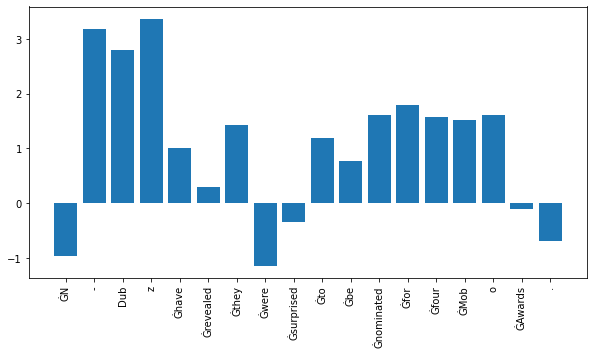

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



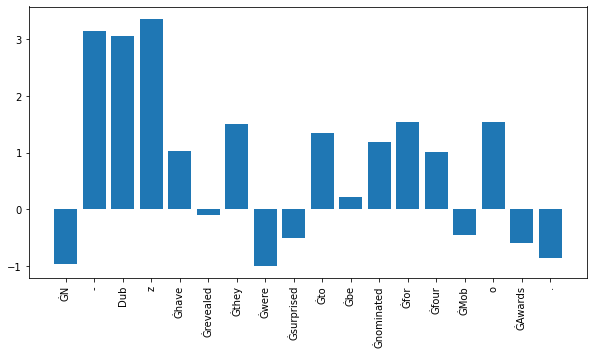

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



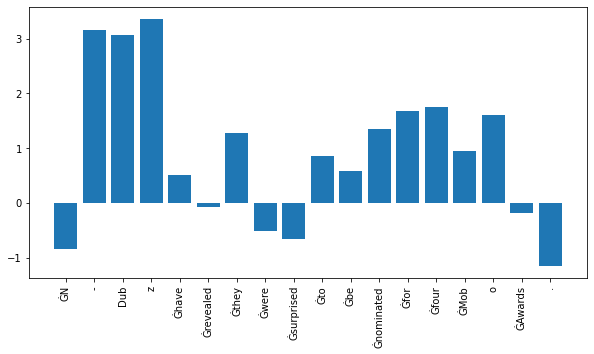

Interaction effect for index 811: [0.00880 -0.01516 -0.02181 0.01806 -0.00619 0.05059 0.02953 0.01464
 -0.00233 0.00067 0.00543 -0.02755 0.00027 -0.01717 0.29231 -0.03050
 0.18709 -0.02906]
Interaction effect for index 820: [0.17186 0.01052 -0.17728 0.01608 -0.01711 -0.02585 -0.00325 0.01924
 -0.02258 -0.00093 0.01696 0.00099 -0.00122 0.03429 -0.31624 -0.19288
 -0.01960 -0.00437]
Interaction effect for index 821: [-0.08103 0.03315 -0.04852 0.00534 -0.06943 0.02670 -0.23329 0.83240
 -0.48488 0.13375 0.45533 0.02216 0.22756 -0.48077 0.40823 0.10923 0.26805
 -0.12515]
Index in batch: 821
 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



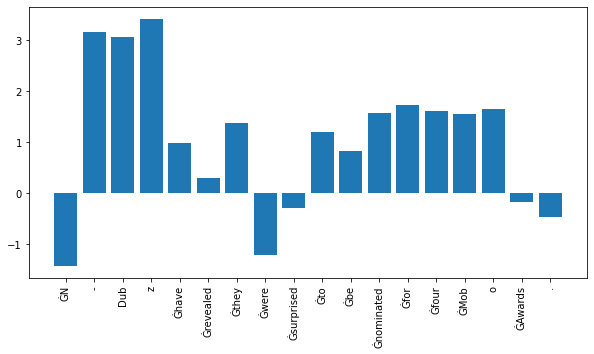

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



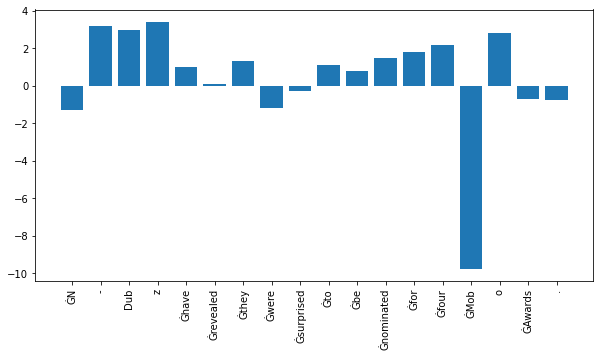

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



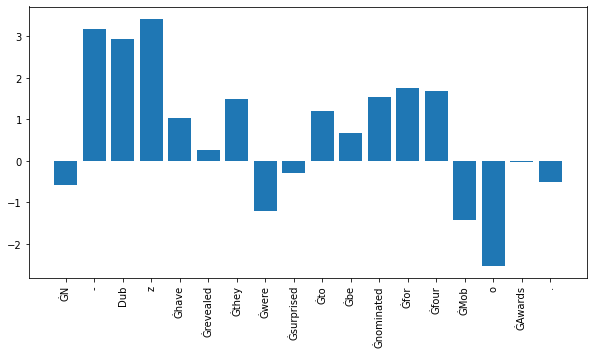

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



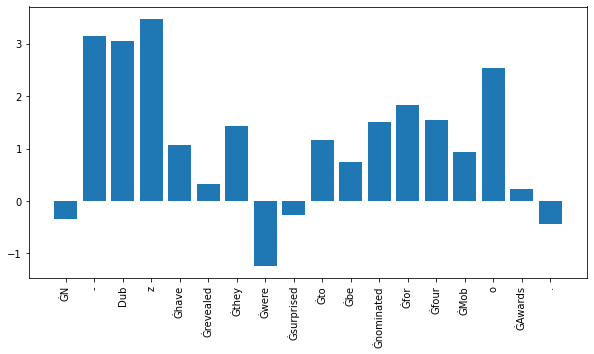

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



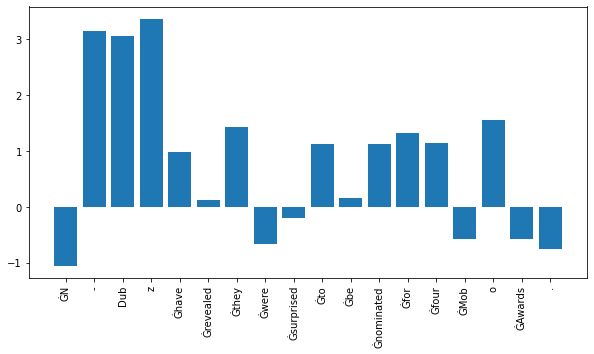

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



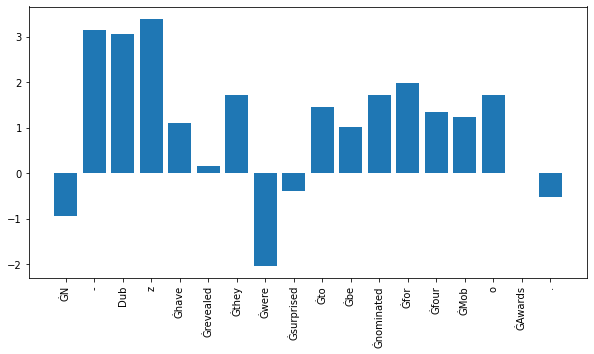

Interaction effect for index 795: [-0.11098 0.00411 0.01172 -0.00317 -0.01302 -0.03899 -0.01414 0.00727
 0.02217 -0.01913 0.03087 -0.07146 -0.03972 -0.00527 0.42017 -0.03705
 -0.14336 0.01680]
Interaction effect for index 783: [0.54769 0.00628 -0.10170 -0.00913 0.00524 0.01871 0.15836 0.01130
 -0.01015 0.04454 -0.09256 -0.05224 0.01234 -0.10265 -0.68570 0.78576
 0.22657 0.08715]
Interaction effect for index 780: [0.01744 -0.00031 0.00055 -0.00122 0.01618 0.12089 0.25561 -0.49150
 0.18806 0.04907 0.19534 0.08151 -0.00194 -0.14429 -0.18187 0.04462
 0.04517 0.07667]
Index in batch: 780
 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



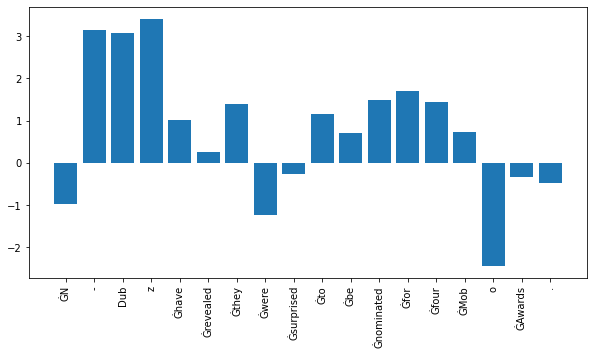

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



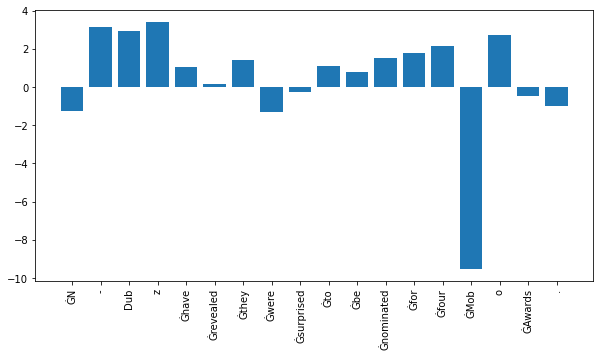

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



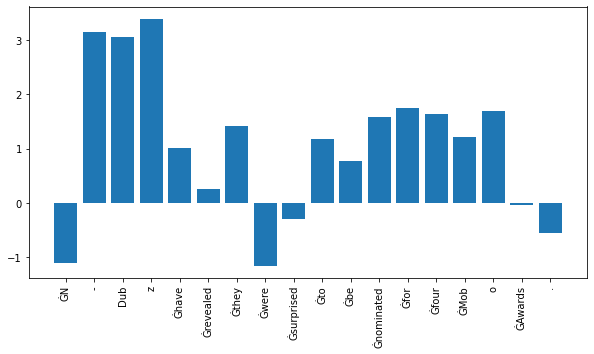

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



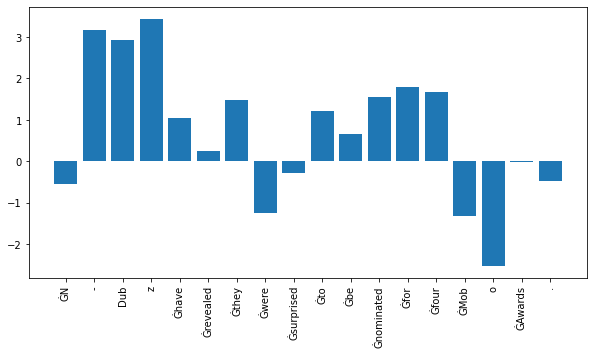

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



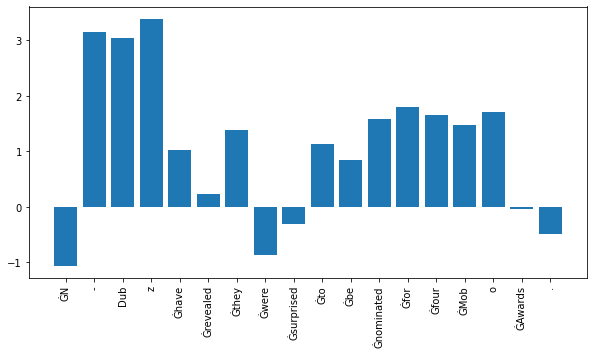

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



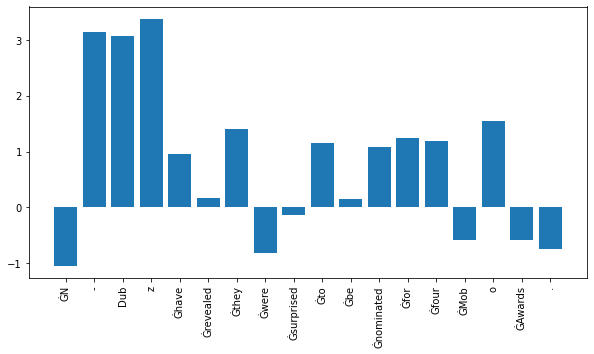

Interaction effect for index 766: [0.14577 -0.02423 0.02089 0.02342 0.01393 0.05157 0.08285 -0.15670 0.03124
 -0.00840 -0.03500 -0.03954 -0.06223 -0.20193 -0.32512 -4.16657 -0.04048
 -0.20929]
Interaction effect for index 731: [-0.01388 -0.00215 0.00323 0.00480 -0.00133 -0.01773 0.00529 0.00569
 -0.00051 0.00272 0.00357 0.00358 -0.00340 -0.00452 0.04470 0.02426
 0.00934 0.00429]
Interaction effect for index 722: [0.00492 -0.00413 0.00326 0.00100 -0.01474 0.00697 -0.02312 0.19515
 0.03111 -0.01119 0.06314 -0.03662 -0.03417 0.07525 0.17208 0.01848
 -0.00123 0.03718]
Index in batch: 722
 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



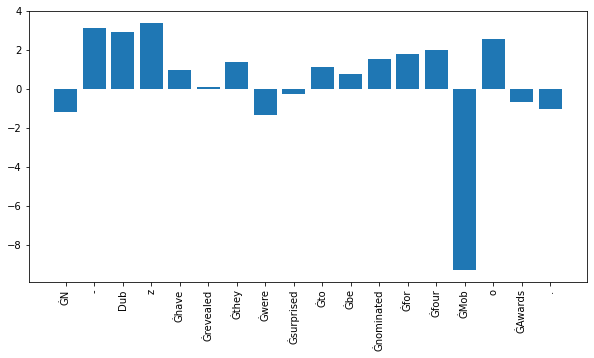

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



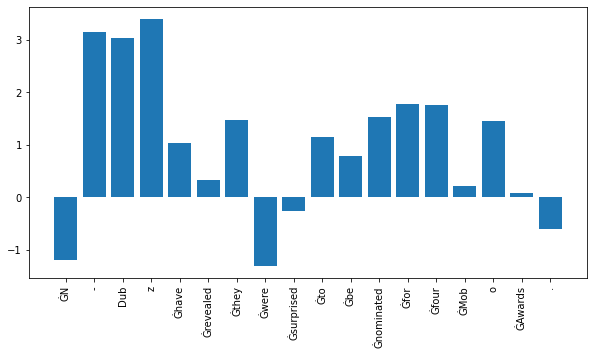

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



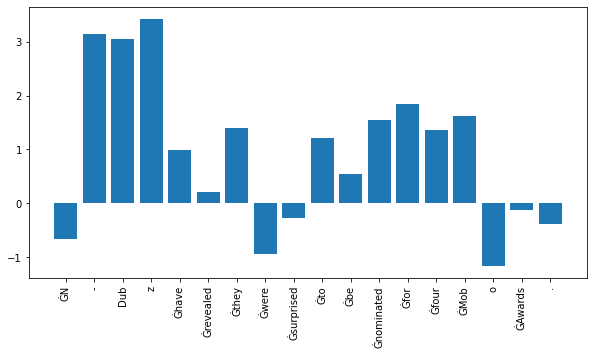

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



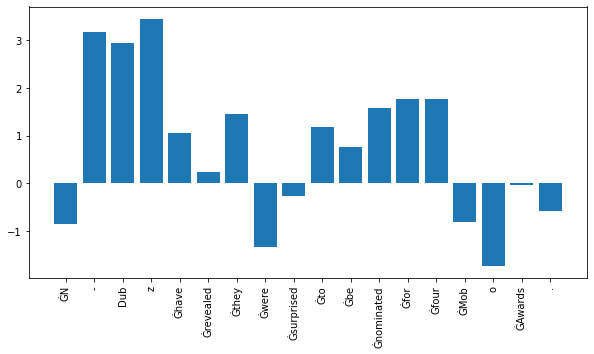

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



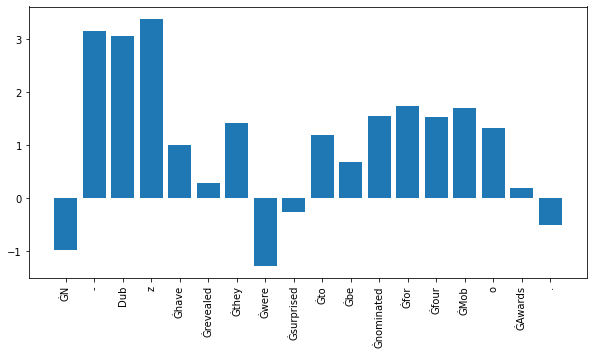

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



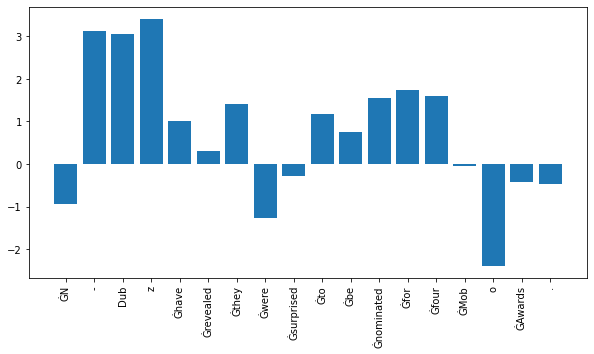

Interaction effect for index 693: [-0.03674 -0.00533 -0.02076 -0.01127 -0.02571 -0.00067 0.05674 -0.13669
 0.01934 -0.02079 -0.00953 -0.02602 0.01440 0.03247 -0.81631 -0.37840
 -0.02656 -0.11984]
Interaction effect for index 714: [0.09117 -0.01878 0.00422 0.03514 -0.04546 -0.04972 -0.02822 0.19023
 0.02656 0.01404 -0.11518 -0.01326 0.05821 -0.17078 0.81281 -2.04657
 -0.11680 0.03556]
Interaction effect for index 694: [0.12877 0.00027 -0.00247 -0.00655 -0.00624 0.06287 0.04314 -0.09878
 0.00895 0.04188 -0.01324 0.02963 0.01936 0.07948 -0.36263 -0.29375
 0.14477 0.01802]
Index in batch: 694
 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



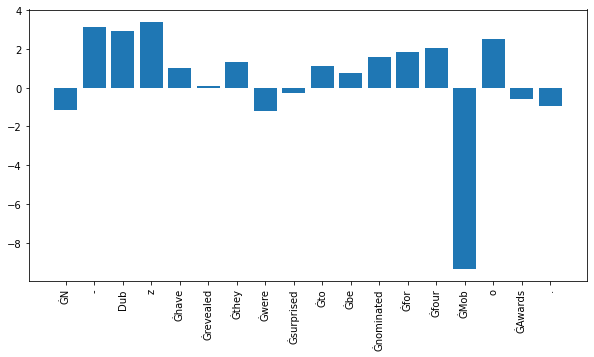

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



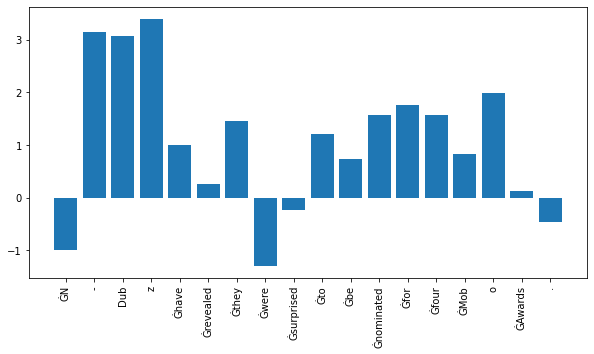

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



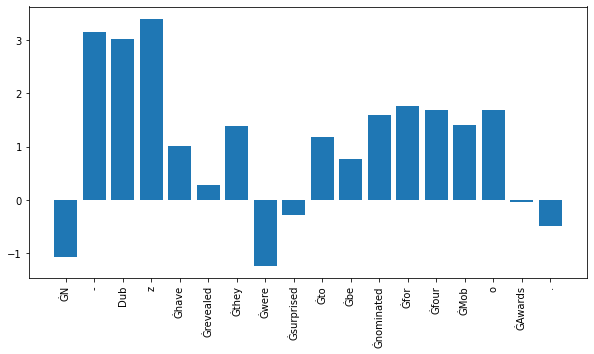

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



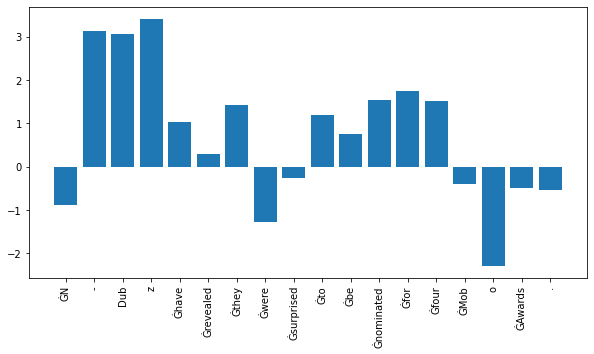

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



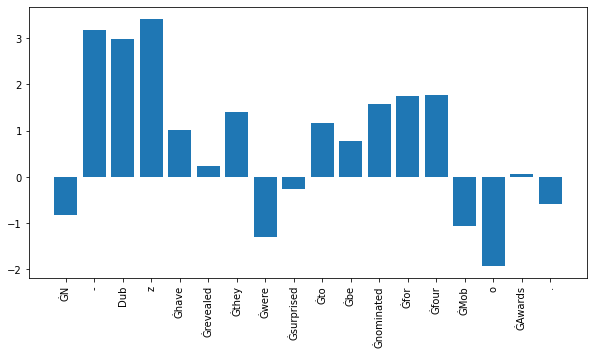

 Summary:   N-Dubz have revealed they were surprised to be nominated for four Mobo Awards. 



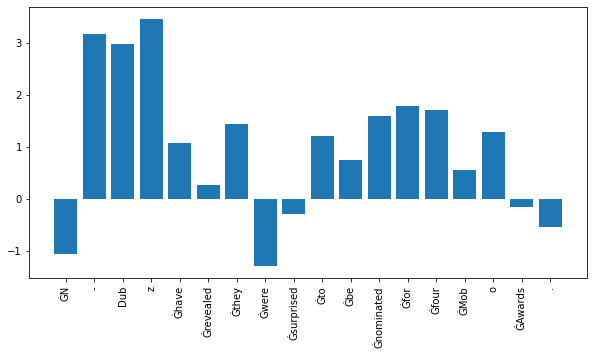

Partition explainer: 2it [01:27, 43.78s/it]                                                                            

Interaction effect for index 566: [0.06980 -0.02465 0.02985 0.00186 -0.00709 -0.00457 0.01352 0.05240
 0.01217 0.00373 -0.00084 0.01159 -0.00260 -0.06083 -0.57107 0.22928
 0.21639 0.12820]
Interaction effect for index 567: [0.02804 -0.00216 0.00394 -0.00285 -0.00199 0.00595 0.00962 -0.02773
 0.00775 -0.00079 0.00614 -0.00464 -0.00362 -0.02471 -0.22978 0.11706
 -0.07013 -0.04526]
Interaction effect for index 497: [0.02055 -0.00090 -0.01690 0.02826 0.00811 0.00277 0.00771 -0.04860
 -0.00503 0.01274 -0.01687 0.00243 -0.01672 0.08224 -0.98852 -0.60157
 0.00360 -0.07178]


In [51]:
shap_values_attn = explainer_attn(dataset['document'][0:1])

In [19]:
def summarize(x,model,tokenizer,attention_mask=None):
    inputs = tokenizer([x], max_length=1024, return_tensors='pt')
    input_ids=inputs['input_ids'].cuda()
    if attention_mask is not None:
        print(f'Masked input with attention mask: {tokenizer.decode(input_ids[attention_mask])}')
        summary_ids = model.generate(input_ids,attention_mask=attention_mask)
        decoder_inputs=gen_summary(x)['decoder_inputs']
        conditional_logits = cal_conditional_logits(input_ids,model,tokenizer,decoder_inputs,attention_mask=attention_mask)
    else:
        print(f'Masked input without attention mask: {tokenizer.decode(input_ids[0])}')
        summary_ids = model.generate(input_ids).detach().cpu().numpy()
    del input_ids
    summary=[tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    print(f"summary: {summary[0]}")
    return summary_ids[0,1:-1]

In [20]:
ids=summarize(dataset['document'][10],model,tokenizer)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Masked input without attention mask: <s>Researchers found that large rodents quickly ate the nuts, rather than caching them, when supplies were scarce.When supplies were plentiful, almost twice as many nuts were buried, increasing the chance of successful germination, the team added.The findings appear in the Journal of Tropical Ecology.The scientists from Norway, Brazil and the UK said that very little was know about the fate of Brazil nuts under natural condition, despite it being one of the most economically important non-timber crops to come out of Amazonia.In order to get a better understanding of how the seeds were dispersed, they tracked 1,800 marked seeds to see how seasonal food availability affected agoutis' and acouchis' - large scatter-hoarding rodents - caching rates, dispersal distances and how long the seeds were buried before being eaten."We basically found that the seasons had a very strong effect on the dispersal distances and what happened to the seeds themselves," e

In [21]:
tokenizer.convert_ids_to_tokens(int(ids[1]))

'Ġstudy'

In [25]:
shap.plots.text(shap_values[0][:,1],group_threshold=1)

In [24]:
shap.plots.text(shap_values1[0][:,1],group_threshold=1)

NameError: name 'shap_values1' is not defined

In [19]:
shap.plots.text(shap_values[0][:,8],group_threshold=1)

In [31]:
shap.plots.text(shap_values[0][:,11],group_threshold=1)

In [44]:
shap.plots.text(shap_values[0][:,8],group_threshold=1)

In [52]:
shap.plots.text(shap_values_attn[0][:,11],group_threshold=1)

In [25]:
def get_encoder_outputs(input_ids,model,attention_mask):
    encoder = model.get_encoder()
    with torch.no_grad():
        encoder_outputs = encoder(input_ids, attention_mask=attention_mask, return_dict=True)
    del encoder
    return encoder_outputs

def get_conditional_logits(model, decoder_input, past, attention_mask, encoder_outputs):
    model_inputs = model.prepare_inputs_for_generation(
                    decoder_input, past=past, attention_mask=attention_mask, use_cache=True, encoder_outputs=encoder_outputs
                )
    with torch.no_grad():
        outputs = model(**model_inputs, return_dict=True)
    if "past_key_values" in outputs:
        past = outputs.past_key_values
    next_token_logits = outputs.logits[:, -1, :].detach().cpu()
    probs=next_token_logits[0].softmax(dim=0)
    del model_inputs, outputs
    #probs = sp.special.logit(probs)
    return probs, past

def cal_conditional_logits(input_ids,model,tokenizer,decoder_inputs,encoder_outputs=None,attention_mask=None):
    conditional_logits=[]
    past=None
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    input_ids=input_ids.to(device)
    if attention_mask is None:
        attention_mask = (input_ids!=tokenizer.pad_token_id).type(torch.int64)
    else:
        attention_mask = attention_mask.to(device)
    summary_ids = model.generate(input_ids)
    summary=[tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    del summary_ids
    print(f"\033[1m Summary: \033[0m {summary[0]} \n")
    if encoder_outputs is None:
        encoder_outputs = get_encoder_outputs(input_ids,model,attention_mask)
    del input_ids
    for i in range(1,decoder_inputs.shape[1]):
        probs, past = get_conditional_logits(model, decoder_inputs[:,:i], past, attention_mask, encoder_outputs)
        conditional_logits.append(probs[decoder_inputs[0,i].item()])
    del past, attention_mask, encoder_outputs
    
    token_ids=tokenizer.convert_ids_to_tokens(decoder_inputs[0,1:].detach().cpu().numpy())
    mlp.rcParams['figure.figsize']=(10,5)
    plt.bar(token_ids,conditional_logits)
    plt.xticks(rotation=90)
    plt.show()
    
    return np.array(conditional_logits)

In [23]:
explainer = shap.Explainer(f_cp,tokenizer,model_kwargs=f_kwargs)
explainer.masker.mask_token=None
explainer.masker.mask_token_str=""
explainer.masker.fixed_background = True
row_args=(dataset['document'][150],)
fm = MaskedModel(explainer.model, explainer.model_kwargs, explainer.masker, explainer.link,*row_args)
explainer._clustering = explainer.masker.clustering(*row_args)
explainer._mask_matrix = make_masks(explainer._clustering)

explainers.Partition is still in an alpha state, so use with caution...
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Keyword arguments {'min_length': 0} not recognized.


In [24]:
mask_dict={}
def masking_experiment(clust_index,d,d_limit,feature_names,M):
    if d>d_limit:
        return
    #print(f'clust_index:{clust_index}')
    m00 = np.zeros(M, dtype=np.bool)
    m_new=m00.copy()
    mask_index=clust_index+M
    #print(f'mask_index:{mask_index}')
    m_new[:]+=explainer._mask_matrix[mask_index,:]
    batch_masks=[]
    batch_masks.append(m_new)
    batch_masks=np.array(batch_masks)
    fout = fm(batch_masks)
    mask_dict[' '.join(feature_names[m_new])]=m_new
    #print(f'Masked string: {feature_names[m_new]}')
    lind,rind=[int(x) for x in explainer._clustering[clust_index,:2]]
    #print(f'lind:{lind} rind:{rind}')
    masking_experiment(lind-M if lind>=M else lind,d+1,d_limit,feature_names,M)
    masking_experiment(rind-M if rind>=M else rind,d+1,d_limit,feature_names,M)

In [25]:
def reference_evaluation(M):
    m00 = np.zeros(M, dtype=np.bool)
    batch_masks=[]
    batch_masks.append(m00)
    batch_masks=np.array(batch_masks)
    fout = fm(batch_masks)

In [26]:
feature_names = [explainer.masker.tokenizer.decode([v]) for v in explainer.masker._tokenized_s]

 Masked input:  
 Summary:  Questions are still being asked on social media about the impact of the EU referendum. 



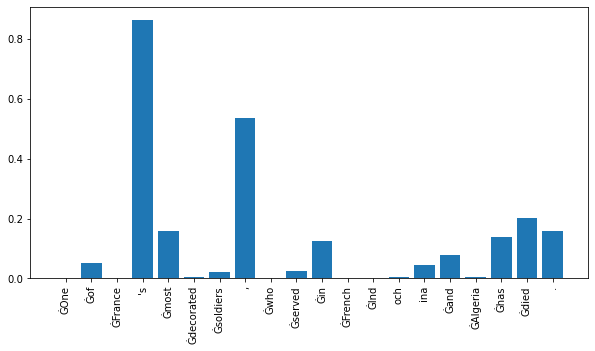

 Masked input:  Gen Marcel Bigeard, 94, died on Friday, his wife told news agency Agence France-Presse.Gen Bigeard was a commanding officer during the battle of Dien Bien Phu and the Battle of Algiers.In 2000 he caused controversy in France by telling a newspaper that torture was a "necessary evil" in Algeria.Gen Bigeard began his military career as an enlisted man, and retired from the army as State Secretary for Defence.He was called up into the army at the outbreak of World War II and was captured in the Battle of France in 1940.He managed to escape and joined the Free French in North Africa. From there he was parachuted back in to France to fight with the Resistance.It was in French Indochina that Gen Bigeard began to make his name as a commander in a Paratroop regiment.He survived the 1954 Battle of Dien Bien Phu, where French troops were surrounded and defeated by the forces of the Vietnamese Communists, the Viet Minh.He was then sent to Algeria where he led the "irregular" count

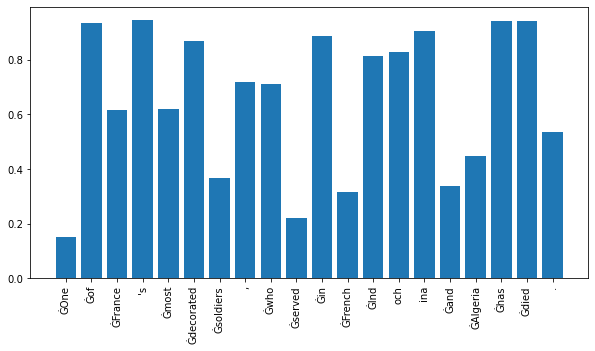

 Masked input:  Gen Marcel Bigeard, 94, died on Friday, his wife told news agency Agence France-Presse.Gen Bigeard was a commanding officer during the battle of Dien Bien Phu and the Battle of Algiers.In 2000 he caused controversy in France by telling a newspaper that torture was a "necessary evil" in Algeria.Gen Bigeard began his military career as an enlisted man, and retired from the army as State Secretary for Defence.He was called up into the army at the outbreak of World War II and was captured in the Battle of France in 1940.He managed to escape and joined the Free French in North Africa. From there he was parachuted back in to France to fight with the Resistance.It was in French Indochina that Gen Bigeard began to make his name as a commander in a Paratroop regiment.He survived the 1954 Battle of Dien Bien Phu, where French troops were surrounded and defeated by the forces of the Vietnamese Communists, the Viet Minh.He was then sent to Algeria where he led the "irregular" count

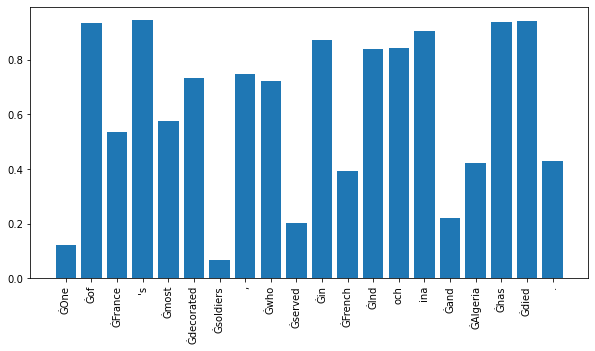

 Masked input:  Gen Marcel Bigeard, 94, died on Friday, his wife told news agency Agence France-Presse.Gen Bigeard was a commanding officer during the battle of Dien Bien Phu and the Battle of Algiers.In 2000 he caused controversy in France by telling a newspaper that torture was a "necessary evil" in Algeria.Gen Bigeard began his military career as an enlisted man, and retired from the army as State Secretary for Defence.
 Summary:   A former French general who served in Vietnam and Algeria during World War Two has died. 



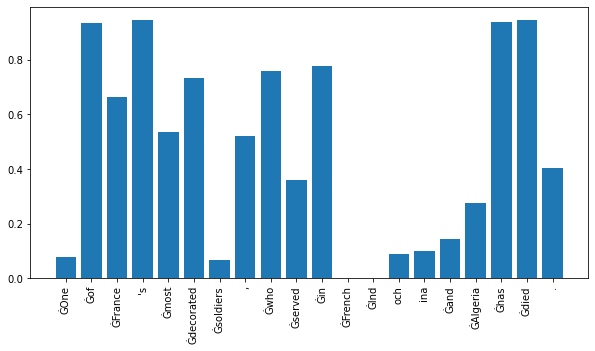

 Masked input:  Gen Marcel Bigeard, 94, died on Friday, his wife told news agency Agence France-Presse.Gen Bigeard was a commanding officer during the battle of Dien Bien Phu and the Battle of Algiers.
 Summary:   A French general who served in Vietnam during World War Two has died, his wife has said. 



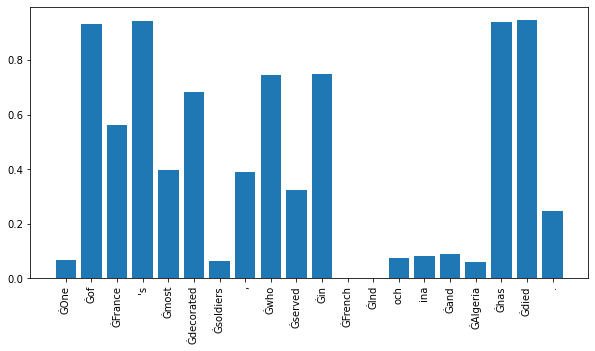

 Masked input:  Gen Marcel Bigeard, 94, died on Friday, his wife told news agency Agence France-Presse.
 Summary:   The former head of the French army has died, his family has said. 



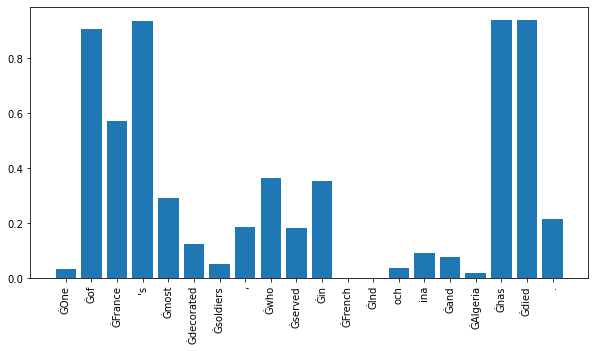

 Masked input:  Gen Marcel Bigeard, 94, died on Friday,
 Summary:   The former head of the French army has died, his family has confirmed. 



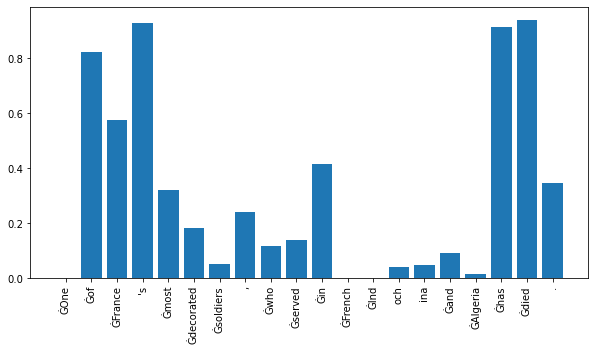

 Masked input:  Gen Marcel Bigeard,
 Summary:   The BBC News website looks at some of the key figures from the French armed forces. 



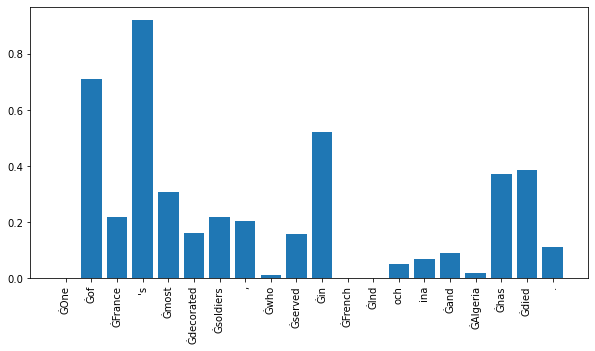

 Masked input:  Gen Marcel Big
 Summary:  Germany's military says it will not be sending any more troops to the Middle East. 



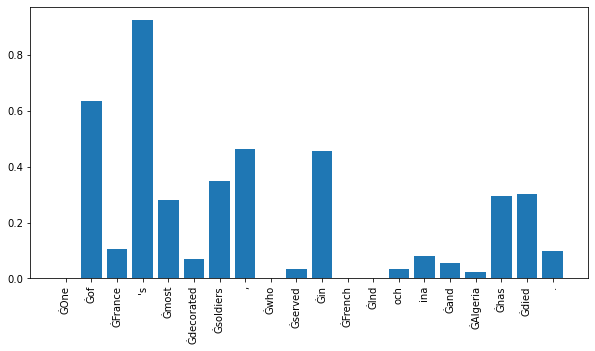

 Masked input:  eard,
 Summary:   The BBC News website looks at some of the most eye-catching stories of the week. 



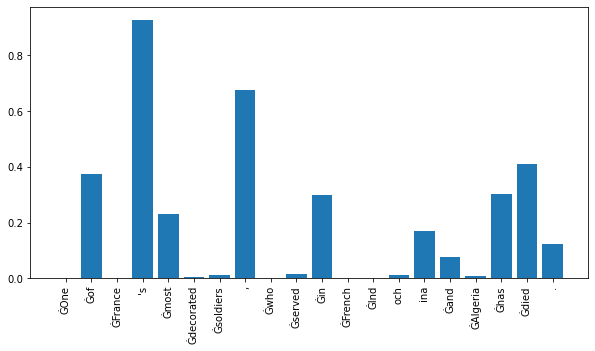

 Masked input:   94, died on Friday,
 Summary:  Tributes have been paid to the former president of the United States, George HW Bush, who has died. 



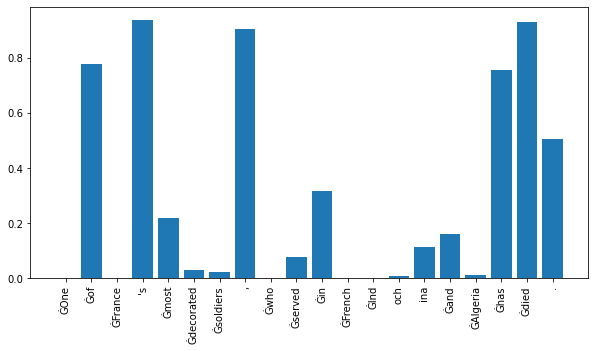

 Masked input:   94,
 Summary:   The BBC News website looks back at some of the most eye-catching stories of the past 12 months. 



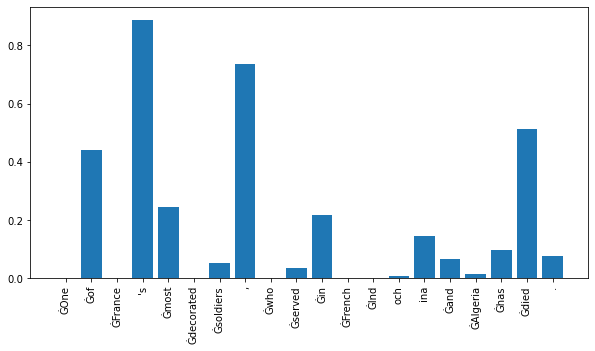

 Masked input:   died on Friday,
 Summary:  Tributes have been paid to the late Australian singer, singer, actor and broadcaster Bob Dylan. 



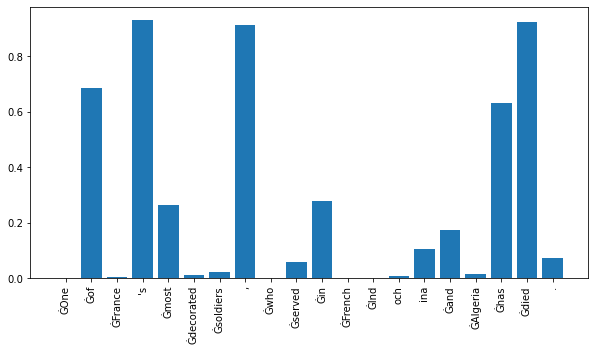

 Masked input:   his wife told news agency Agence France-Presse.
 Summary:  French Prime Minister Manuel Valls has died of a heart attack at a hospital in Paris, his family has said. 



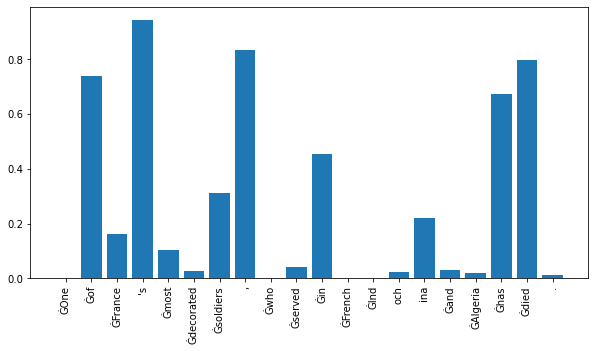

 Masked input:   his wife told news agency Agence France
 Summary:  French President Francois Hollande has been killed in a car crash in the south of the country, officials say. 



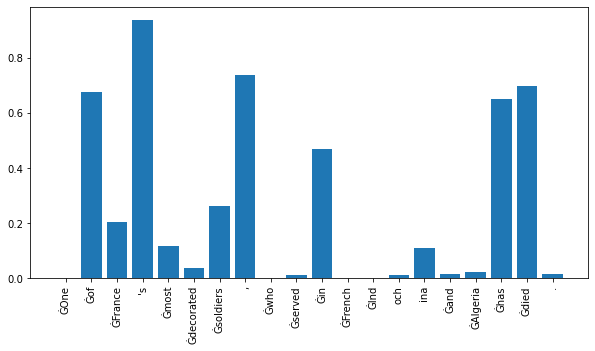

 Masked input:   his wife told news
 Summary:   A man has died in hospital after suffering a heart attack, his family has confirmed to the BBC. 



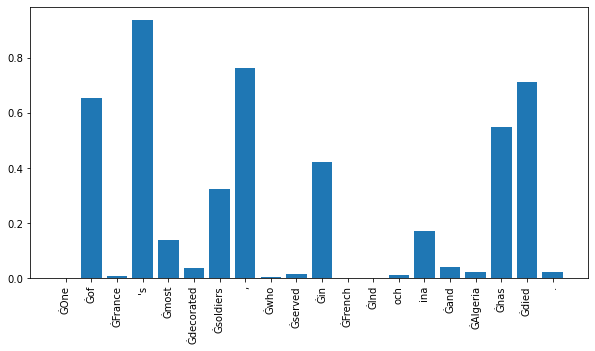

 Masked input:   agency Agence France
 Summary:  France's President Francois Hollande has said the French government will take the necessary measures to prevent the spread of terror in the country. 



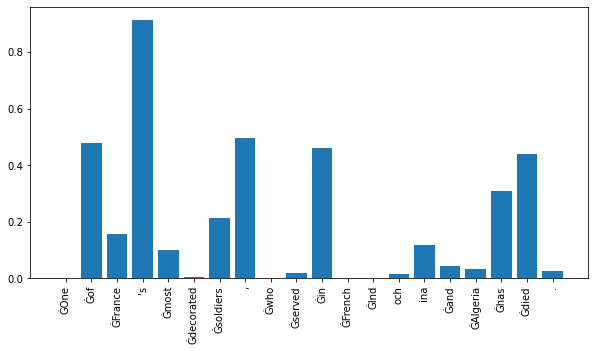

 Masked input:  -Presse.
 Summary:   The BBC News website looks at some of the key stories from the past week. 



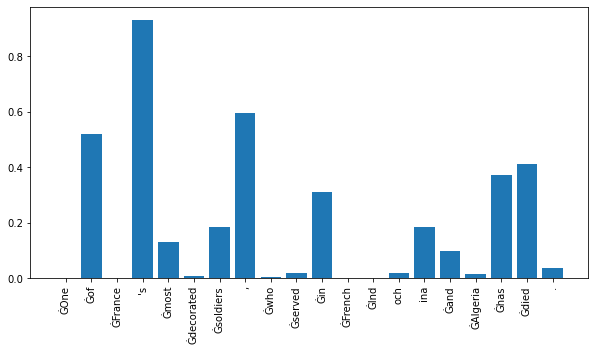

 Masked input:  -Presse
 Summary:  All photographs courtesy of AFP, EPA, Getty Images and Reuters 



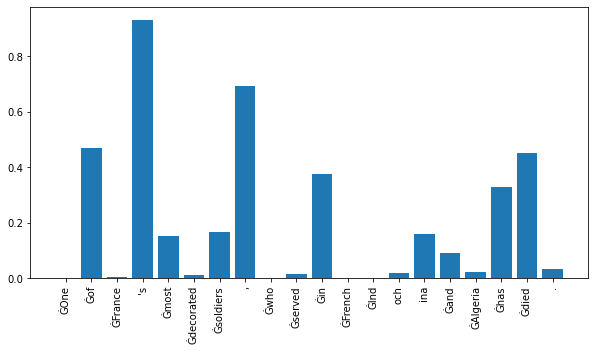

 Masked input:   controversy in
 Summary:   The BBC News website looks at some of the most eye-catching stories of the past week. 



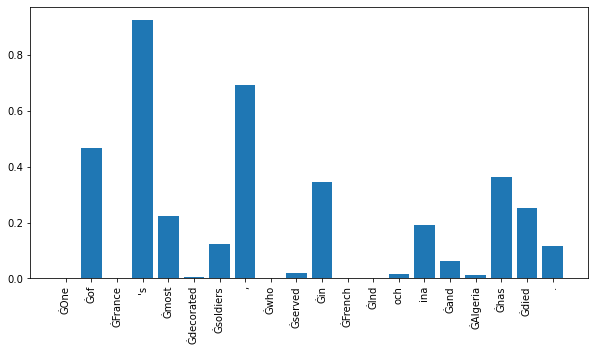

 Masked input:  Gen Bigeard was a commanding officer during the battle of Dien Bien Phu and the Battle of Algiers.
 Summary:  French general Charles Bigeard was one of the most decorated generals of World War Two. 



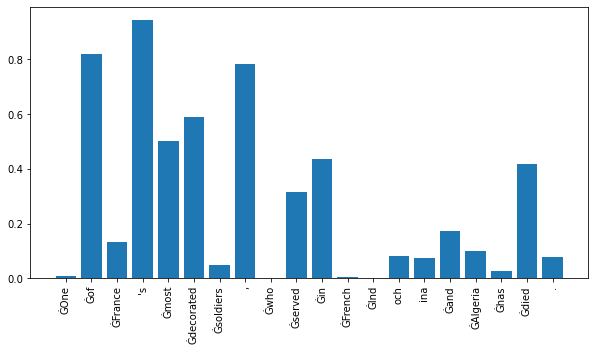

 Masked input:  Gen Bigeard was a commanding officer during the battle of Dien Bien
 Summary:  French general Charles Bigeard, who served in the French army during World War Two, died at the age of 93. 



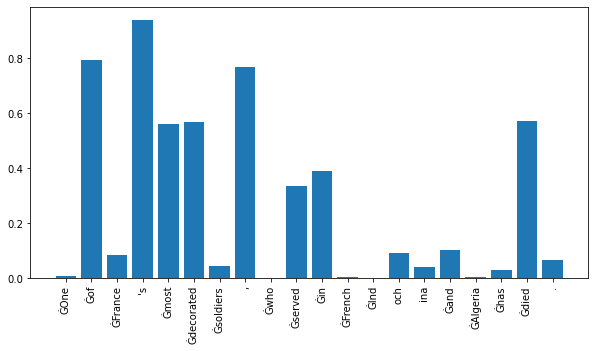

 Masked input:  Gen Bigeard was a commanding officer
 Summary:   The former head of the Irish Army, Sir John Bigeard, has died. 



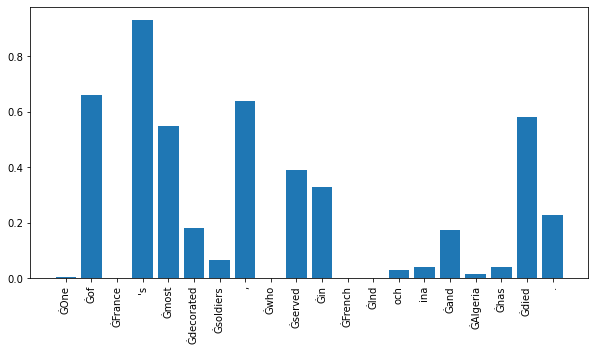

 Masked input:  Gen Bigeard
 Summary:  Northern Ireland's most senior military officer, Gen David Bigeard, has died at the age of 74. 



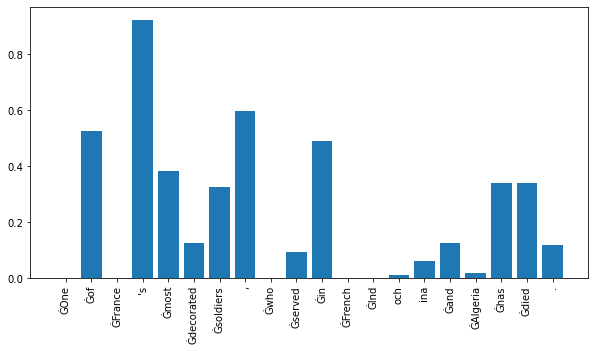

 Masked input:   was a commanding officer
 Summary:   The Duke of Cambridge has died at the age of 91. 



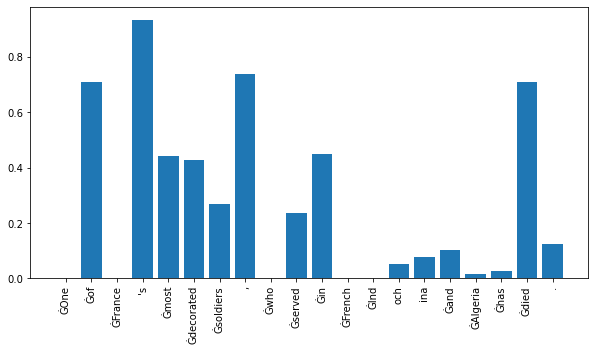

 Masked input:   during the battle of Dien Bien
 Summary:  During the Battle of the Somme, World War Two, the French army and French troops were fighting each other for the first time. 



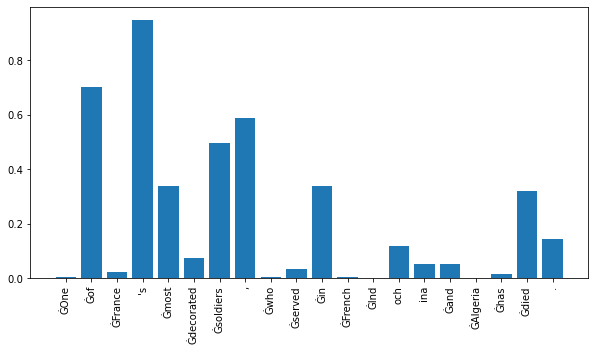

 Masked input:   during the battle of
 Summary:   The Battle of the Somme was fought between the British and French armies. 



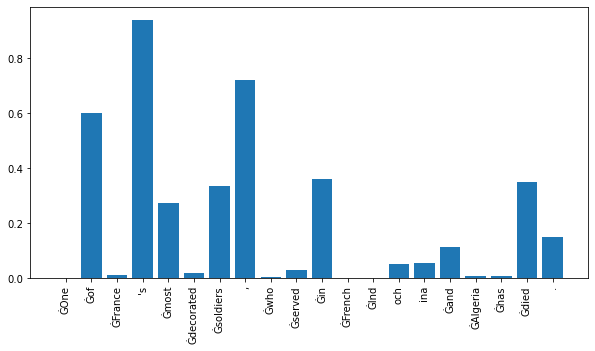

 Masked input:   Dien Bien
 Summary:   Dien Bien, or Dien Dien, is one of the world's best-selling restaurants. 



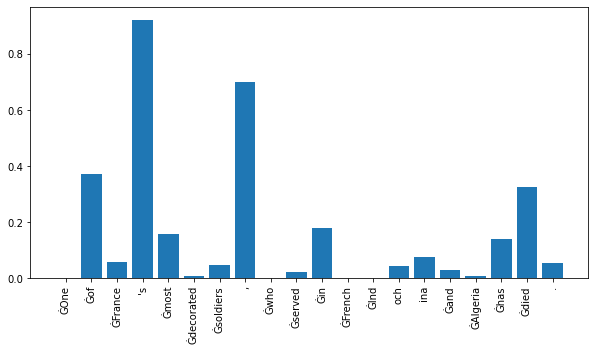

 Masked input:   Phu and the Battle of Algiers.
 Summary:   The Battle of Phu and the Battle of Algiers are remembered as part of a series of historical events. 



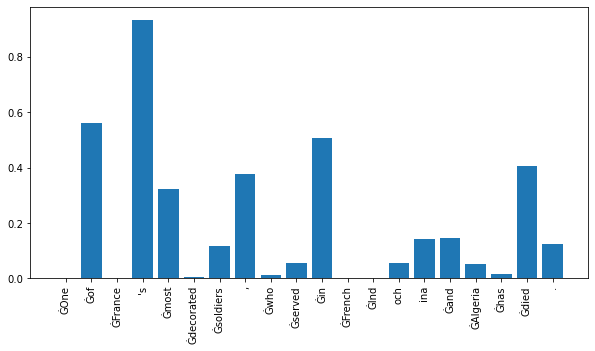

 Masked input:   Phu and the
 Summary:   Phu Phu is one of the world's best-loved and most famous people. 



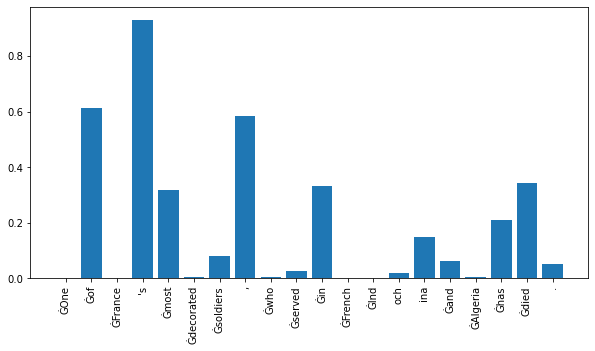

 Masked input:   Phu
 Summary:   Phu Phu is one of the most popular names on social media. 



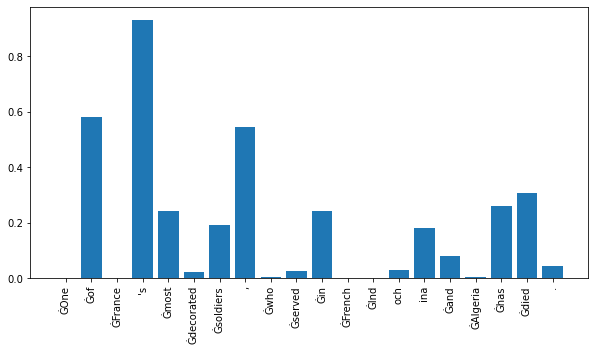

 Masked input:   and the
 Summary:   The BBC News website looks at some of the best stories of the past 12 months. 



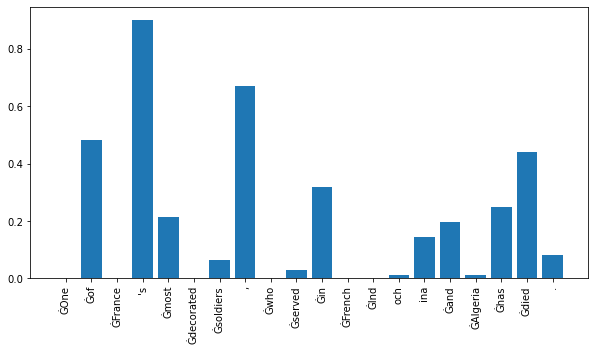

 Masked input:   Battle of Algiers.
 Summary:  World War Two: The Battle of Algiers. 



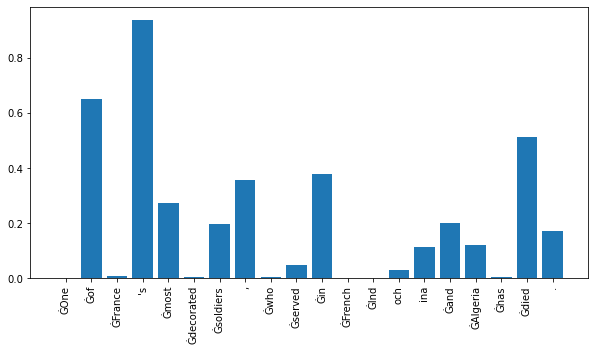

 Masked input:   Battle of Algiers
 Summary:   The Battle of Algiers is remembered as one of the bloodiest battles of World War Two. 



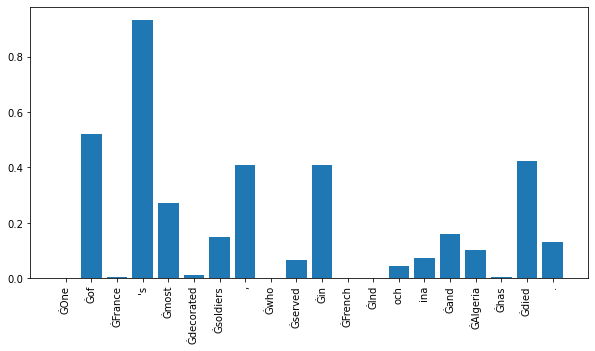

 Masked input:   and was
 Summary:   The Queen has died at the age of 90. 



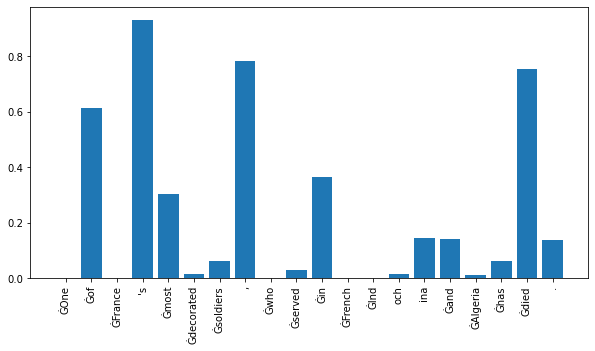

 Masked input:  In 2000 he caused controversy in France by telling a newspaper that torture was a "necessary evil" in Algeria.Gen Bigeard began his military career as an enlisted man, and retired from the army as State Secretary for Defence.
 Summary:  Former French Defence Minister Jean Bigeard has died at the age of 82. 



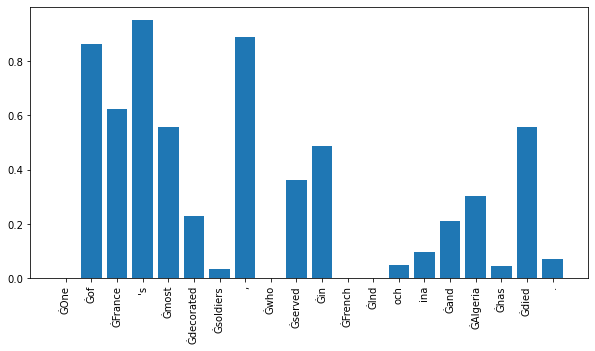

 Masked input:  In 2000 he caused controversy in France by telling a newspaper that torture was a "necessary evil" in Algeria.
 Summary:   Former Algerian Prime Minister Abdel Fattah al-Sisi has died at the age of 82. 



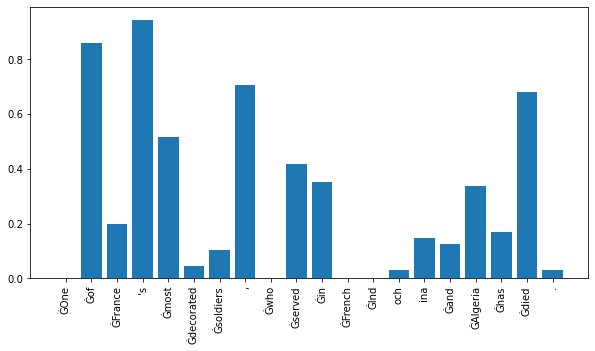

 Masked input:  In 2000 he caused controversy in France by
 Summary:  Former French Prime Minister Charles De Gaulle has died at the age of 67. 



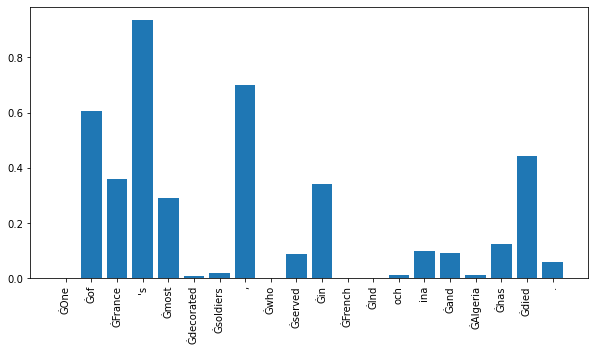

 Masked input:  In 2000 he caused
 Summary:   The BBC News website looks back at some of the biggest stories of the past 12 months. 



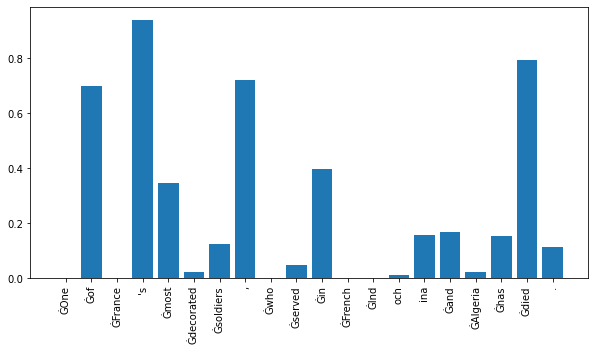

 Masked input:  In 2000
 Summary:   Inverness is one of the most famous towns in the world. 



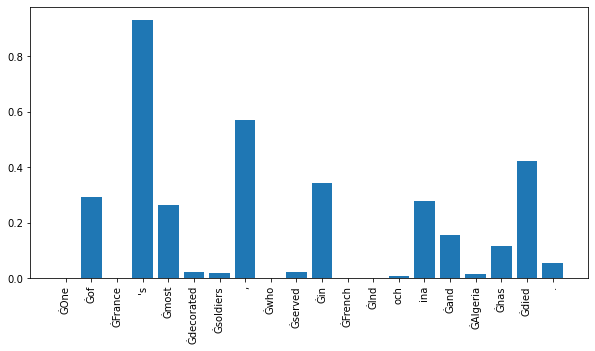

 Masked input:   he caused
 Summary:  Former British Prime Minister David Cameron has announced he will not stand for re-election. 



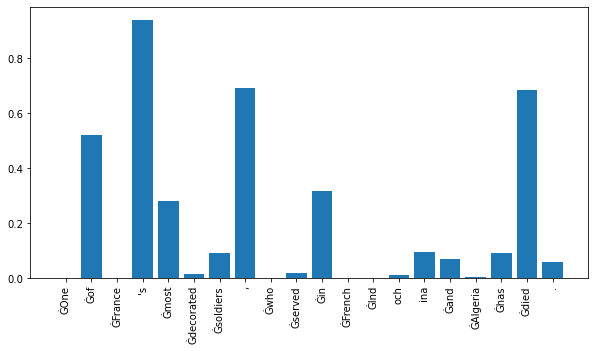

 Masked input:   controversy in France by
 Summary:  French President Nicolas Sarkozy has been forced to apologise to the French government over his comments on the Paris metro. 



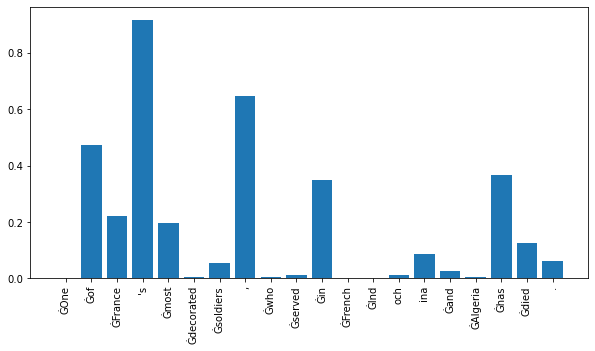

 Masked input:   controversy in
 Summary:   The BBC News website looks at some of the most eye-catching stories of the past week. 



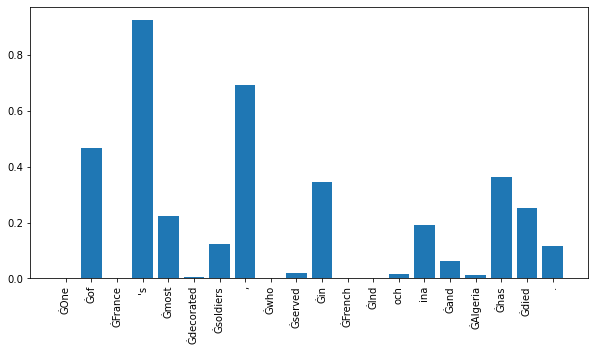

 Masked input:   France by
 Summary:  French President Nicolas Sarkozy has called for the French government to be given more powers over the country. 



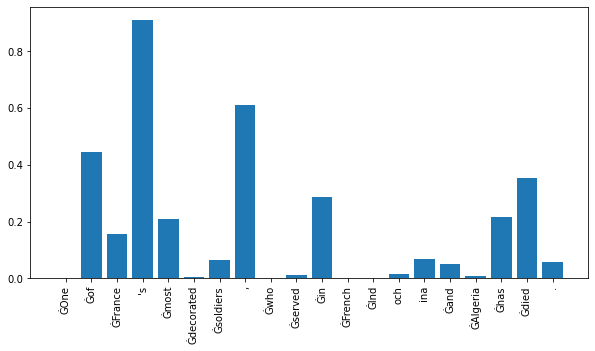

 Masked input:   telling a newspaper that torture was a "necessary evil" in Algeria.
 Summary:   Algeria's President Abdel Fattah al-Abidine Ben Ali has defended the use of torture. 



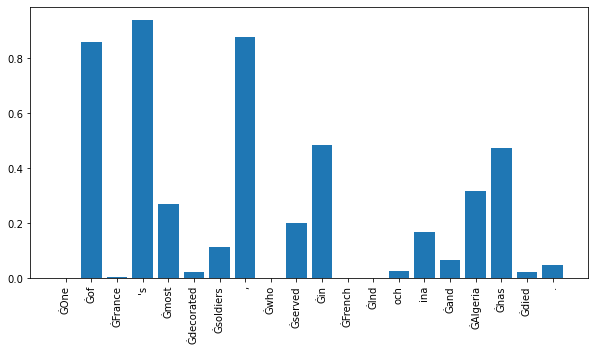

 Masked input:   telling a newspaper that torture was a "
 Summary:  North Korea's President Kim Jong-un has described the use of torture as "a war against humanity". 



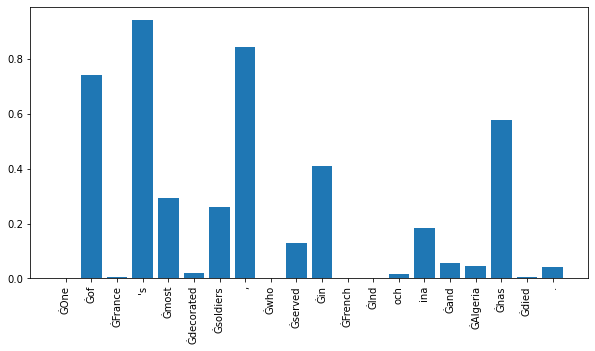

 Masked input:   telling a newspaper that
 Summary:  South Africa's President, Omar al-Bashir, has announced that he will step down from his post. 



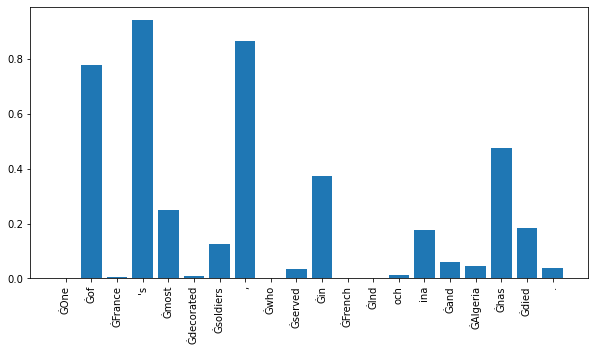

 Masked input:   torture was a "
 Summary:   "Torture is not a new form of torture," US President Barack Obama has said. 



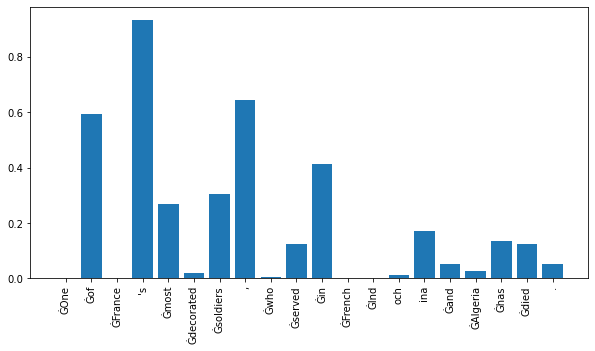

 Masked input:  necessary evil" in Algeria.
 Summary:   The BBC News website looks at some of the most controversial stories in Algeria. 



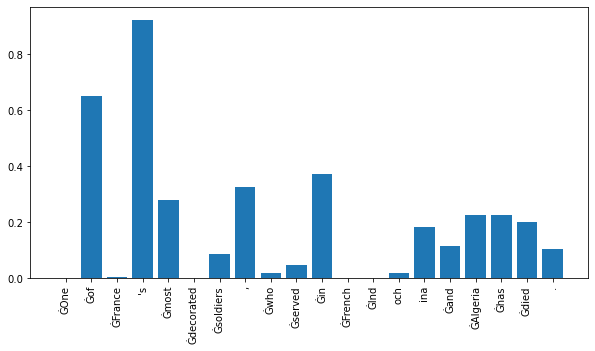

 Masked input:  necessary evil" in Algeria
 Summary:   Algeria's President, Abdel Fattah al-Abidine al-Khalifa, has been accused of being a "terrorist". 



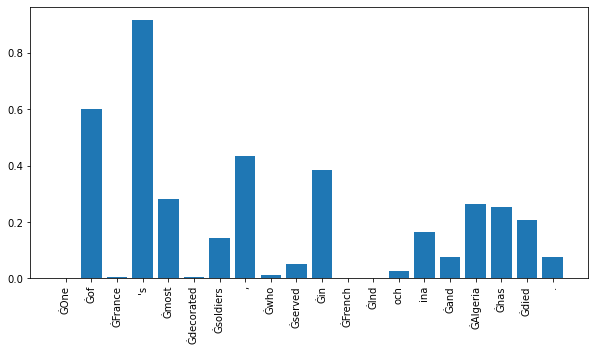

 Masked input:   Gen Big
 Summary:   A look back at some of the biggest stories of the past 12 months. 



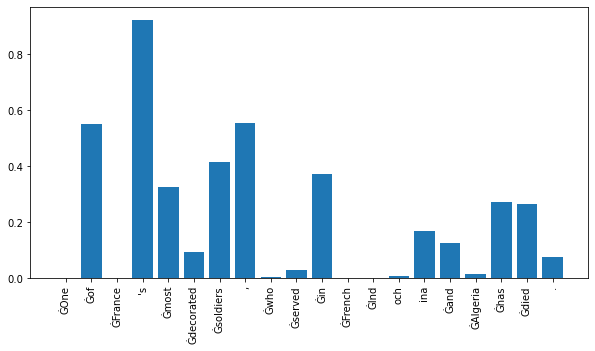

 Masked input:  Gen Bigeard began his military career as an enlisted man, and retired from the army as State Secretary for Defence.
 Summary:   The former head of the Army in Northern Ireland, Sir John Bigeard, has been appointed as the new Chief of the Defence Staff. 



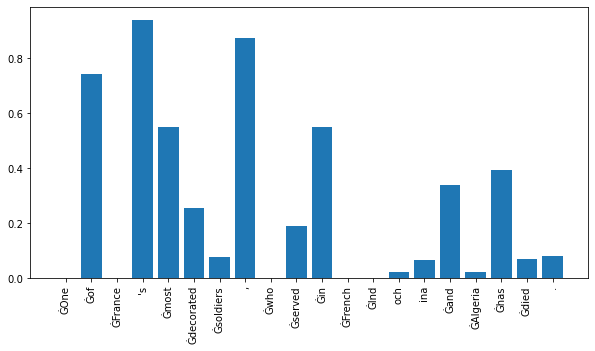

 Masked input:  Gen Bigeard began his military career as an enlisted man,
 Summary:   The Chief of the General Staff of the Army, Sir David Bigeard, has been appointed to the post of Lord Chief Constable of the British Army. 



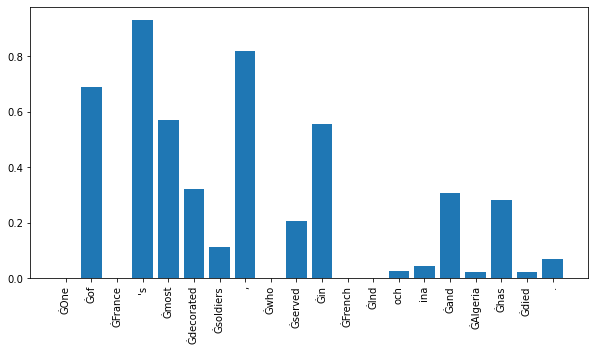

 Masked input:  Gen Bigeard began his military career
 Summary:   The Chief of the General Staff of the British Army, Sir David Bigeard, has retired from the Army. 



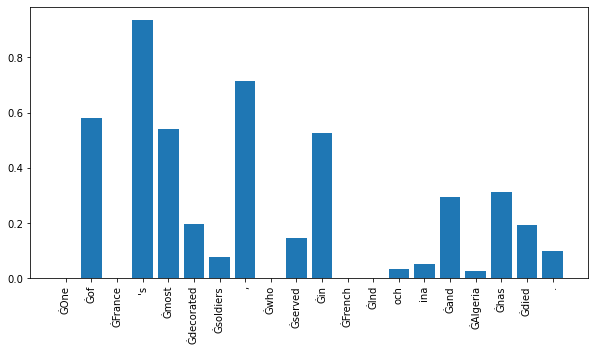

 Masked input:  Gen Bigeard
 Summary:  Northern Ireland's most senior military officer, Gen David Bigeard, has died at the age of 74. 



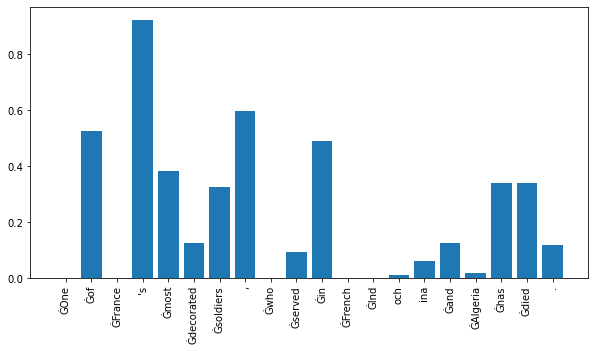

 Masked input:   began his military career
 Summary:   Former British Prime Minister David Cameron has announced his retirement from the armed forces. 



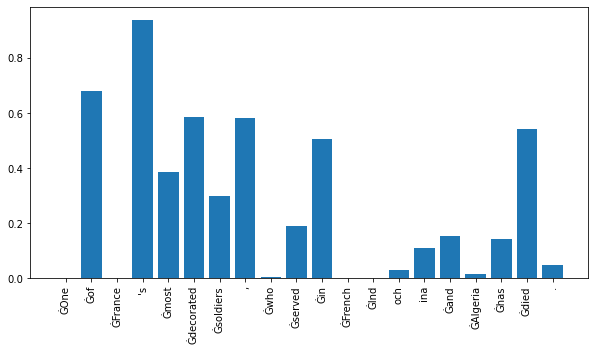

 Masked input:   as an enlisted man,
 Summary:   As the British Army prepares for World War Two, BBC News takes a look back at some of the most memorable moments of the conflict. 



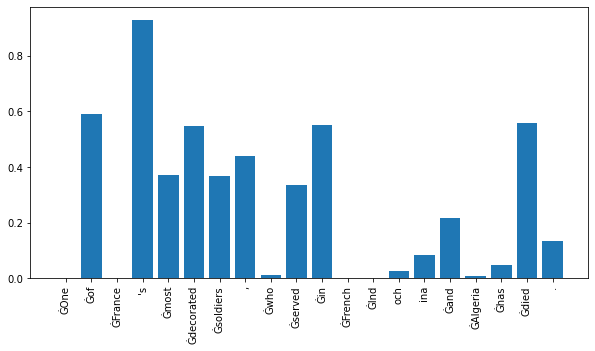

 Masked input:   as an enlisted man
 Summary:  As he served in the Royal Navy, the Royal Electrical and Mechanical Engineers (RAE) and Royal Navy (RSE) were also involved in a series of operations in the British Isles. 



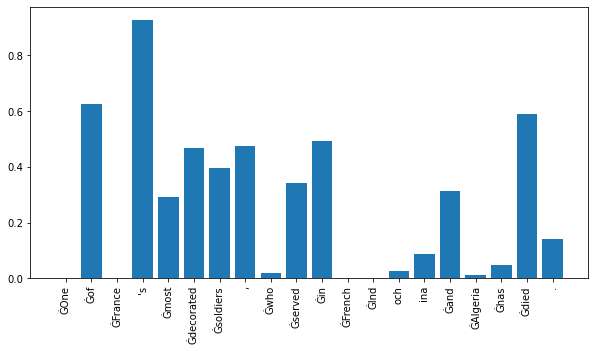

 Masked input:   Bien
 Summary:  French President Charles De Gaulle has announced that his country will be taking part in the European Championships. 



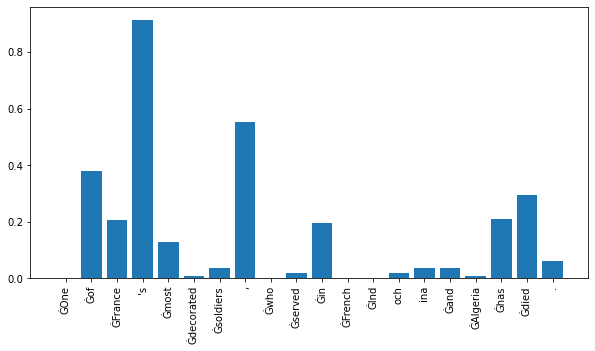

 Masked input:   and retired from the army as State Secretary for Defence.
 Summary:   The former leader of the Ulster Unionist Party, Ian Paisley, has died at the age of 74. 



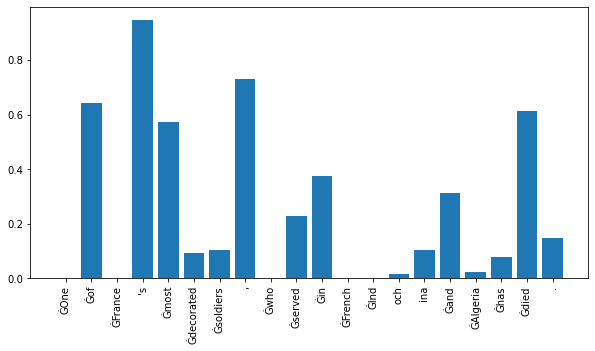

 Masked input:   and retired from the
 Summary:   The former president of the United States, Bill Clinton, has died at the age of 82. 



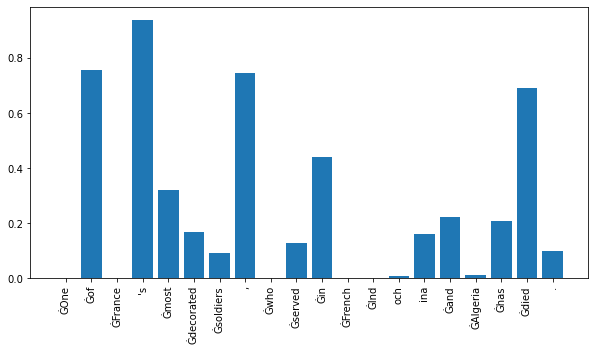

 Masked input:   and retired
 Summary:   The BBC News website looks at some of the best stories of the past 12 months. 



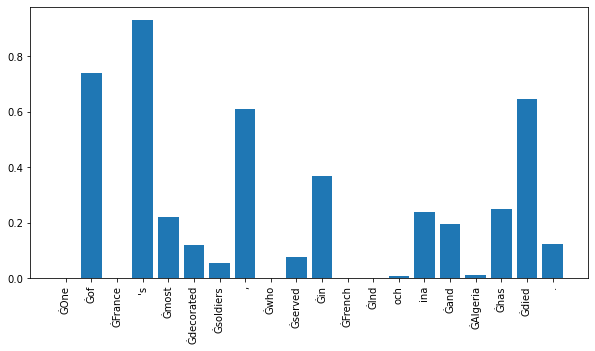

 Masked input:   from the
 Summary:   A look back at some of the top stories of the past 12 months. 



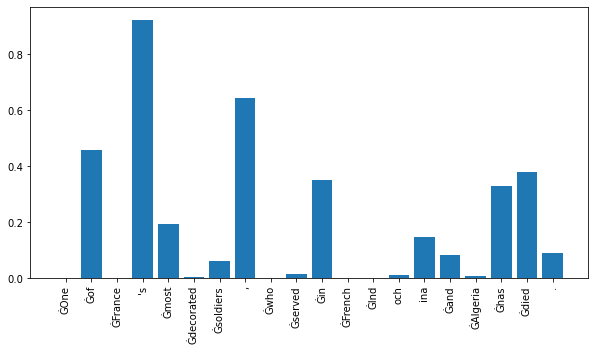

 Masked input:   army as State Secretary for Defence.
 Summary:  David Cameron has been appointed as the new head of the British army. 



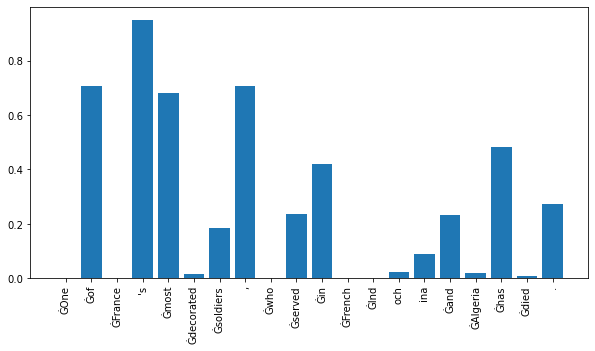

 Masked input:   army as State Secretary
 Summary:  Former US Secretary of State John Kerry has resigned from his post to take up a similar role with the British army. 



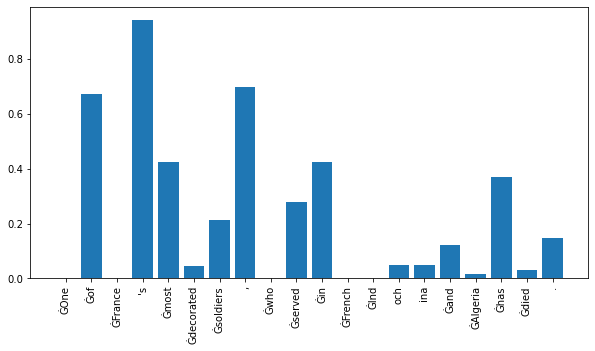

 Masked input:   for Defence.
 Summary:   The BBC News website looks at some of the key stories from the past 12 months. 



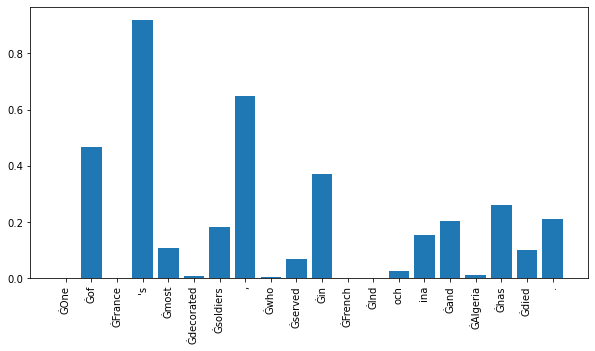

 Masked input:  He was called up into the army at the outbreak of World War II and was captured in the Battle of France in 1940.He managed to escape and joined the Free French in North Africa. From there he was parachuted back in to France to fight with the Resistance.It was in French Indochina that Gen Bigeard began to make his name as a commander in a Paratroop regiment.He survived the 1954 Battle of Dien Bien Phu, where French troops were surrounded and defeated by the forces of the Vietnamese Communists, the Viet Minh.He was then sent to Algeria where he led the "irregular" counter-insurgency campaign against the National Liberation Front (FLN)
 Summary:  French general Bernard Bigeard, who has died at the age of 93, was one of France's most decorated military commanders. 



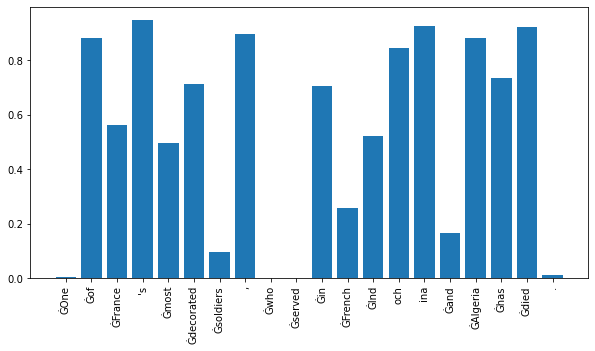

 Masked input:  He was called up into the army at the outbreak of World War II and was captured in the Battle of France in 1940.He managed to escape and joined the Free French in North Africa. From there he was parachuted back in to France to fight with the Resistance.
 Summary:   The Duke of Edinburgh has died at the age of 93. 



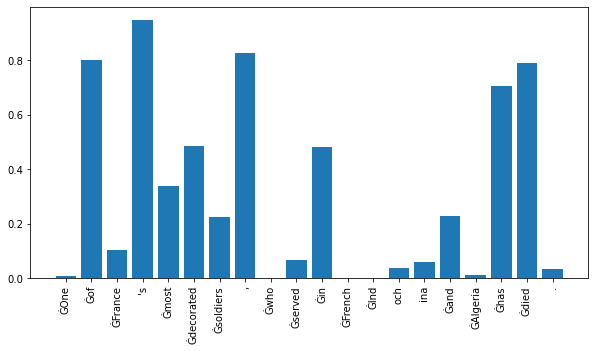

 Masked input:  He was called up into the army at the outbreak of World War II and was captured in the Battle of France in 1940.
 Summary:   The Duke of Cambridge has died at the age of 91. 



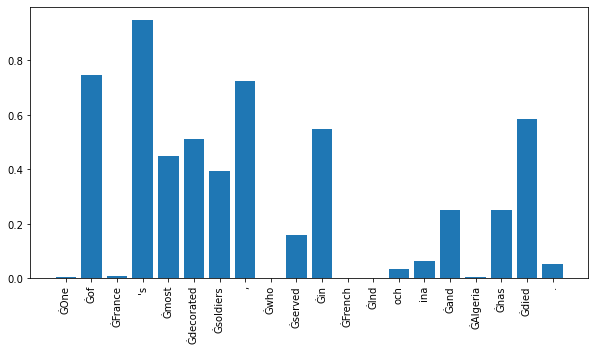

 Masked input:  He was called up into the army at the outbreak of World War II and was
 Summary:   The Duke of Cambridge has died at the age of 91. 



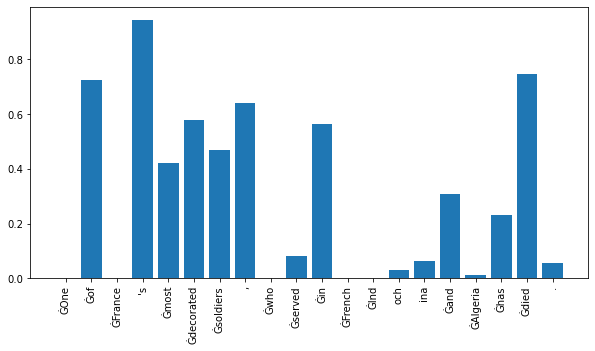

 Masked input:  He was called up into the army at
 Summary:   The BBC News website looks at the life and times of the soldier who served in the British Army during the Second World War. 



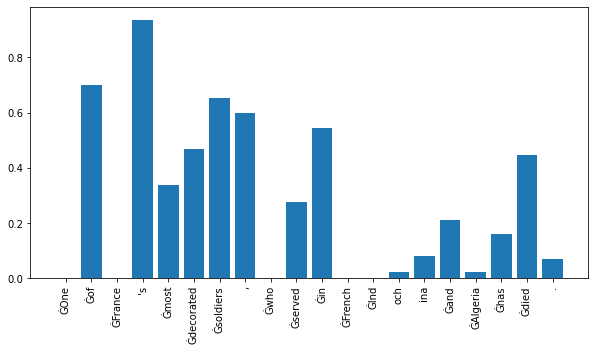

 Masked input:  He was called up
 Summary:  England Under-21s captain Sam Allardyce has been called up to the England Under-20 squad for the World Cup. 



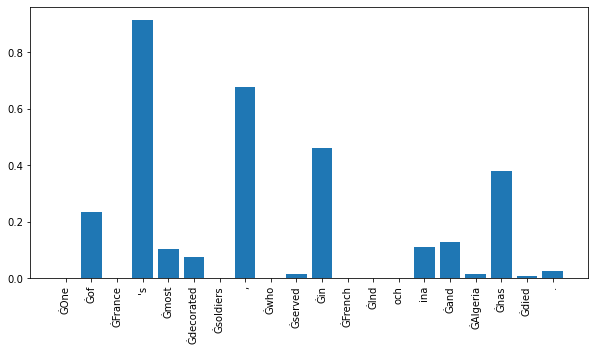

 Masked input:   into the army at
 Summary:  All photographs courtesy of the Ministry of Defence (MoD) 



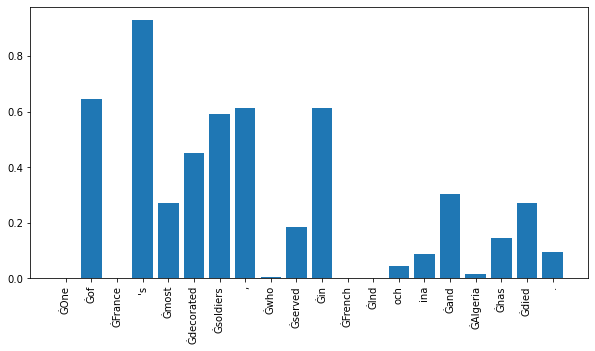

 Masked input:   the outbreak of World War II and was
 Summary:   The Duke of Cambridge was the first British prime minister to be elected. 



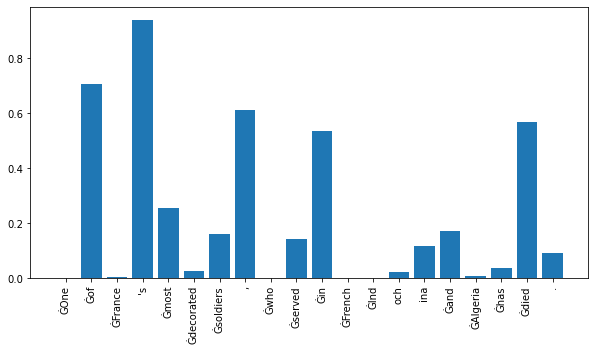

 Masked input:   the outbreak of World
 Summary:   The BBC News website looks back at some of the key stories of the past 12 months. 



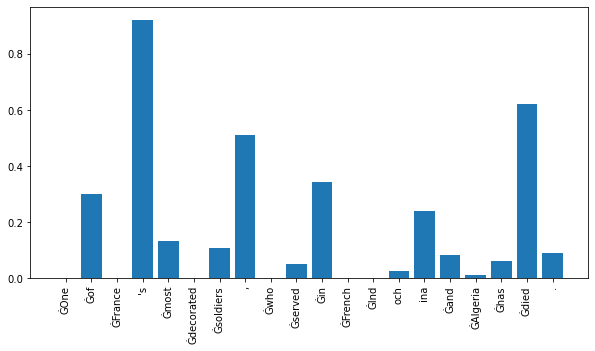

 Masked input:   War II and was
 Summary:  Former British Prime Minister Winston Churchill has died at the age of 91. 



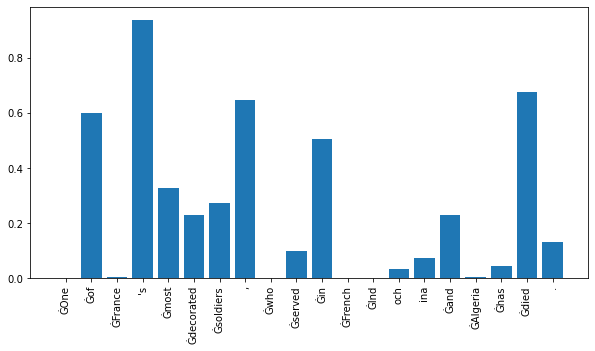

 Masked input:   captured in the Battle of France in 1940.
 Summary:  World War Two photos courtesy of AFP, EPA, Getty Images and Reuters 



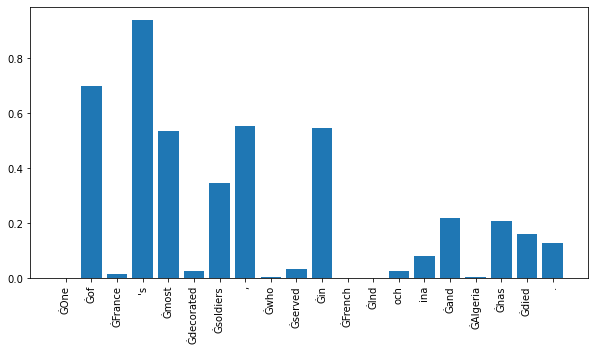

 Masked input:   captured in the Battle
 Summary:   The Battle of the Somme is remembered as one of the most important battles in British history. 



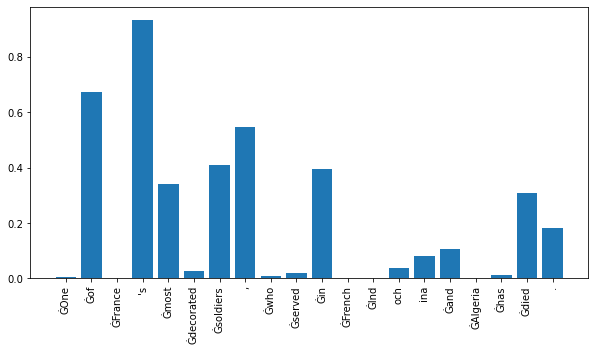

 Masked input:   captured in
 Summary:  This is the story of a man who was killed in a gun attack in Afghanistan. 



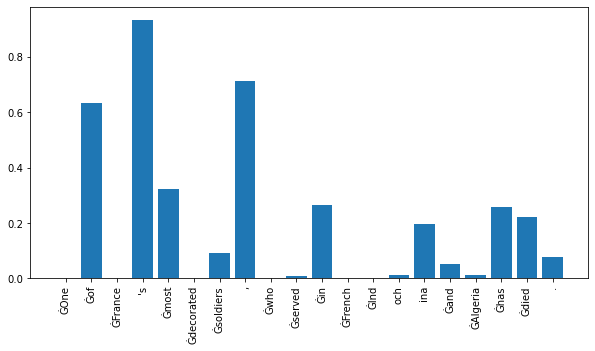

 Masked input:   the Battle
 Summary:   The Battle of the Somme is remembered as one of the most important battles in British history. 



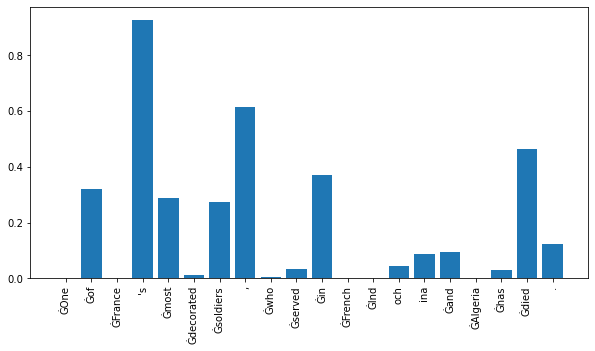

 Masked input:   of France in 1940.
 Summary:   A look back at some of the key events of World War Two. 



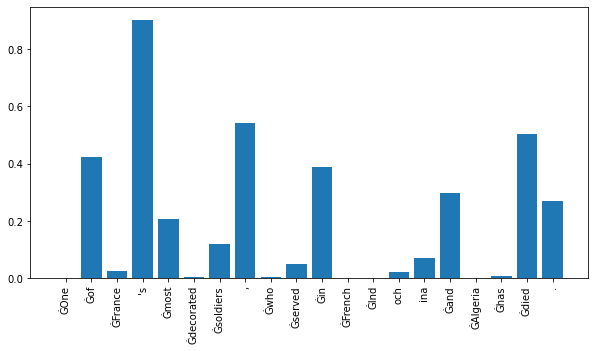

 Masked input:   of France in 1940
 Summary:   A look back at some of the key events of World War Two. 



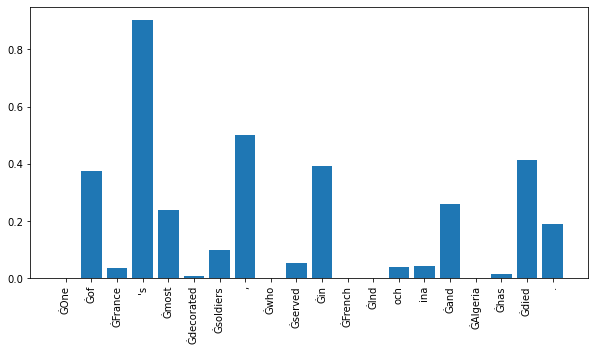

 Masked input:   torture suspected
 Summary:   The BBC News website looks at some of the key stories from the past week: 



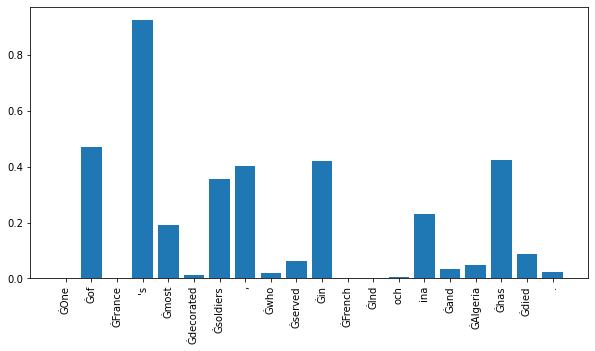

 Masked input:  He managed to escape and joined the Free French in North Africa. From there he was parachuted back in to France to fight with the Resistance.
 Summary:  Former French soldier and World War Two airman Jean-Louis Dauphine has died at the age of 89. 



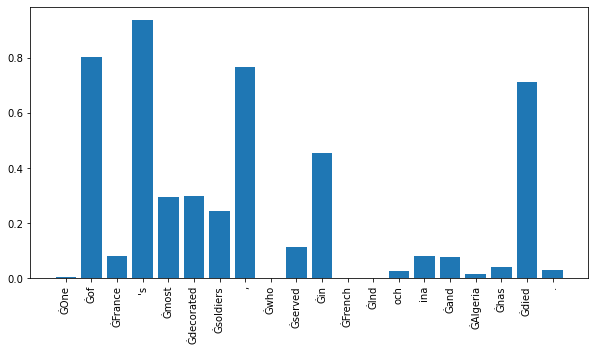

 Masked input:  He managed to escape and joined the Free French in North Africa.
 Summary:   The French army's chief of staff, Charles de Gaulle, was killed in the Battle of the Somme in 1916. 



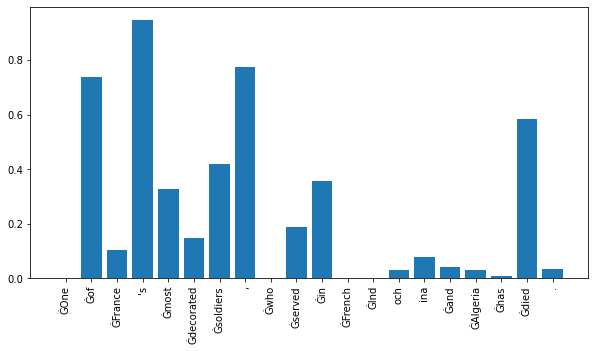

 Masked input:  He managed to escape and joined the Free
 Summary:  Former British Prime Minister Winston Churchill was caught up in a gun battle with the IRA during the Second World War. 



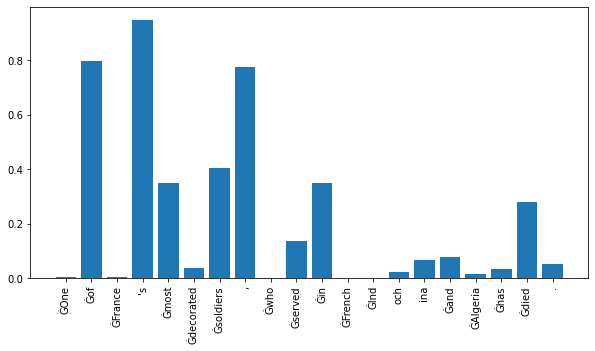

 Masked input:  He managed to escape
 Summary:   A German police officer has been arrested on suspicion of attempted murder after a man was shot in the head with a crossbow. 



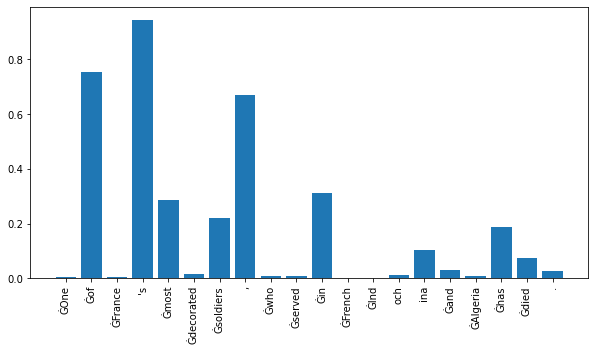

 Masked input:   and joined the Free
 Summary:   The BBC News website looks at some of the most interesting stories of the week. 



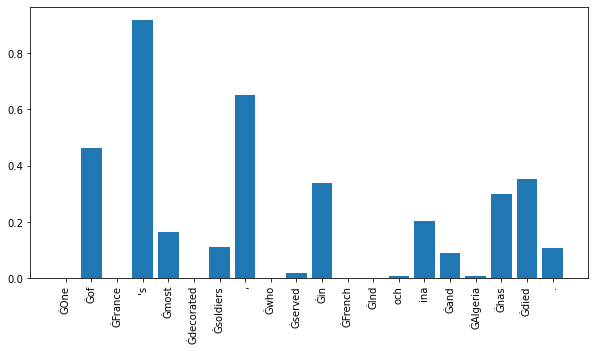

 Masked input:   French in North Africa.
 Summary:   The BBC News website looks at some of the key stories in the history of France. 



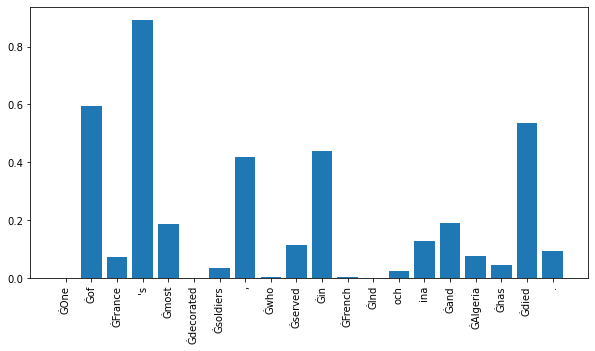

 Masked input:   French in North Africa
 Summary:   The BBC News website looks at some of the key stories in the history of France. 



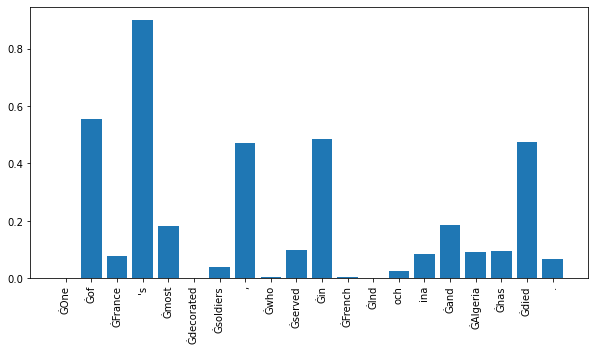

 Masked input:   Defence by
 Summary:   The BBC News website looks at some of the most eye-catching stories of the week. 



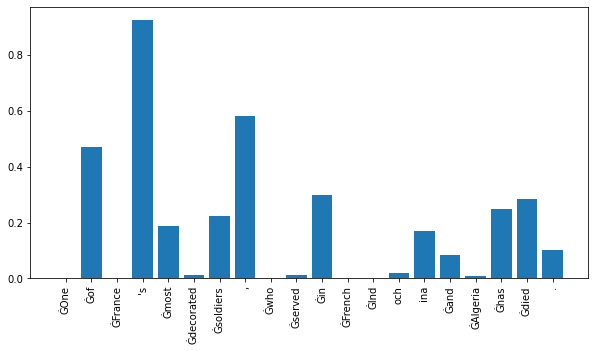

 Masked input:   From there he was parachuted back in to France to fight with the Resistance.
 Summary:  During World War Two, the only British survivor of the Battle of the Somme, was flown to France from the US to fight against the Nazis. 



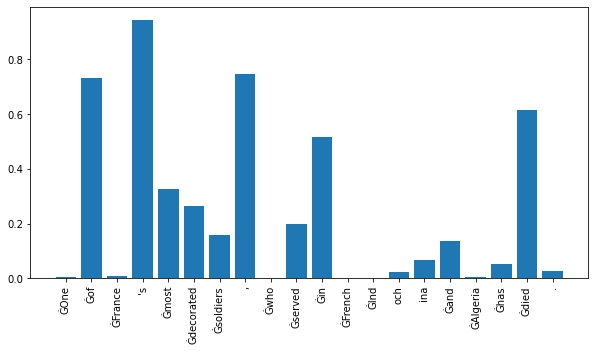

 Masked input:   From there he was parachuted back in
 Summary:  British astronaut Tim Peake was forced to make an emergency landing on the International Space Station after his plane broke down. 



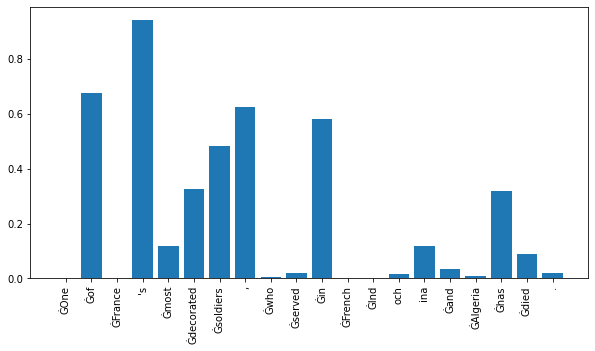

 Masked input:   From there he was
 Summary:   The BBC News website looks back at some of the top stories of the past 12 months. 



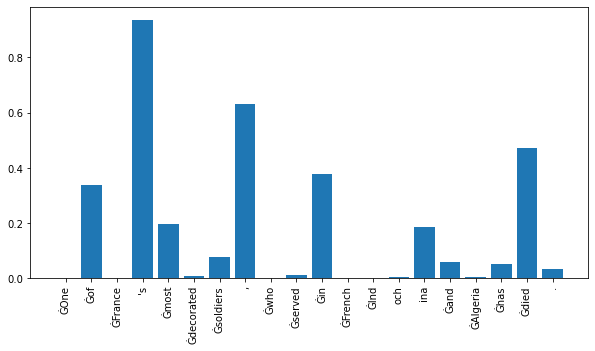

 Masked input:   parachuted back in
 Summary:   A US Navy plane has made an emergency landing in a remote part of the French Alps. 



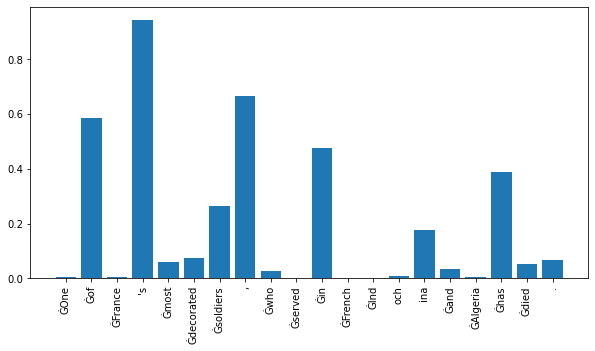

 Masked input:   to France to fight with the Resistance.
 Summary:  The first British soldiers to travel to France during World War Two have died. 



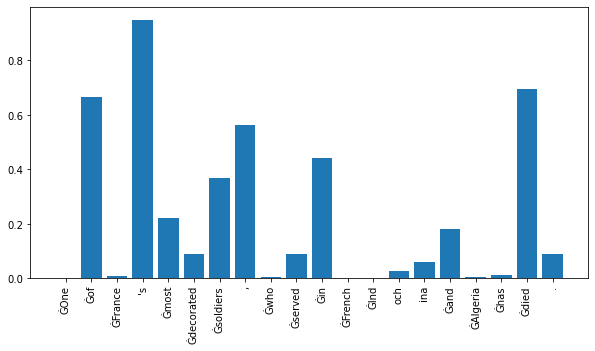

 Masked input:   to France to fight
 Summary:  Hundreds of British soldiers have travelled to France to help in the fight against the so-called Islamic State. 



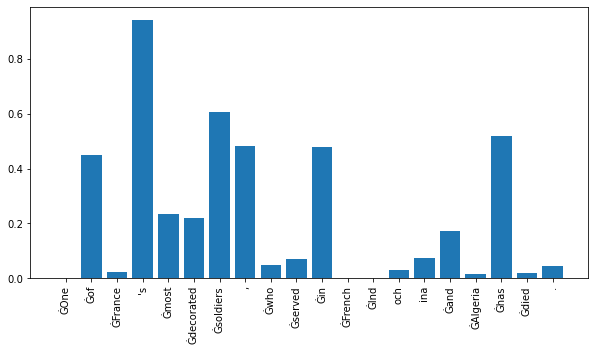

 Masked input:   with the Resistance.
 Summary:   A look back at some of the key moments in the history of World War Two. 



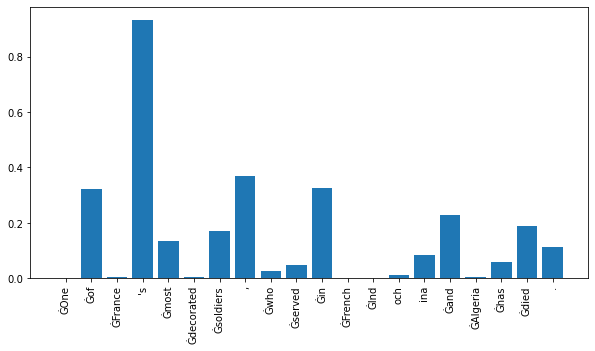

 Masked input:  It was in French Indochina that Gen Bigeard began to make his name as a commander in a Paratroop regiment.He survived the 1954 Battle of Dien Bien Phu, where French troops were surrounded and defeated by the forces of the Vietnamese Communists, the Viet Minh.He was then sent to Algeria where he led the "irregular" counter-insurgency campaign against the National Liberation Front (FLN)
 Summary:  French general Bernard Bigeard, who has died at the age of 93, was one of France's most decorated military commanders. 



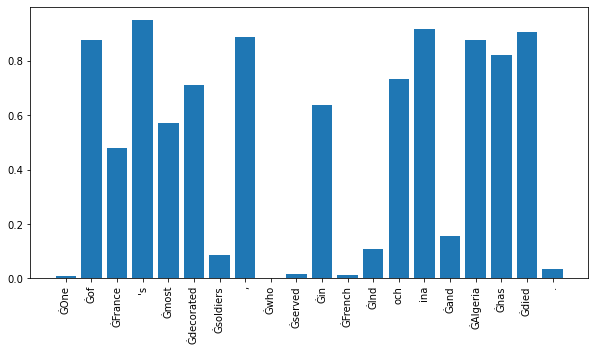

 Masked input:  It was in French Indochina that Gen Bigeard began to make his name as a commander in a Paratroop regiment.He survived the 1954 Battle of Dien Bien Phu, where French troops were surrounded and defeated by the forces of the Vietnamese Communists, the Viet Minh.
 Summary:   The former French army general, Gen Bernard Bigeard, has died at the age of 93. 



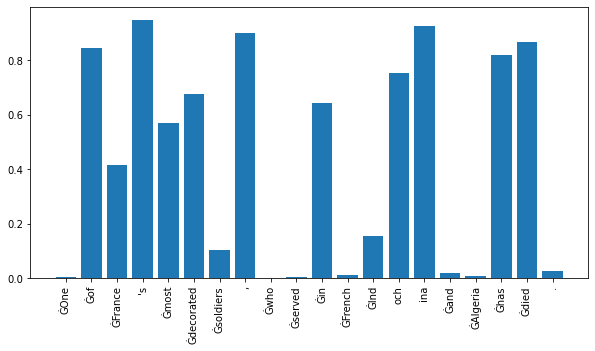

 Masked input:  It was in French Indochina that Gen Bigeard began to make his name as a commander in a Paratroop regiment.
 Summary:   The British Army's most decorated general, Sir Bernard Bigeard, has died at the age of 82. 



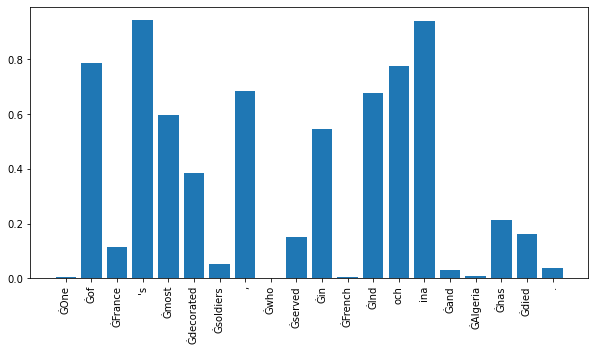

 Masked input:  It was in French Indochina that Gen Bigeard began to make his
 Summary:  French general Charles Bigeard, who was killed in the Battle of the Somme in 1916, was the first French general to die in combat. 



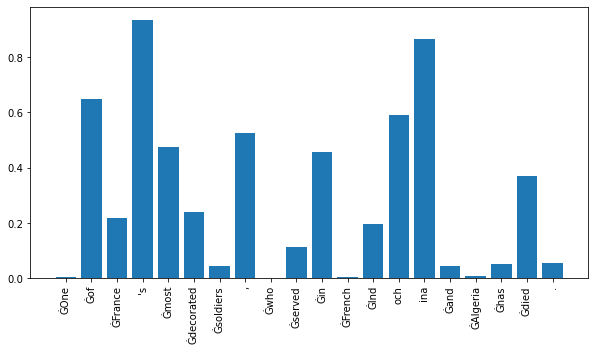

 Masked input:  It was in French Indochina that
 Summary:   The Battle of the Somme was fought between French colonial forces and British colonial forces. 



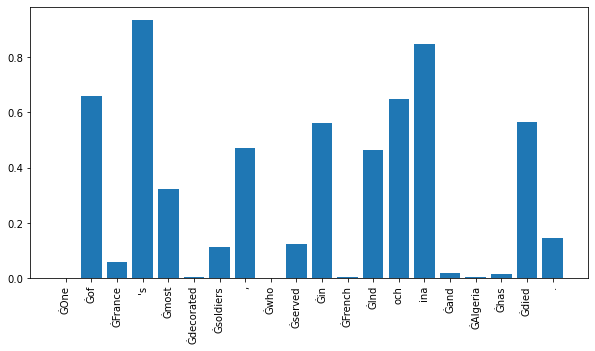

 Masked input:   Gen Bigeard began to make his
 Summary:   The BBC News website takes a look at some of the key moments in the history of the British Army. 



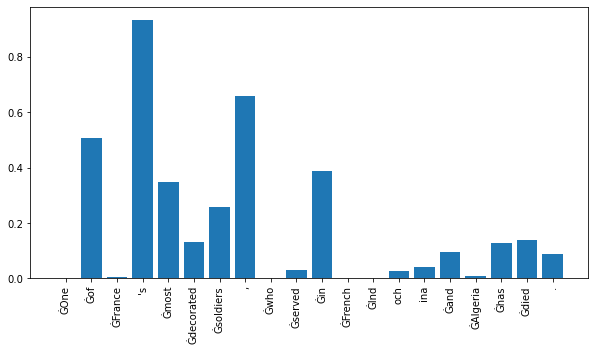

 Masked input:   name as a commander in a Paratroop regiment.
 Summary:   The Duke of Edinburgh has been honoured with a knighthood by the Queen. 



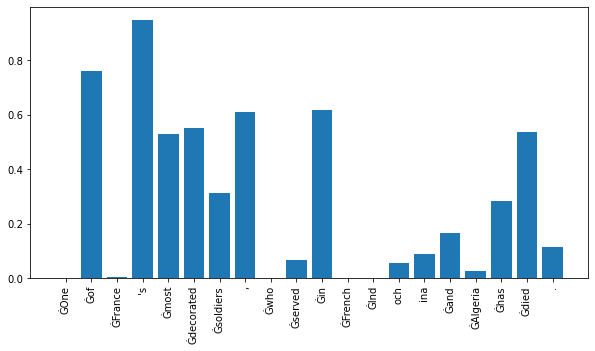

 Masked input:   name as a commander
 Summary:  Sir Winston Churchill was the first British commander to be named after his name. 



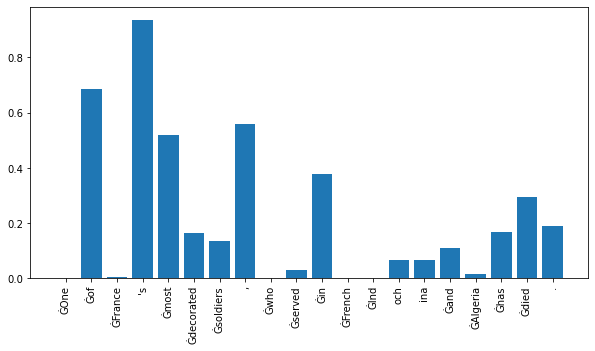

 Masked input:   in a Paratroop regiment.
 Summary:   A British soldier who served in Afghanistan in the 1990s has been killed in the line of duty. 



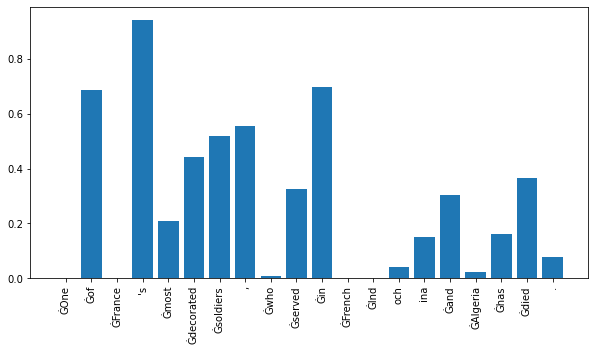

 Masked input:  He survived the 1954 Battle of Dien Bien Phu, where French troops were surrounded and defeated by the forces of the Vietnamese Communists, the Viet Minh.
 Summary:  Former French Prime Minister Charles de Gaulle has died at the age of 91. 



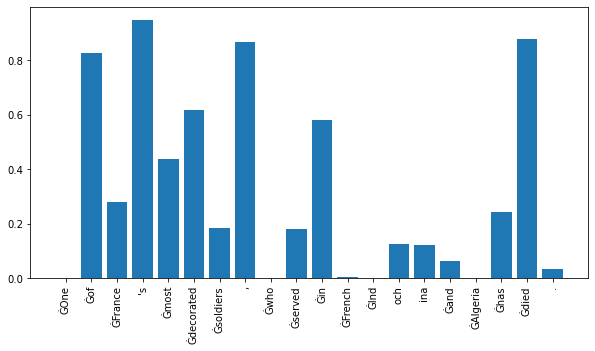

 Masked input:  He survived the 1954 Battle of Dien Bien Phu,
 Summary:  Former British army captain and World War Two veteran Sir Winston Churchill has died at the age of 93. 



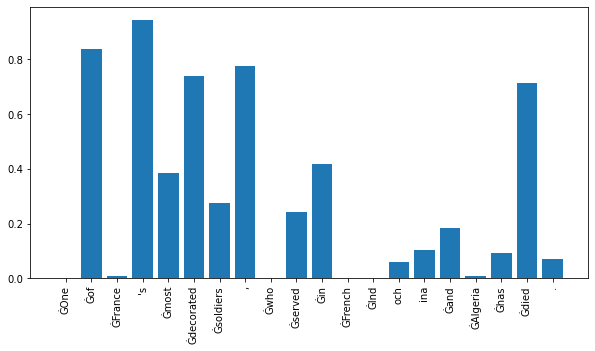

 Masked input:  He survived the 1954 Battle of Dien
 Summary:   The former British army captain and World War Two veteran Sir Winston Churchill has died at the age of 93. 



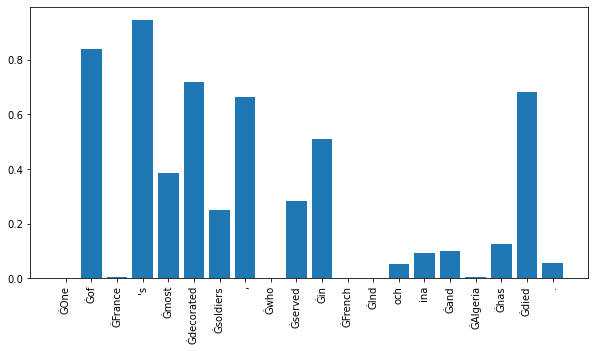

 Masked input:   Bien Phu,
 Summary:   The BBC News website looks at some of the key stories from the past week. 



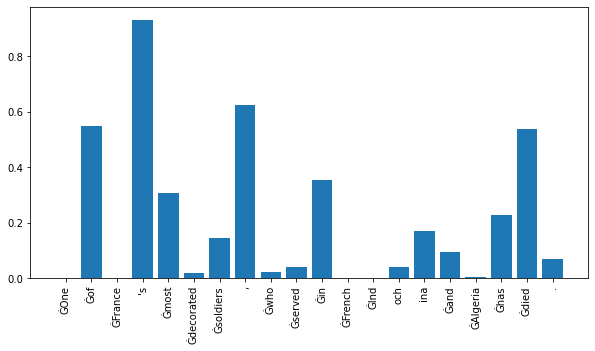

 Masked input:   where French troops were surrounded and defeated by the forces of the Vietnamese Communists, the Viet Minh.
 Summary:   The Battle of the Somme is one of the most famous battles in the history of France. 



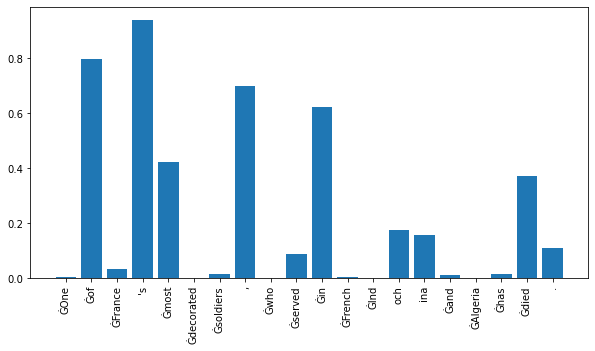

 Masked input:   where French troops were surrounded and defeated by the forces of the Vietnamese Communists,
 Summary:   The Battle of Hanoi is one of the most famous battles of the Vietnam War. 



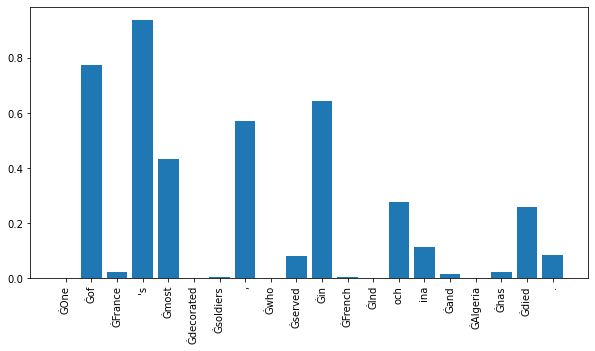

 Masked input:   the Viet Minh.
 Summary:   The Viet Minh are one of Vietnam's best-known and most famous political parties. 



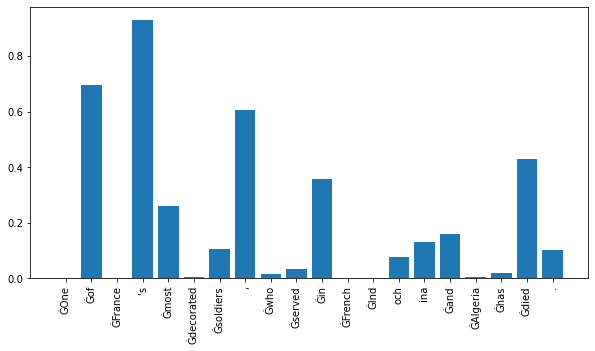

 Masked input:  He was then sent to Algeria where he led the "irregular" counter-insurgency campaign against the National Liberation Front (FLN)
 Summary:  Former Algerian Prime Minister Hissene Habib has died at the age of 93. 



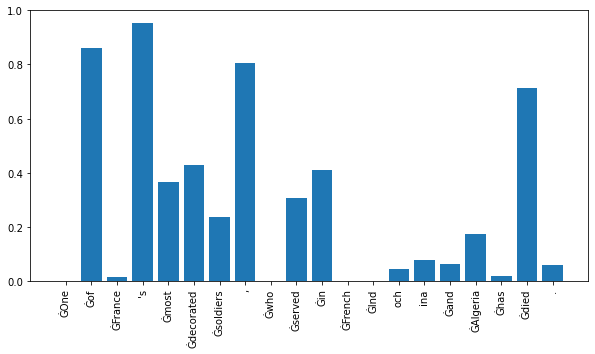

 Masked input:  He was then sent to Algeria where he led the "irregular" counter-
 Summary:  In the early 1970s and early 1980s, the French army's chief of staff, Charles de Gaulle, was killed in a gun battle with the Algerian army. 



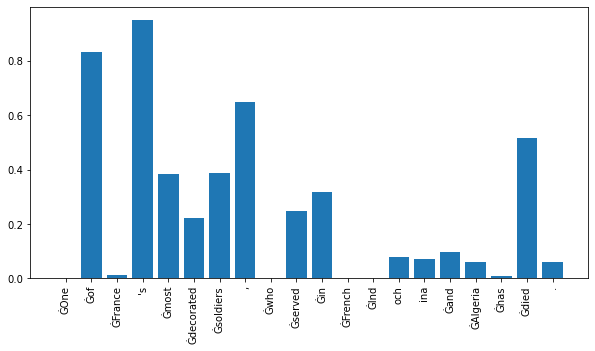

 Masked input:  He was then sent to Algeria where he
 Summary:   The first British soldier to die in World War Two was killed by a British airman in the Sinai peninsula. 



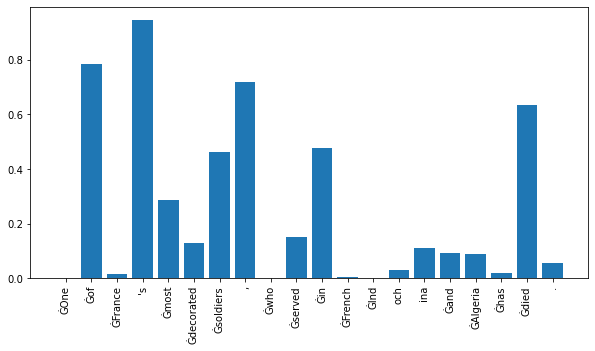

 Masked input:  He was then sent
 Summary:   The BBC News website looks back at some of the key stories of the year. 



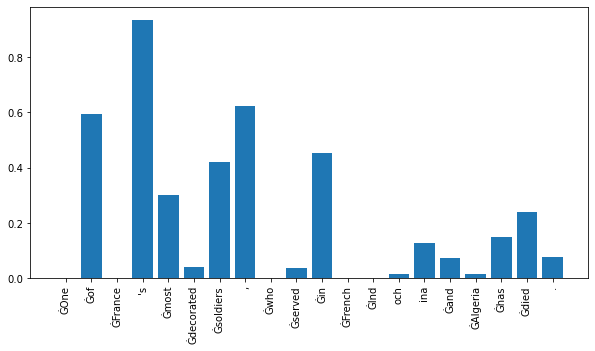

 Masked input:   to Algeria where he
 Summary:   Former Algerian President Omar al-Bashir has been expelled from the country. 



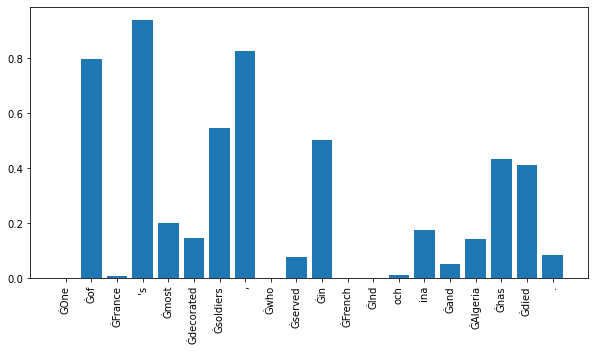

 Masked input:   led the "irregular" counter-
 Summary:  Former US President George W Bush has announced he will not seek re-election in the US. 



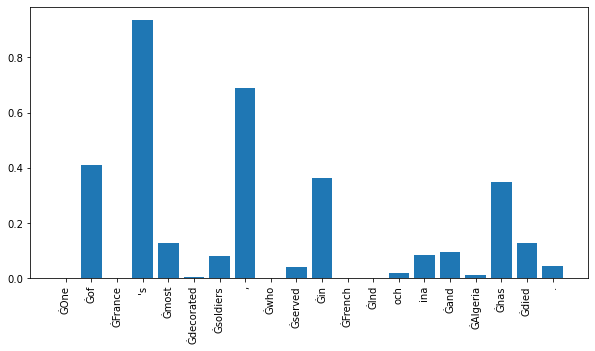

 Masked input:   led the "ir
 Summary:   The former president of the United States, George W Bush, has announced his resignation. 



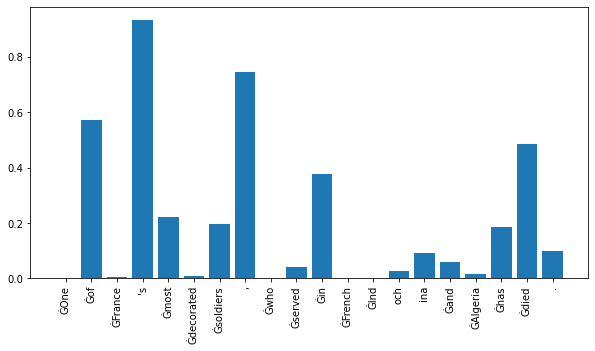

 Masked input:  regular" counter-
 Summary:  Regularity is a popular form of sport, but it is not as popular as it seems. 



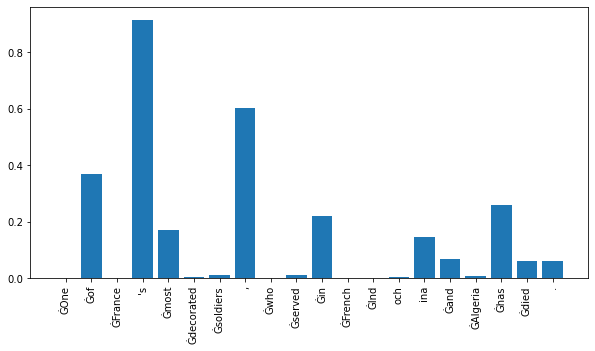

 Masked input:  insurgency campaign against the National Liberation Front (FLN)
 Summary:   The BBC News website looks back at some of the key events of the 1970s and 1980s in Colombia. 



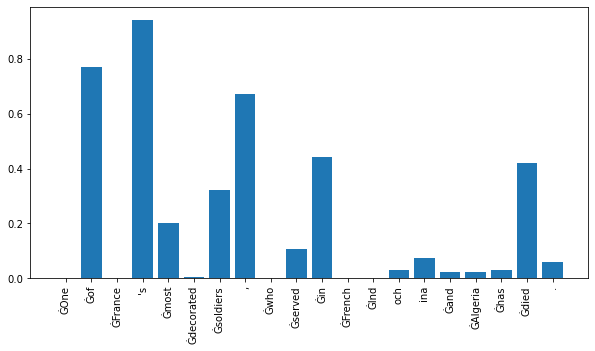

 Masked input:  insurgency campaign against the National Liberation
 Summary:   The BBC News website looks back at some of the key events of the 1970s. 



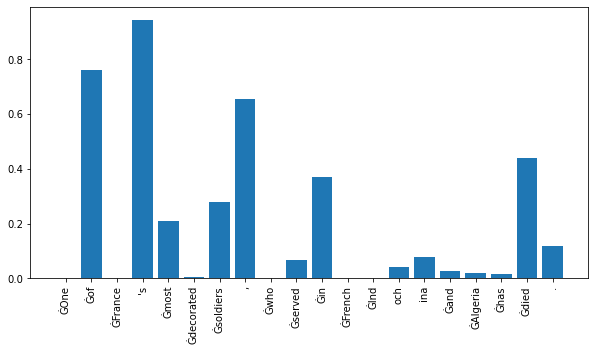

 Masked input:  insurgency campaign
 Summary:  Pakistan's government says it will launch a military operation against the Taliban in the next few days. 



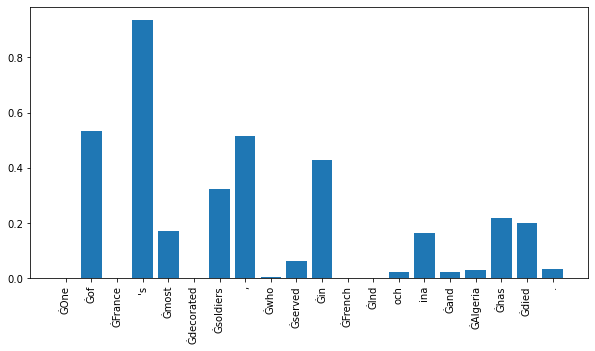

 Masked input:   against the National Liberation
 Summary:   The National Liberation Army (NLA) was formed in the 1970s and 80s with the help of the British Army. 



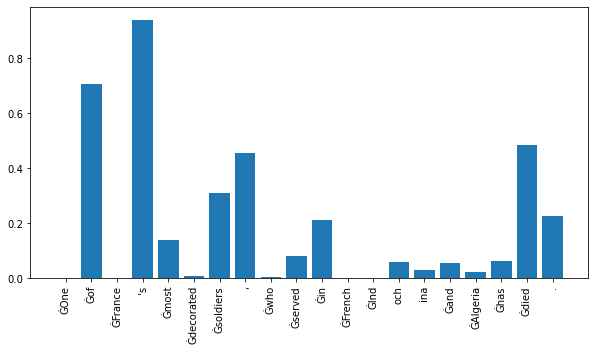

 Masked input:   Front (FLN)
 Summary:   The National Front (FLN) is the main opposition party in France. 



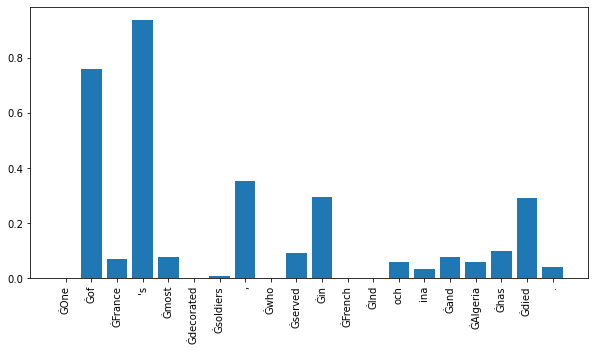

 Masked input:   Front (
 Summary:   French police have arrested two men on suspicion of involvement in the murder of a French soldier. 



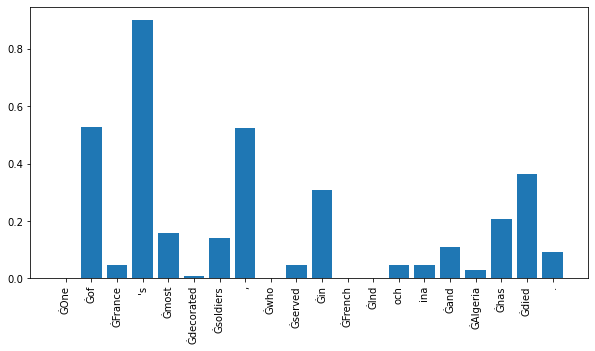

 Masked input:  FLN)
 Summary:   The People's Liberation Front (FLN) has announced it will launch its campaign for independence from the European Union. 



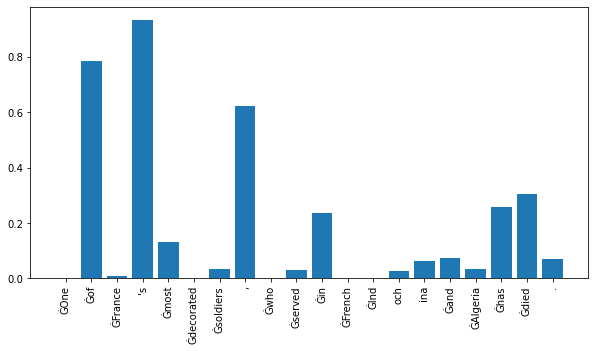

 Masked input:   during the 1957 Battle of Algiers.He later told Le Monde newspaper that it was "necessary" to torture suspected FLN sympathisers to extract information about bombings carried out by the Algerian insurgents.In 1975 he was appointed State Secretary for Defence by President Valery Giscard d'Estaing.He retired from the army in 1976.He was believed to be one of the most decorated soldiers in France and had received medals from both France and Britain for his wartime service.

 Summary:   The former French army chief of staff, Jean-Louis Dauriac, has died at the age of 89. 



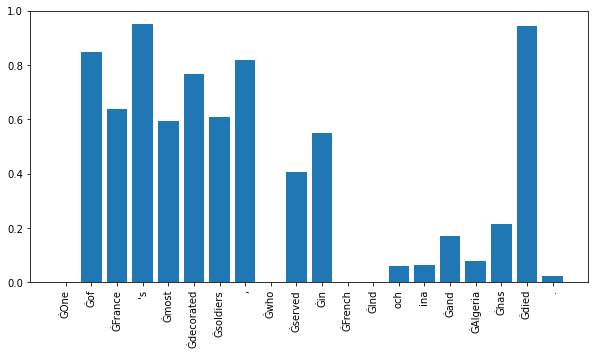

 Masked input:   during the 1957 Battle of Algiers.He later told Le Monde newspaper that it was "necessary" to torture suspected FLN sympathisers to extract information about bombings carried out by the Algerian insurgents.
 Summary:   Former Algerian Prime Minister Jean-Bedel has died at the age of 89 after suffering a stroke. 



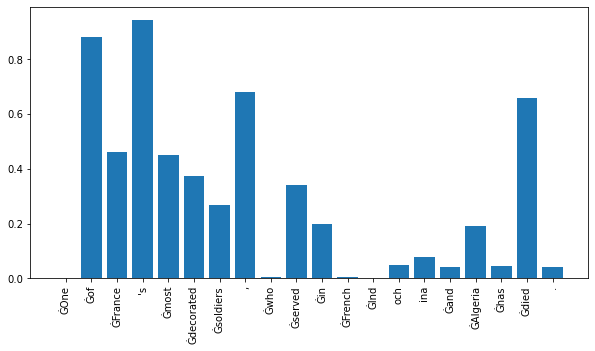

 Masked input:   during the 1957 Battle of Algiers.
 Summary:   Algerian forces fought against French and Algerian troops at the height of the Algerian civil war. 



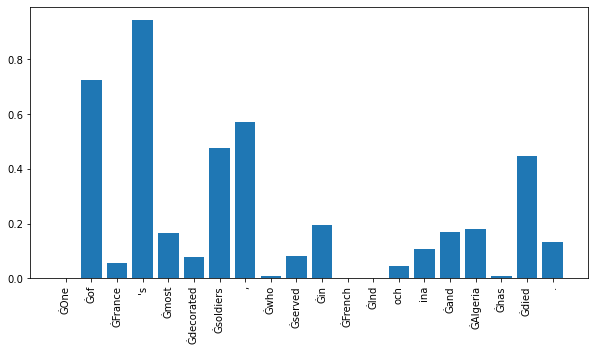

 Masked input:   during the 1957 Battle
 Summary:   The Battle of the Somme is remembered as one of the bloodiest battles in British history. 



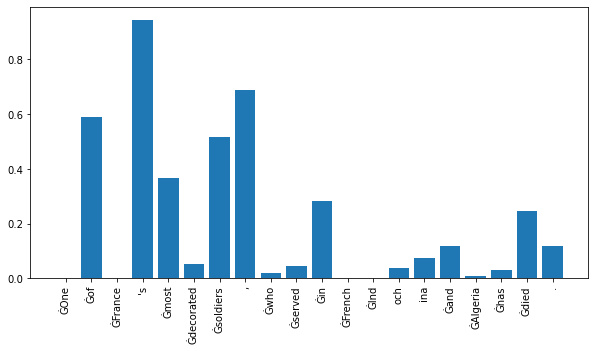

 Masked input:   during the
 Summary:   The BBC News website looks back at some of the most eye-catching stories of the past 12 months. 



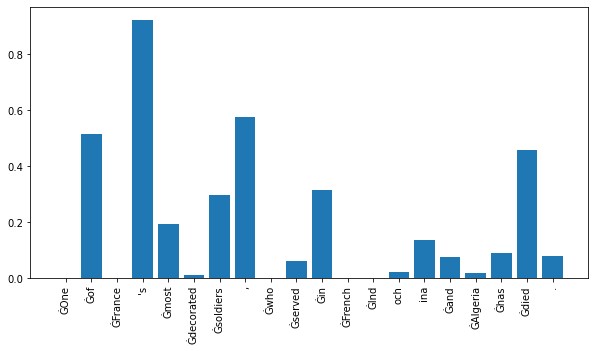

 Masked input:  -Presse.
 Summary:   The BBC News website looks at some of the key stories from the past week. 



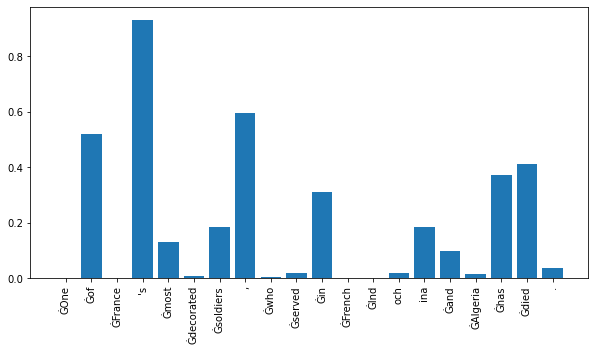

 Masked input:  -Presse
 Summary:  All photographs courtesy of AFP, EPA, Getty Images and Reuters 



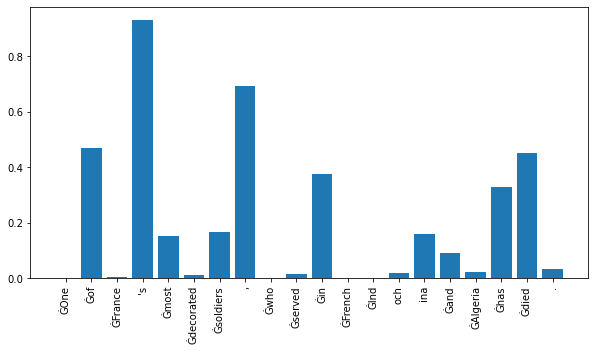

 Masked input:   controversy in
 Summary:   The BBC News website looks at some of the most eye-catching stories of the past week. 



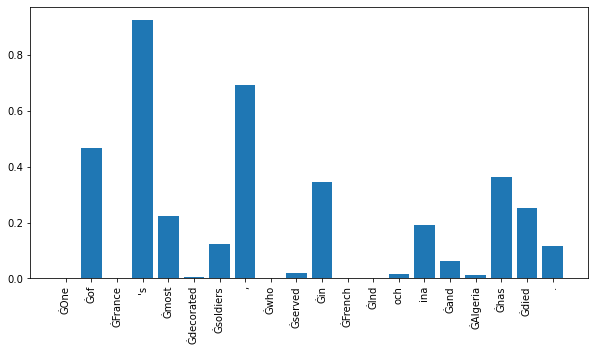

 Masked input:   Battle of Algiers
 Summary:   The Battle of Algiers is remembered as one of the bloodiest battles of World War Two. 



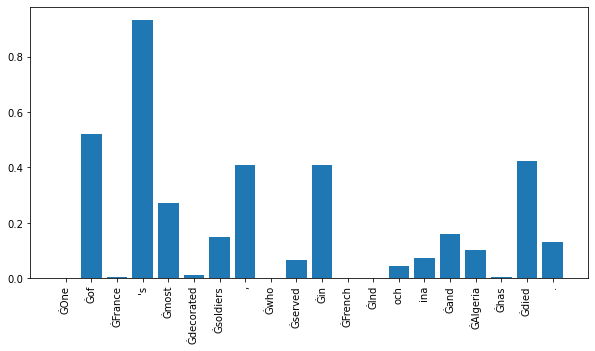

 Masked input:   Battle of
 Summary:   The Battle of the Somme is remembered as one of the most important battles in British history. 



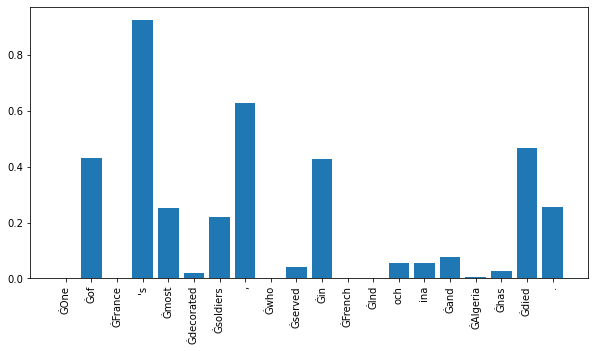

 Masked input:   Algiers
 Summary:   Algerian President Abdel Fattah al-Sisi has announced he will step down from the presidency. 



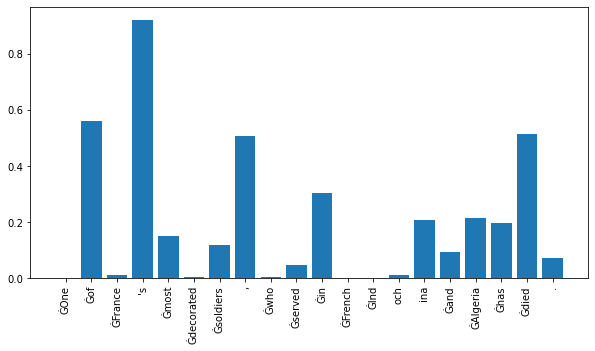

 Masked input:   1957 Battle
 Summary:   The Battle of the Somme is being marked on the 60th anniversary of the Battle of Britain. 



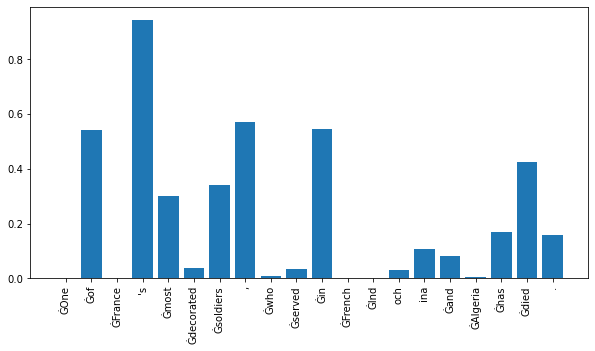

 Masked input:  necessary evil" in Algeria
 Summary:   Algeria's President, Abdel Fattah al-Abidine al-Khalifa, has been accused of being a "terrorist". 



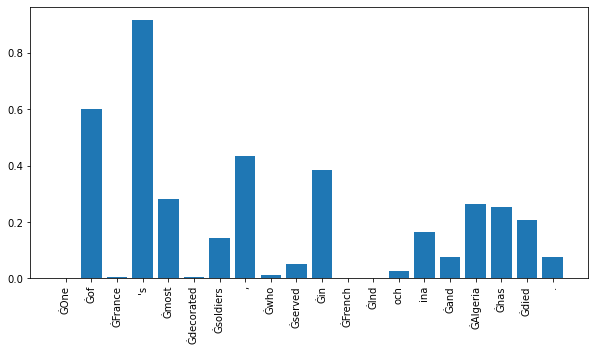

 Masked input:  necessary evil
 Summary:   A look back at some of the most eye-catching stories of the past 12 months. 



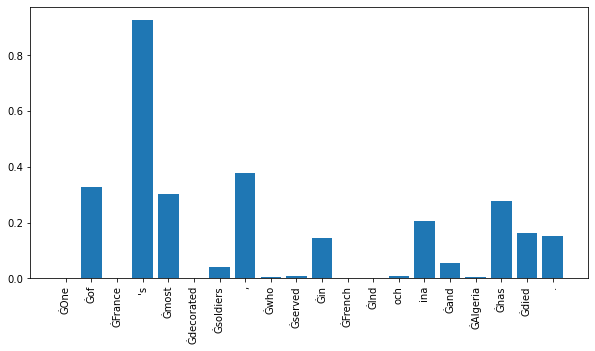

 Masked input:  " in Algeria
 Summary:   The BBC Sport website looks at some of the key stories in Algeria, including: 



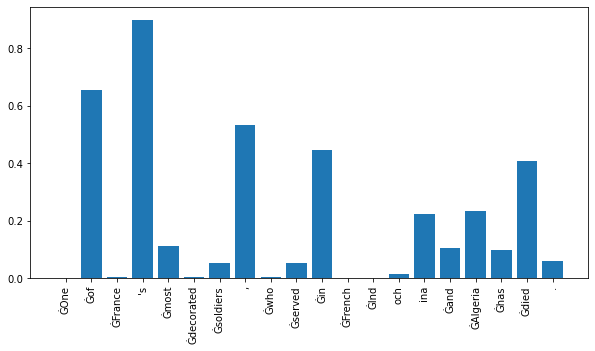

 Masked input:   with the Resistance.
 Summary:   A look back at some of the key moments in the history of World War Two. 



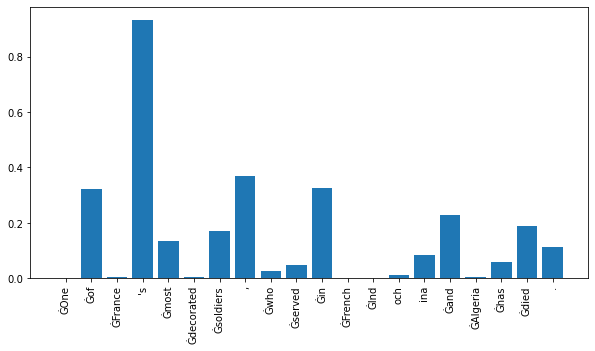

 Masked input:   with the Resistance
 Summary:   A look back at some of the key moments in the history of World War Two. 



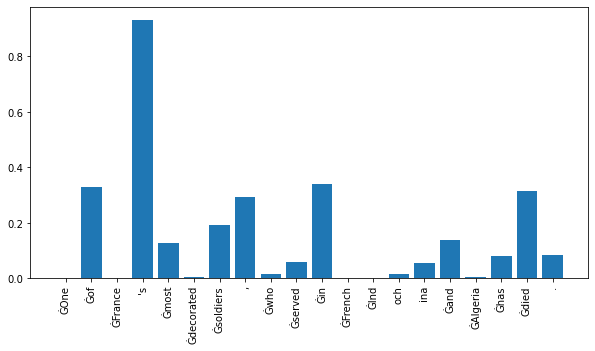

 Masked input:   medals from
 Summary:   Olympic gold medallists from the Rio Games have been announced. 



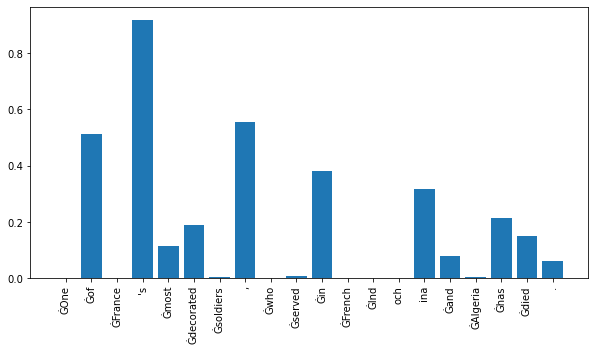

 Masked input:   of Algiers.
 Summary:  Images courtesy of AFP, EPA, Getty Images and Reuters 



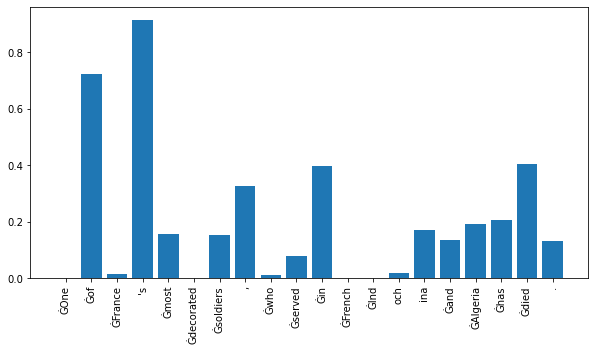

 Masked input:   of Algiers
 Summary:   Algerian President Abdel Fattah al-Sisi has announced that he will step down from the presidency of Algeria. 



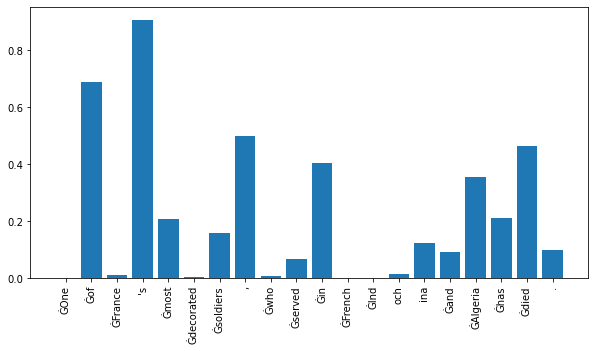

 Masked input:   of Al
 Summary:   The BBC News website looks at some of the key stories from the past 12 months. 



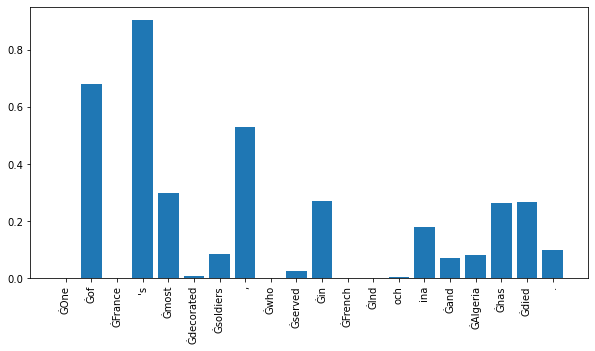

 Masked input:   Front (FLN)
 Summary:   The National Front (FLN) is the main opposition party in France. 



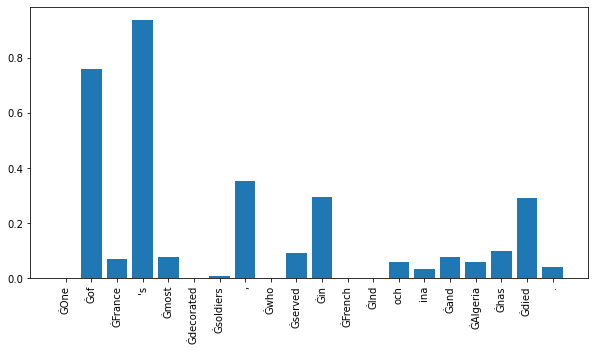

 Masked input:   d'Estaing
 Summary:   D'Estaing, a village in the south-west of France, has been declared a national park by the French government. 



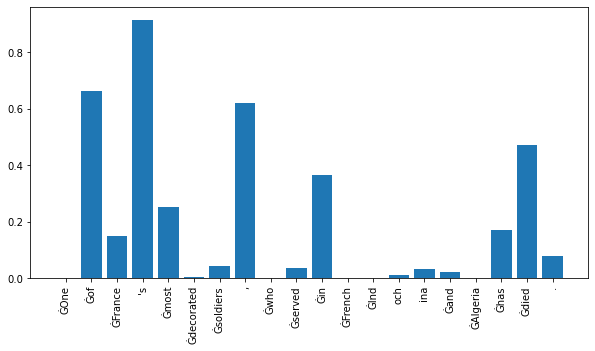

 Masked input:  giers
 Summary:   The BBC News website looks at some of the most eye-catching stories of the past week. 



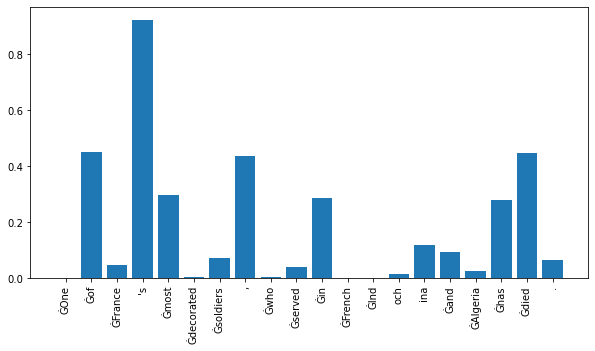

 Masked input:   army in 1976.
 Summary:  Former British Prime Minister David Cameron has resigned from the army. 



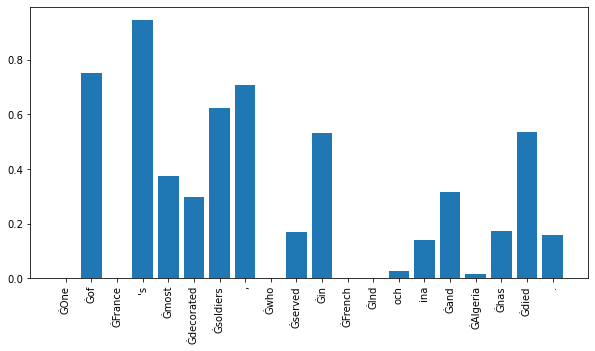

 Masked input:   as an enlisted man,
 Summary:   As the British Army prepares for World War Two, BBC News takes a look back at some of the most memorable moments of the conflict. 



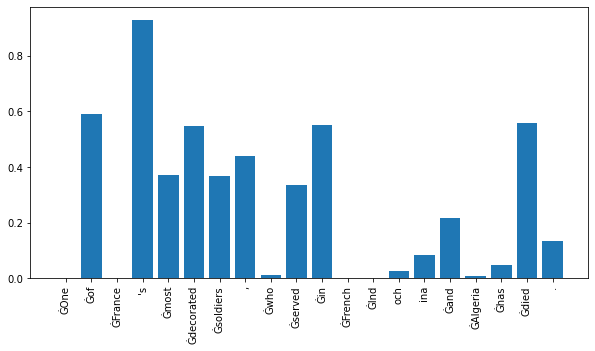

 Masked input:   of France in 1940.
 Summary:   A look back at some of the key events of World War Two. 



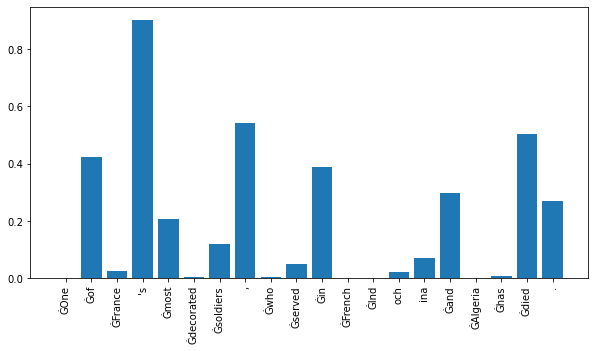

 Masked input:   of France in 1940
 Summary:   A look back at some of the key events of World War Two. 



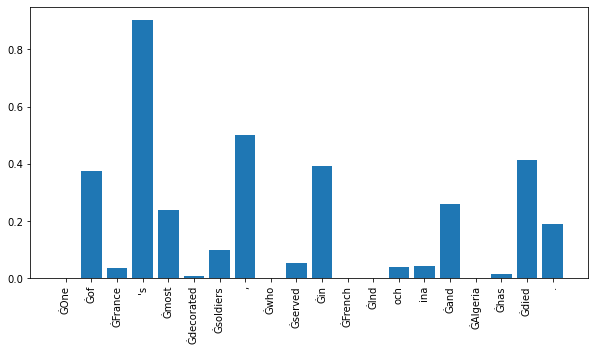

 Masked input:   of France
 Summary:  French President Francois Hollande has announced that he will step down from the presidential election in May. 



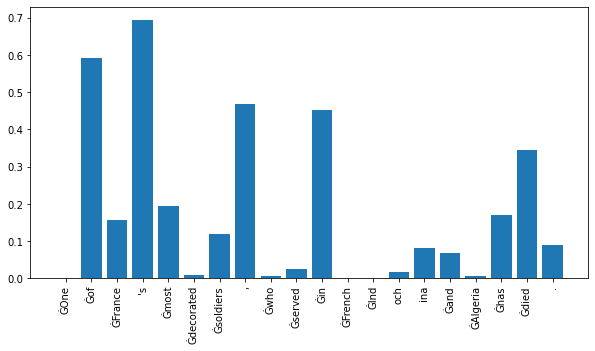

 Masked input:   in 1940
 Summary:   A look back at some of the most memorable moments of World War Two. 



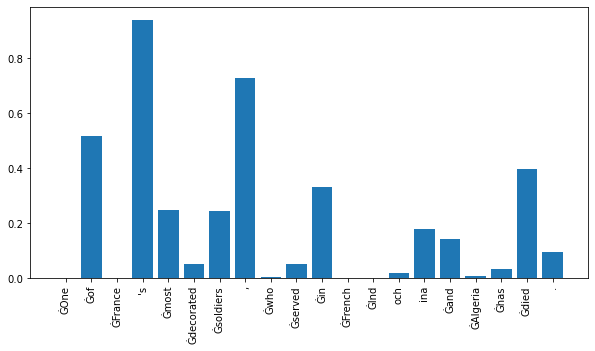

 Masked input:   torture suspected
 Summary:   The BBC News website looks at some of the key stories from the past week: 



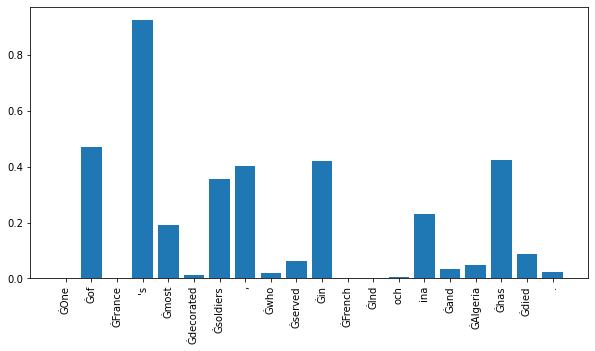

 Masked input:  Gen Bigeard was a commanding officer
 Summary:   The former head of the Irish Army, Sir John Bigeard, has died. 



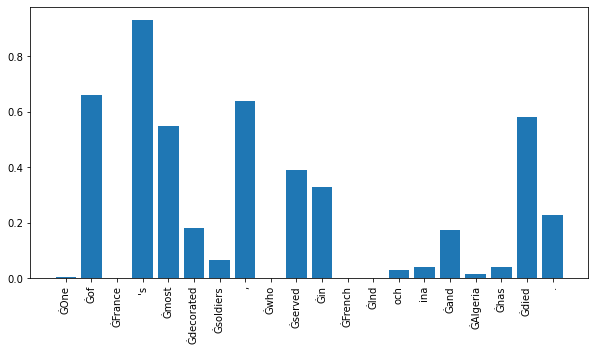

 Masked input:   during the battle of Dien Bien
 Summary:  During the Battle of the Somme, World War Two, the French army and French troops were fighting each other for the first time. 



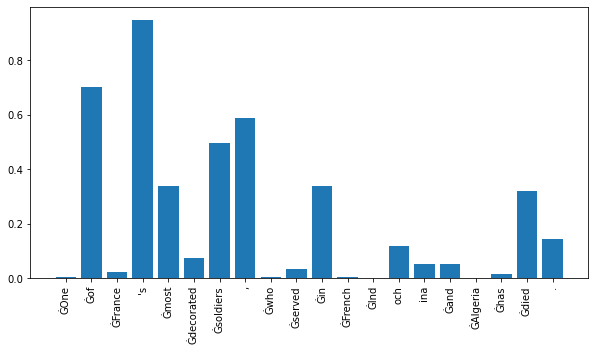

 Masked input:  He later told Le Monde newspaper that it was "necessary" to torture suspected FLN sympathisers to extract information about bombings carried out by the Algerian insurgents.
 Summary:  French President Francois Hollande has admitted that he ordered the torture of suspected FLN sympathisers in the Algerian capital, Ouagadougou. 



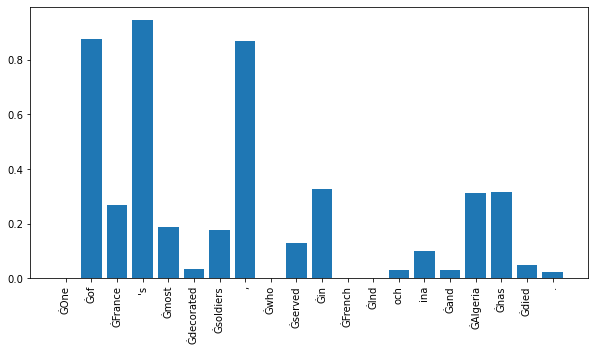

 Masked input:  He later told Le Monde newspaper that it was "necessary" to torture suspected
 Summary:  French President Francois Hollande has ordered the arrest of two people on suspicion of terror offences, including torture. 



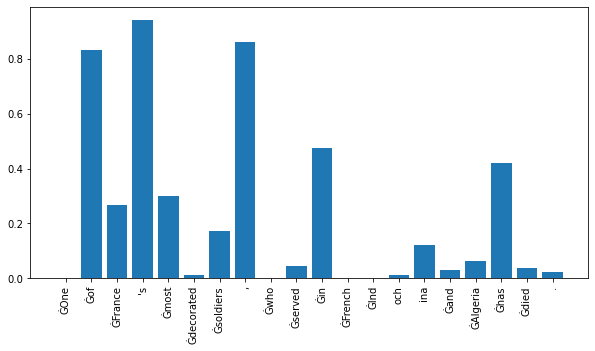

 Masked input:  He later told Le Monde newspaper that
 Summary:   French Prime Minister Manuel Valls has resigned from his post, saying he had "no choice" but to leave the country. 



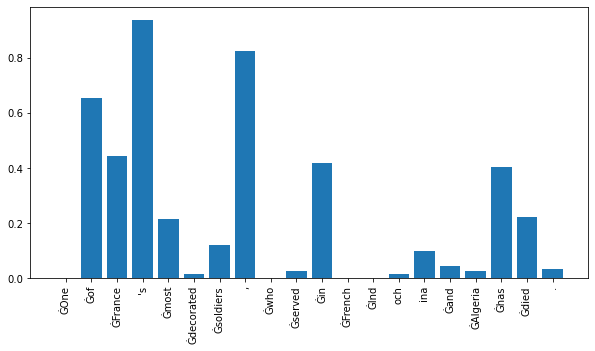

 Masked input:  He later told Le
 Summary:  Former French Prime Minister Charles De Gaulle has said he will not give up on his bid to become prime minister. 



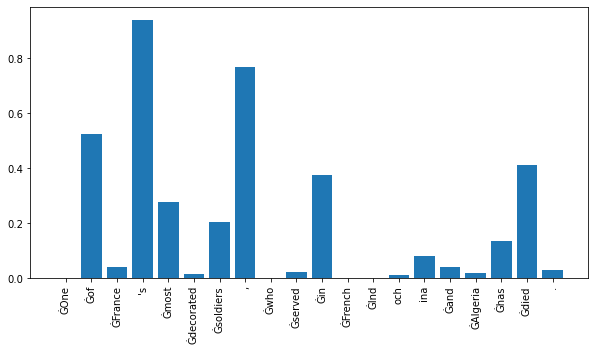

 Masked input:  He later
 Summary:  Former British Prime Minister David Cameron has announced he is to step down as an MP. 



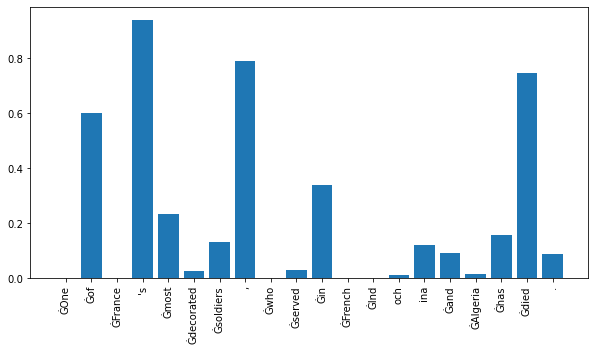

 Masked input:   told Le
 Summary:  Former French Prime Minister Manuel Valls has told the BBC that he will not resign over his role in the EU referendum. 



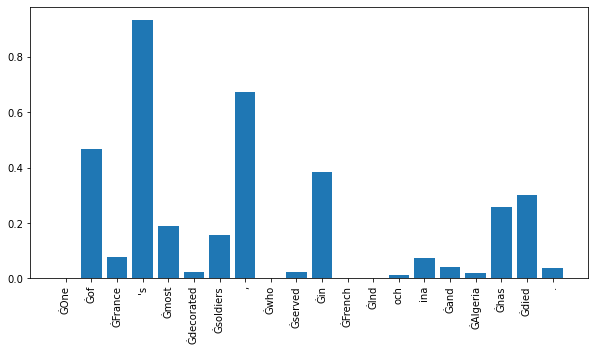

 Masked input:   Monde newspaper that
 Summary:   French newspaper L'Oreal has said that French President Francois Hollande's government has ordered a review of the French constitution. 



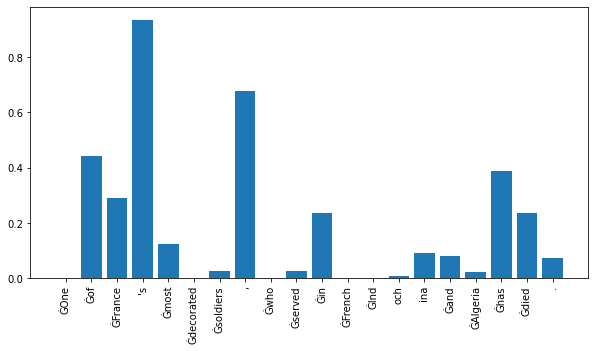

 Masked input:   Monde
 Summary:  French newspaper Le Monde reports that the French government is planning to launch a major anti-corruption campaign. 



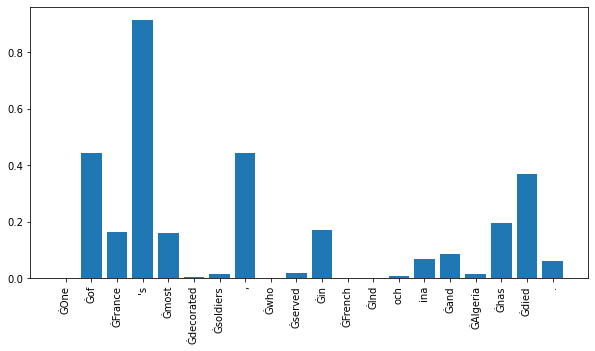

 Masked input:   newspaper that
 Summary:   The Washington Post reports that the Washington Post is the first newspaper in the United States to publish a full front page. 



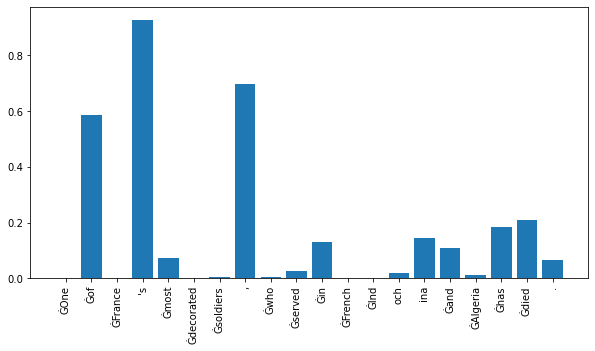

 Masked input:   it was "necessary" to torture suspected
 Summary:  US President Barack Obama has defended the use of torture by US forces in Afghanistan. 



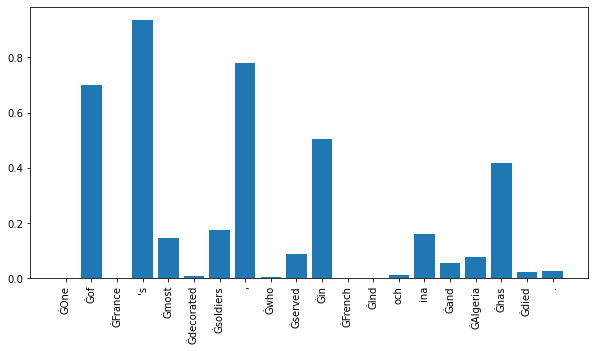

 Masked input:   it was "necessary
 Summary:  Former US President George W Bush has defended the use of chemical weapons in Afghanistan. 



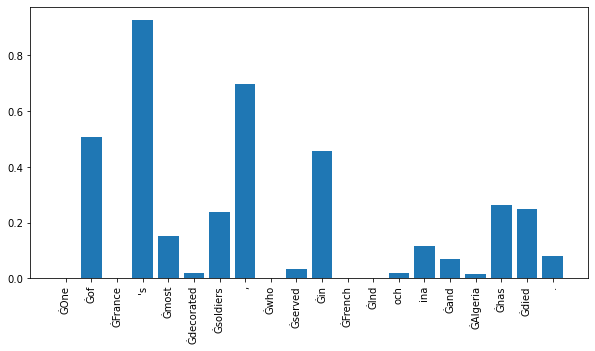

 Masked input:   it was
 Summary:   It was the first time the name of a dog was given to a dog. 



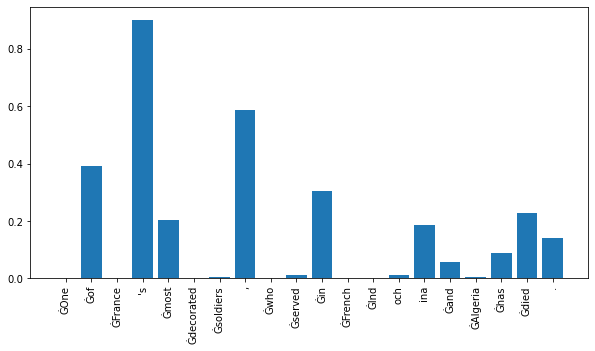

 Masked input:   "necessary
 Summary:   The BBC News website looks back at some of the most eye-catching stories of the past 12 months. 



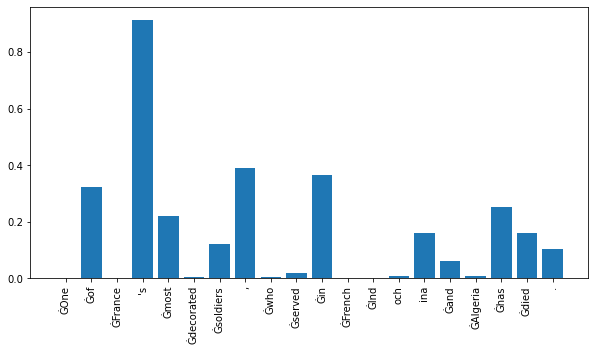

 Masked input:  " to torture suspected
 Summary:   "Tens of thousands" of people have signed a petition calling for the release of a number of torture suspects. 



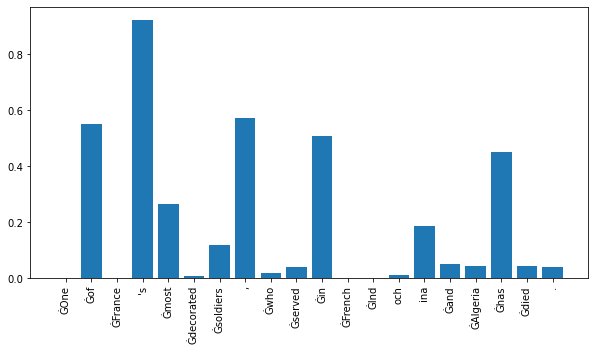

 Masked input:  " to
 Summary:   "I have never heard a song like this." 



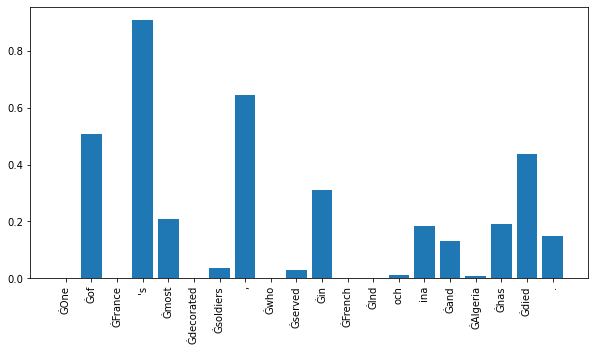

 Masked input:   torture suspected
 Summary:   The BBC News website looks at some of the key stories from the past week: 



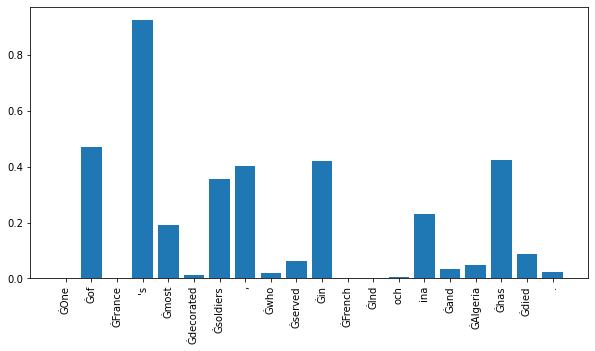

 Masked input:   FLN sympathisers to extract information about bombings carried out by the Algerian insurgents.
 Summary:   The Algerian National Liberation Army (FLN) has been accused of spying for the Algerian government. 



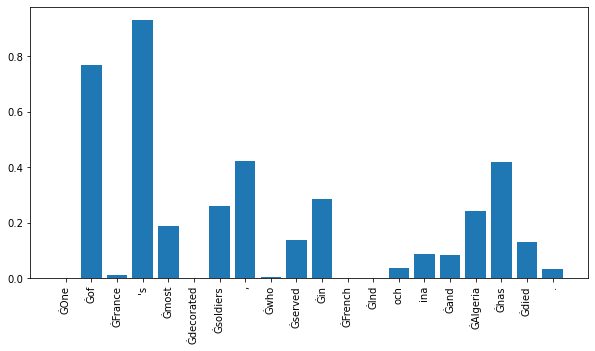

 Masked input:   FLN sympathisers to extract information about
 Summary:  Police in the north-east of the country have arrested two men suspected of being members of the FLN. 



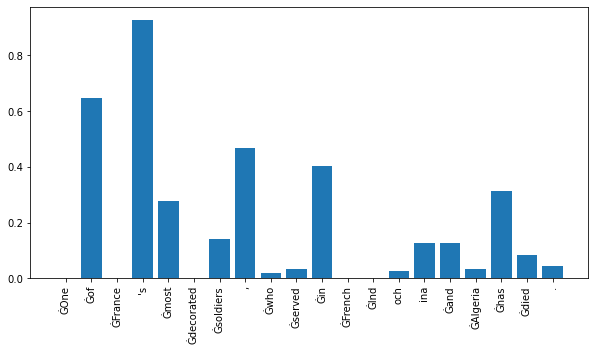

 Masked input:   FLN sympathisers
 Summary:  Anti-terror police have fired tear gas to break up a protest in the centre of Nairobi. 



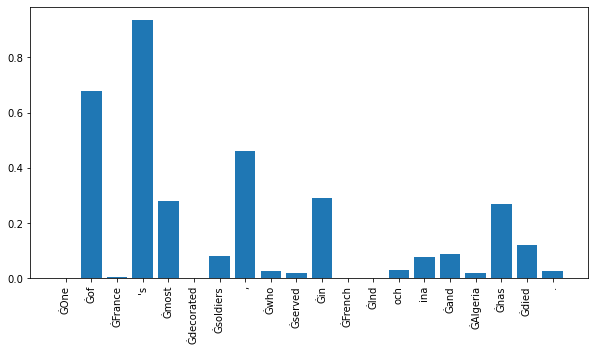

 Masked input:   FLN
 Summary:   The National Football League (FLN) has announced it will not be holding elections in the UK for the next two years. 



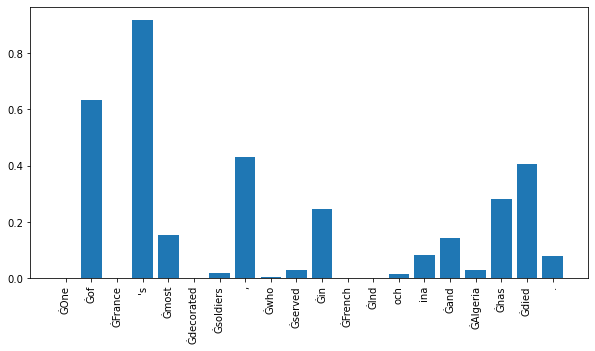

 Masked input:   sympathisers
 Summary:  US President Donald Trump has called for an end to "the war of words" between the United States and North Korea. 



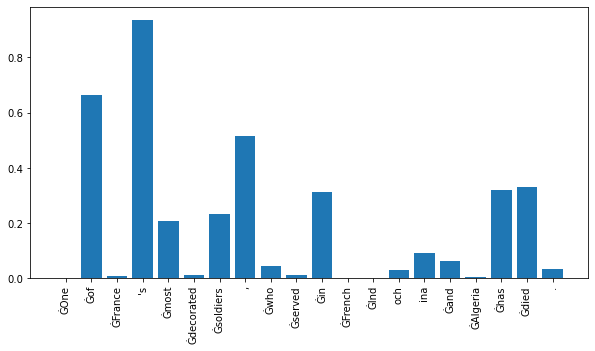

 Masked input:   to extract information about
 Summary:   The BBC News website looks at some of the key stories of the past week. 



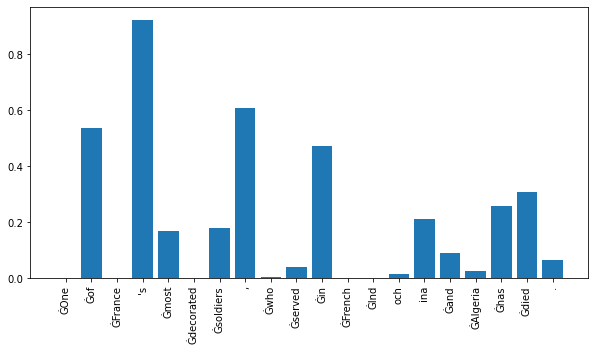

 Masked input:   to extract
 Summary:  BBC Sport takes a look at some of the top stories of the week. 



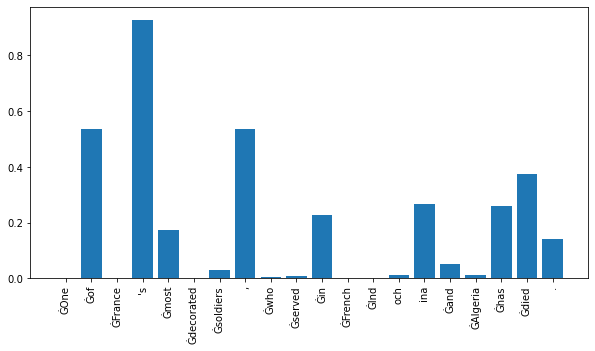

 Masked input:   information about
 Summary:  BBC Sport takes a look at some of the top sports stories of the year. 



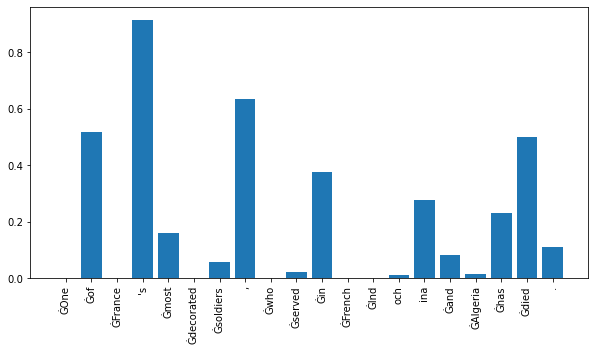

 Masked input:   bombings carried out by the Algerian insurgents.
 Summary:   A series of attacks in and around the Algerian capital, Ouagadougou, has left more than 100 people dead. 



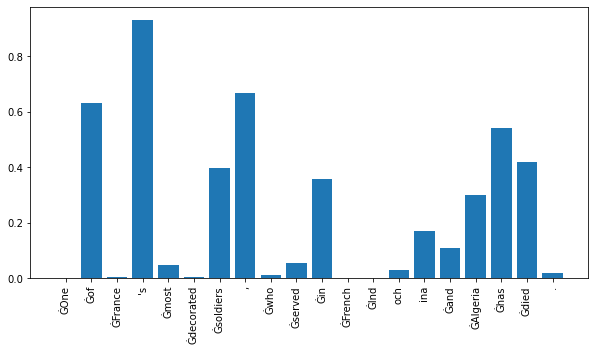

 Masked input:   bombings carried out by
 Summary:   The BBC News website looks at some of the key stories of the past week. 



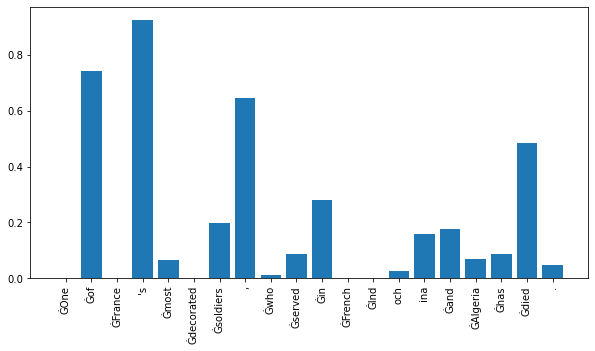

 Masked input:   bombings carried
 Summary:   The BBC News website looks at some of the key stories from the past week, including: 



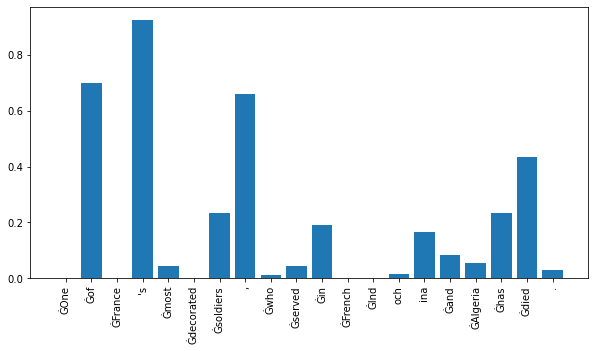

 Masked input:   out by
 Summary:   A look back at some of the top stories of the past 12 months. 



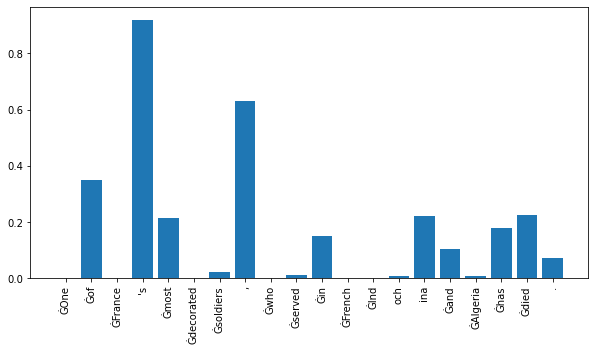

 Masked input:   the Algerian insurgents.
 Summary:  Al-Qaeda-linked militants have killed more than 100 people in the Algerian capital, Ouagadougou. 



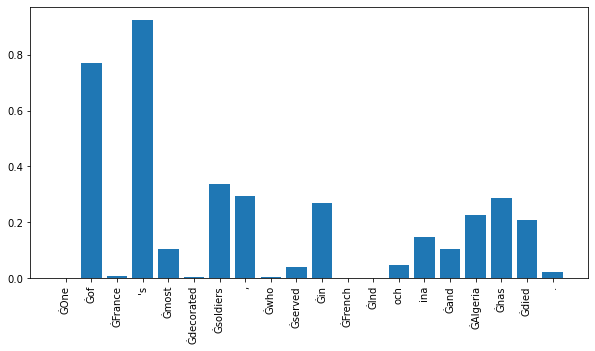

 Masked input:   the Algerian insurgents
 Summary:   Algerian President Abdel Fattah al-Abidine al-Bashir says his forces are fighting a "terrorist operation" in the country. 



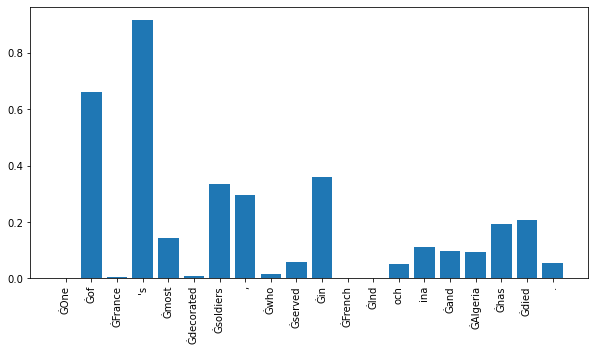

 Masked input:   it was "necessary" to torture suspected
 Summary:  US President Barack Obama has defended the use of torture by US forces in Afghanistan. 



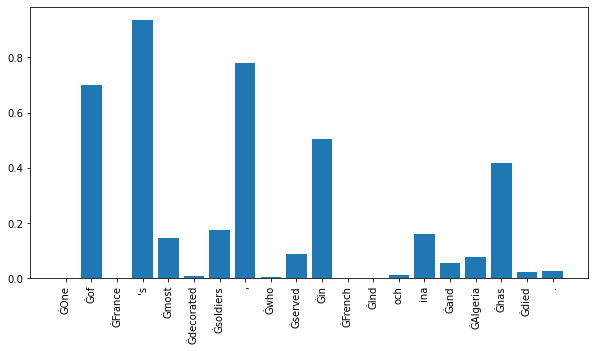

 Masked input:  In 1975 he was appointed State Secretary for Defence by President Valery Giscard d'Estaing.He retired from the army in 1976.He was believed to be one of the most decorated soldiers in France and had received medals from both France and Britain for his wartime service.

 Summary:   The former French army chief of staff and World War Two veteran, Jean-Louis Dauphine, has died at the age of 91. 



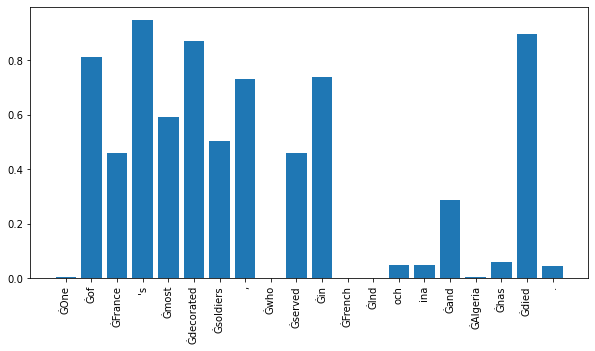

 Masked input:  In 1975 he was appointed State Secretary for Defence by President Valery Giscard d'Estaing.He retired from the army in 1976.
 Summary:   The former French army chief of staff, Charles de Gaulle, was one of the country's most senior military officers. 



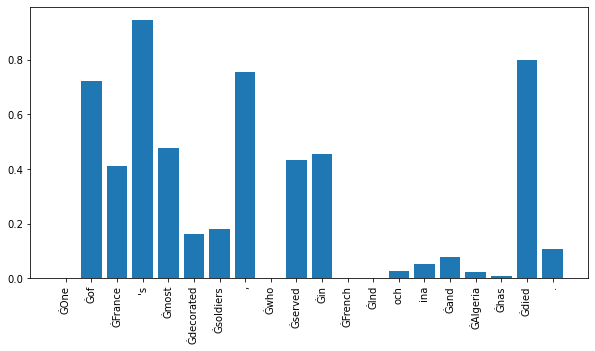

 Masked input:  In 1975 he was appointed State Secretary for Defence by President Valery Giscard d'Estaing.
 Summary:   Former French Defence Minister Jean-Louis Dauriac was a member of the National Front (FN) in the 1970s. 



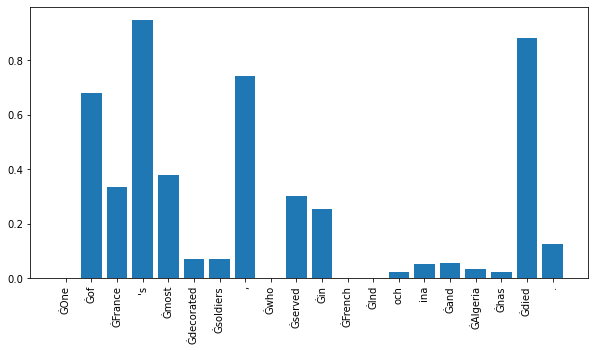

 Masked input:  In 1975 he was appointed State Secretary for
 Summary:   Former British Foreign Secretary Sir John Major has died at the age of 83. 



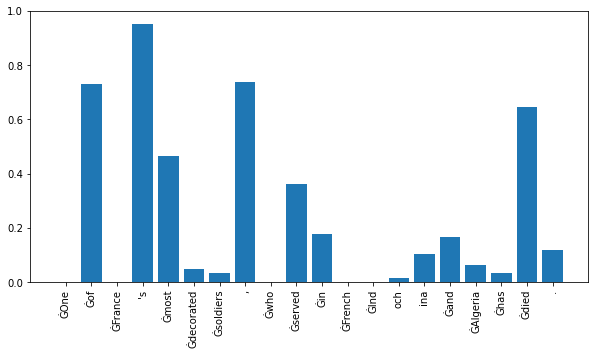

 Masked input:  In 1975 he was
 Summary:   The former British Prime Minister Harold Wilson has died at the age of 83. 



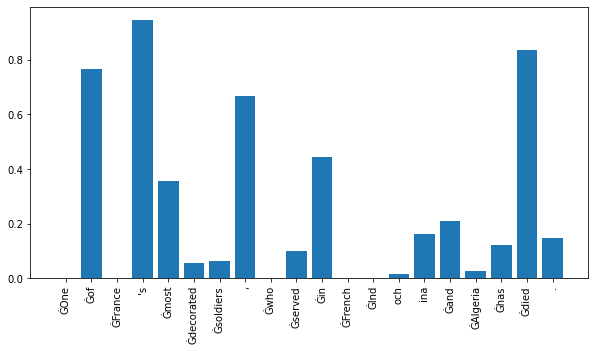

 Masked input:  In 1975
 Summary:   Inverness was the first city in the UK to have a black mayor. 



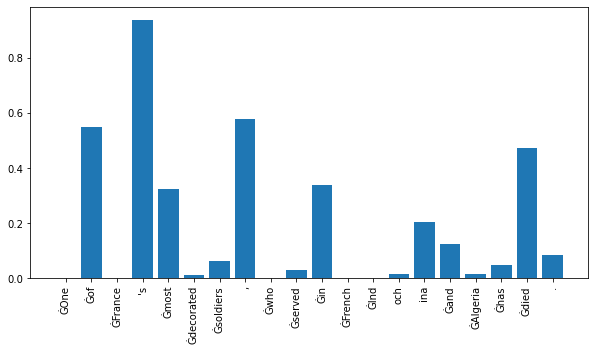

 Masked input:   he was
 Summary:   The BBC News website looks back at some of the best stories of the past 10 years. 



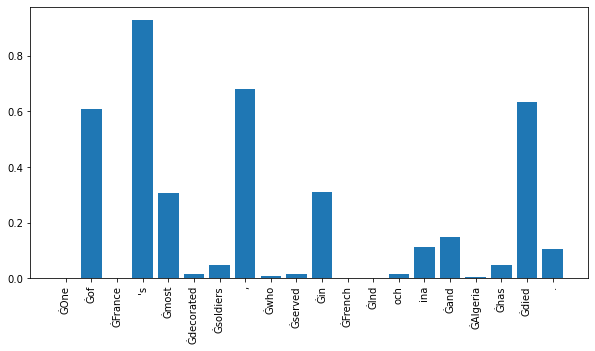

 Masked input:   appointed State Secretary for
 Summary:   David Cameron has been appointed as the new Secretary of State for Wales. 



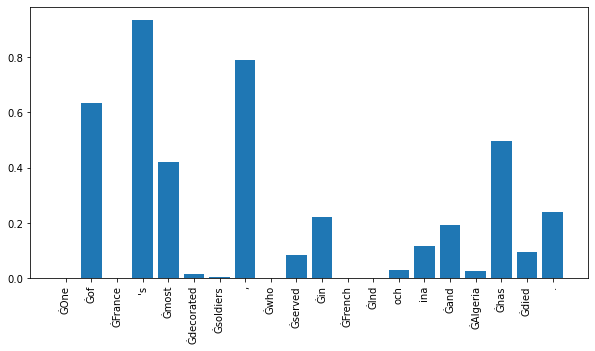

 Masked input:   appointed State
 Summary:  Former US Secretary of State John Kerry has announced his resignation. 



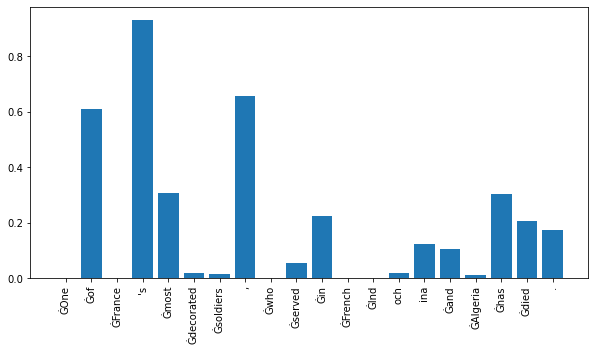

 Masked input:   Secretary for
 Summary:   The BBC News website looks at some of the key stories from the past week. 



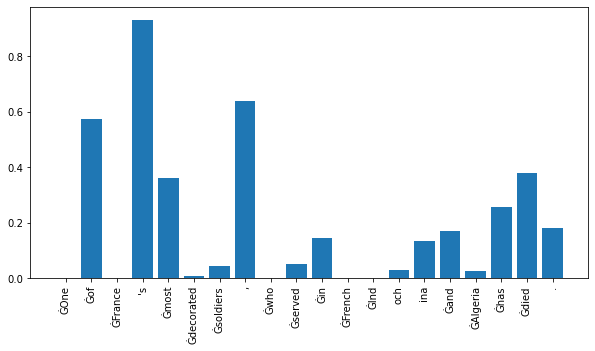

 Masked input:   Defence by President Valery Giscard d'Estaing.
 Summary:   French President Charles De Gaulle has announced the resignation of the country's defence minister. 



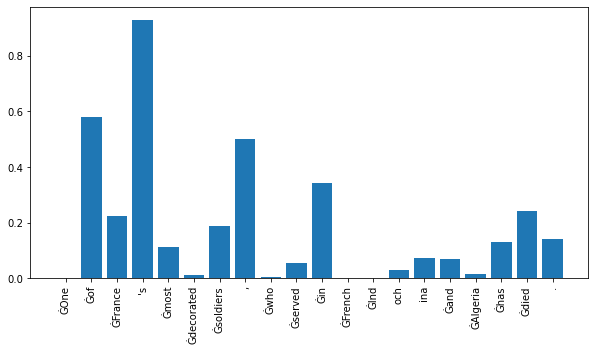

 Masked input:   Defence by President Valery Giscard
 Summary:   French President Charles De Gaulle has defended his government's decision to accept the resignation of President Francois Hollande. 



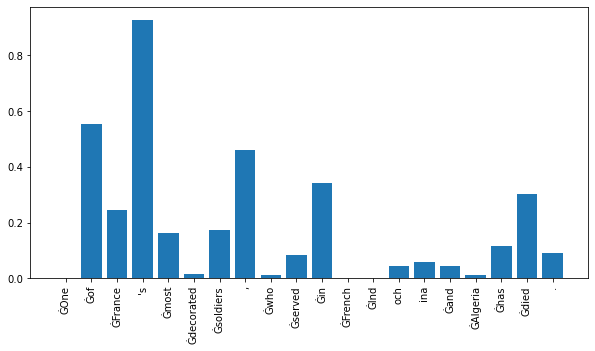

 Masked input:   Defence by President Val
 Summary:  Valentia's President, Jean-Claude Valls, has announced his resignation. 



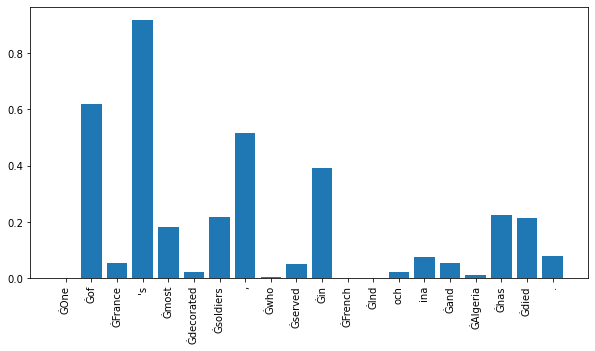

 Masked input:  ery Giscard
 Summary:  Former French Prime Minister Jean-Marie Giscard has died at the age of 84. 



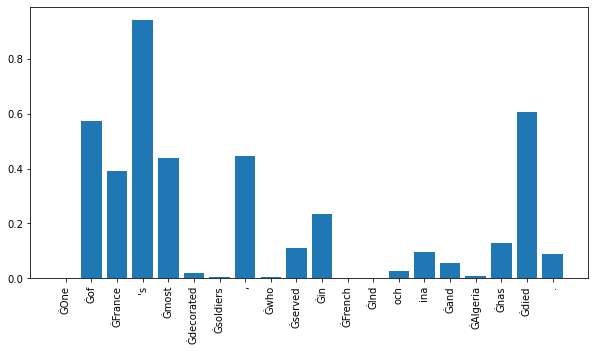

 Masked input:   d'Estaing.
 Summary:  D'Estaing, a village in the south-west of France, is home to a family of three, including two children. 



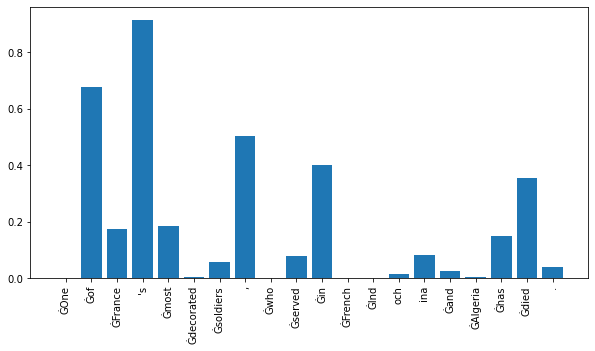

 Masked input:   d'Estaing
 Summary:   D'Estaing, a village in the south-west of France, has been declared a national park by the French government. 



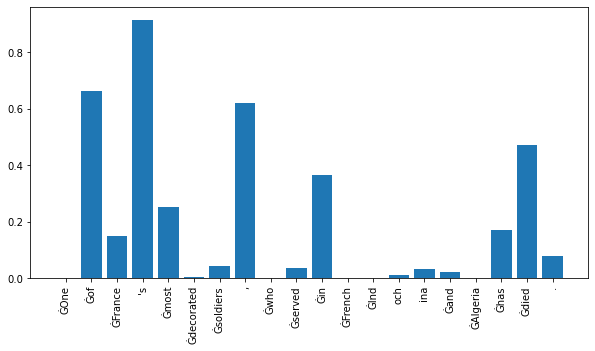

 Masked input:   94, died on Friday,
 Summary:  Tributes have been paid to the former president of the United States, George HW Bush, who has died. 



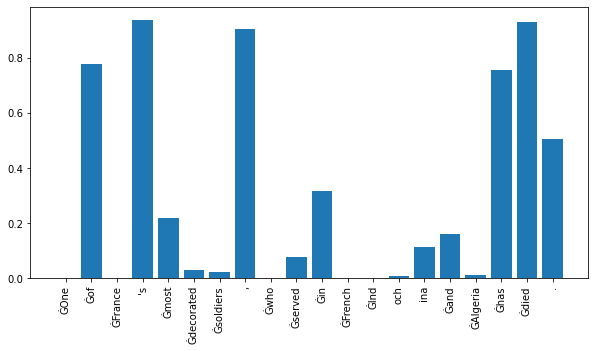

 Masked input:  He retired from the army in 1976.
 Summary:   The British Army's most decorated officer in World War Two, the Prince of Wales, has died at the age of 91. 



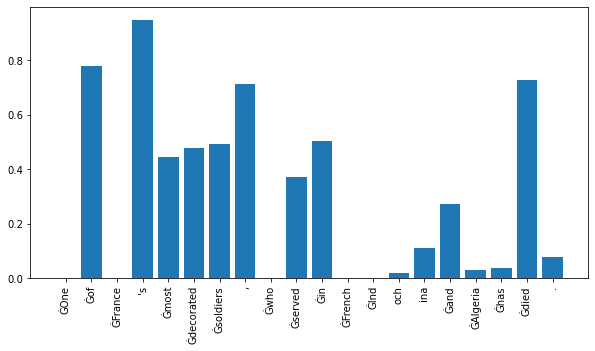

 Masked input:  He retired from the
 Summary:   The Duke of Cambridge was a member of the Royal Family, the family and friends of former Prime Minister David Cameron. 



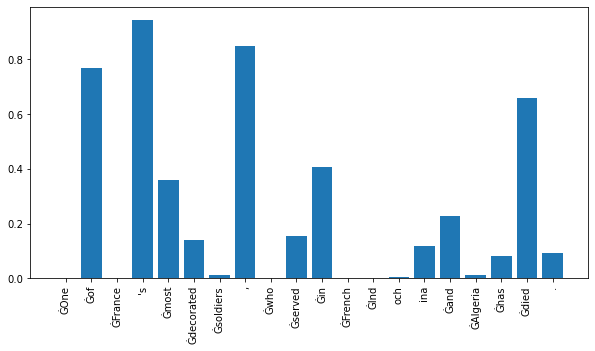

 Masked input:  He retired
 Summary:   The BBC Sport website looks back at some of the best stories of the past 12 months. 



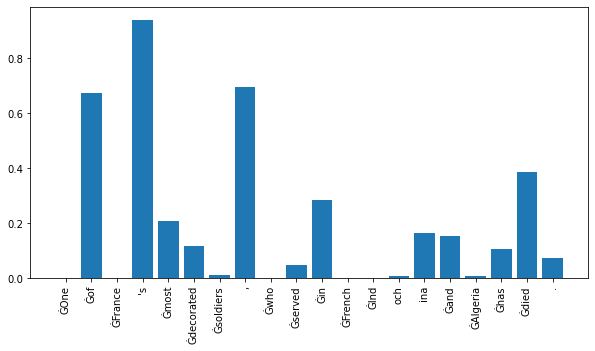

 Masked input:  Gen Bigeard was a commanding officer during the battle of Dien Bien
 Summary:  French general Charles Bigeard, who served in the French army during World War Two, died at the age of 93. 



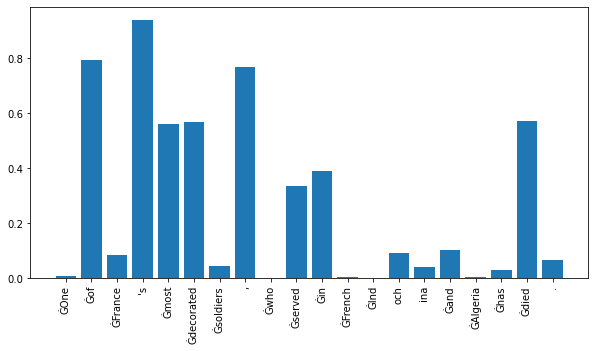

 Masked input:  He was called up into the army at the outbreak of World War II and was
 Summary:   The Duke of Cambridge has died at the age of 91. 



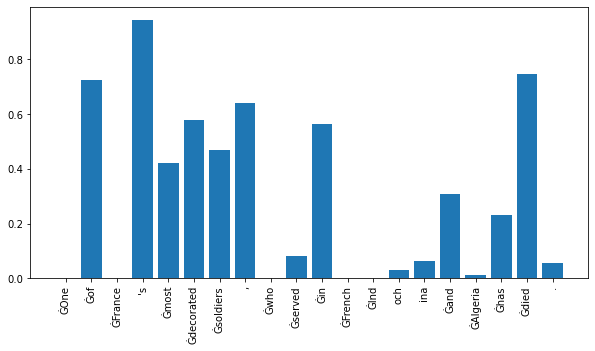

 Masked input:   from the
 Summary:   A look back at some of the top stories of the past 12 months. 



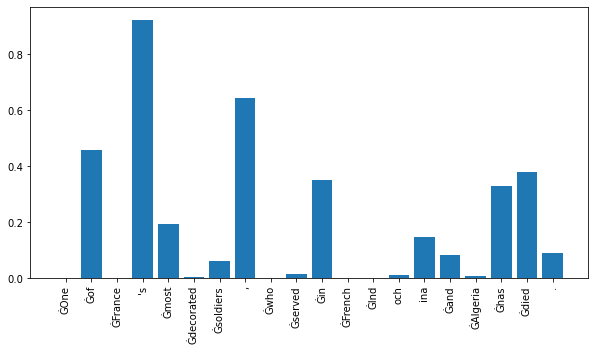

 Masked input:   From there he was parachuted back in to France to fight with the Resistance.
 Summary:  During World War Two, the only British survivor of the Battle of the Somme, was flown to France from the US to fight against the Nazis. 



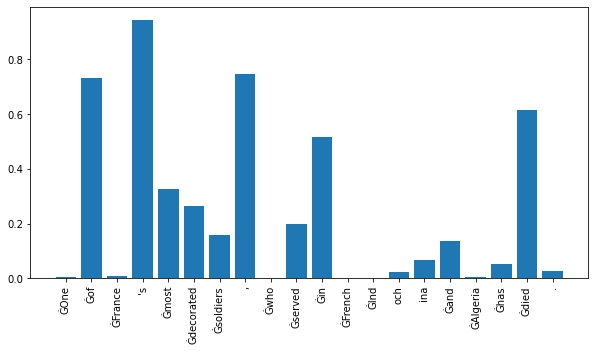

 Masked input:  It was in French Indochina that Gen Bigeard began to make his
 Summary:  French general Charles Bigeard, who was killed in the Battle of the Somme in 1916, was the first French general to die in combat. 



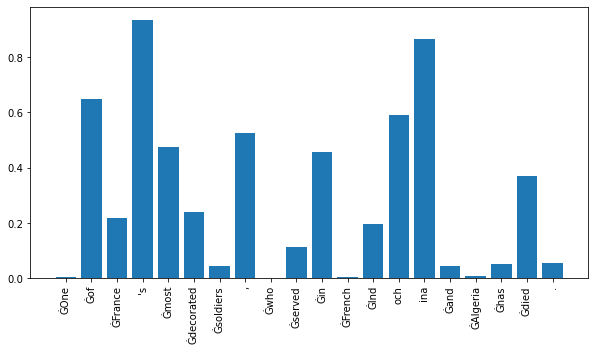

 Masked input:   army in 1976.
 Summary:  Former British Prime Minister David Cameron has resigned from the army. 



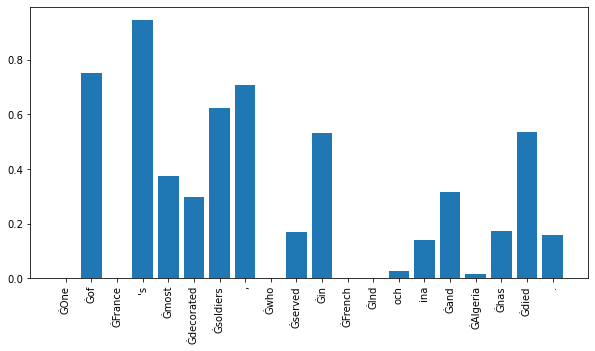

 Masked input:   army in 1976
 Summary:  Former British Prime Minister Margaret Thatcher has announced her resignation from the army. 



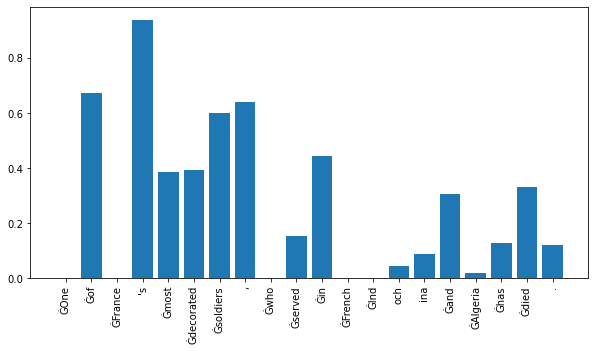

 Masked input:   army in
 Summary:   The British army is due to start training in the US for the first time since the end of World War Two. 



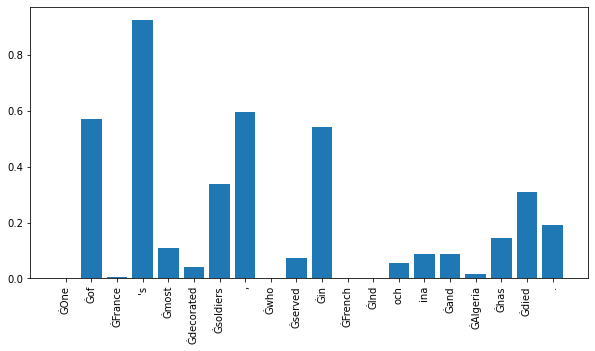

 Masked input:  He was believed to be one of the most decorated soldiers in France and had received
 Summary:   The Battle of the Somme was fought between the French Army and the British Army, and the French army, with the loss of one of its most decorated soldiers. 



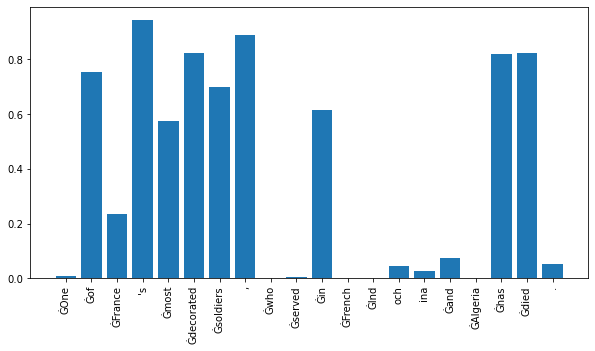

 Masked input:   FLN sympathisers to extract information about bombings carried out by the Algerian insurgents.
 Summary:   The Algerian National Liberation Army (FLN) has been accused of spying for the Algerian government. 



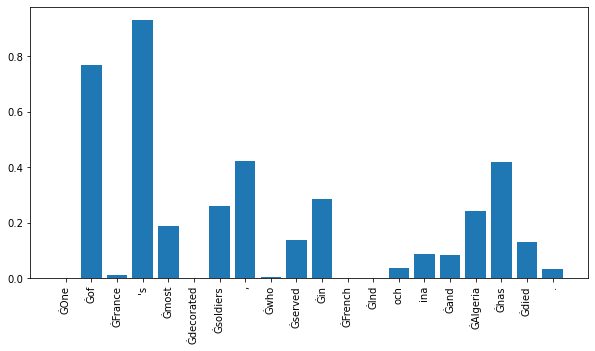

 Masked input:   FLN sympathisers to extract information about
 Summary:  Police in the north-east of the country have arrested two men suspected of being members of the FLN. 



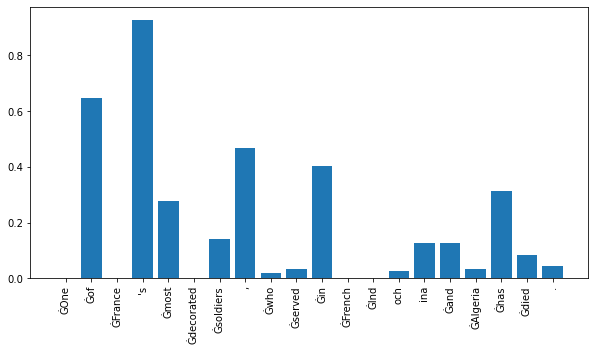

 Masked input:   bombings carried out by the Algerian insurgents.
 Summary:   A series of attacks in and around the Algerian capital, Ouagadougou, has left more than 100 people dead. 



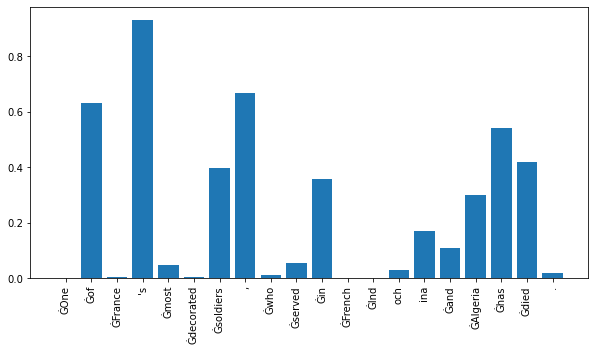

 Masked input:  He was believed to be one of the most decorated soldiers in France and had received medals from both France and Britain for his wartime service.

 Summary:   The Battle of the Somme has ended with the death of French World War Two veteran Charles de Gaulle. 



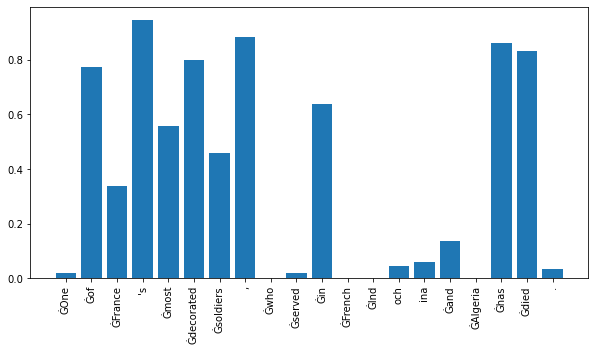

 Masked input:  He was believed to be one of the most decorated soldiers in France and had received medals from both France and Britain for his wartime service.
 Summary:   The Battle of the Somme has ended with the death of the French army's most decorated soldier, the Dauphine regiment. 



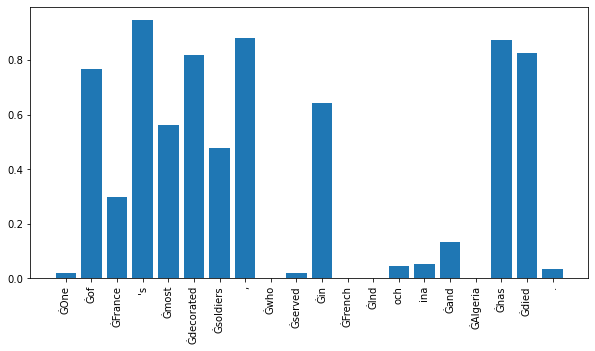

 Masked input:  He was believed to be one of the most decorated soldiers in France and had received
 Summary:   The Battle of the Somme was fought between the French Army and the British Army, and the French army, with the loss of one of its most decorated soldiers. 



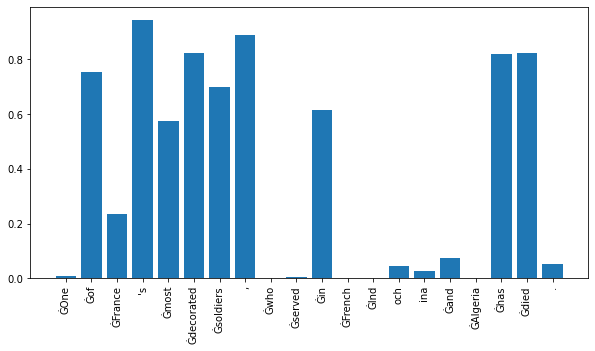

 Masked input:  He was believed to be one of the
 Summary:   The body of a man has been recovered from the River Taff in north-west London, two days after he died. 



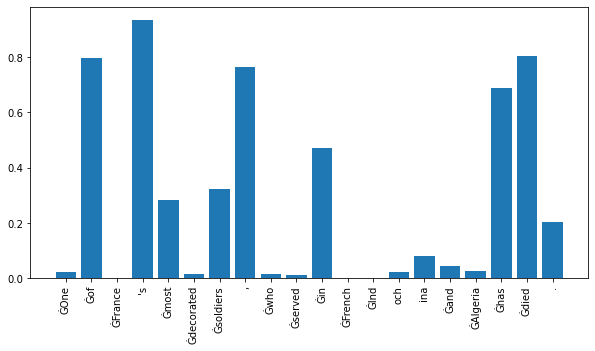

 Masked input:  He was believed to
 Summary:   The BBC News website looks at some of the most important stories of the past few weeks. 



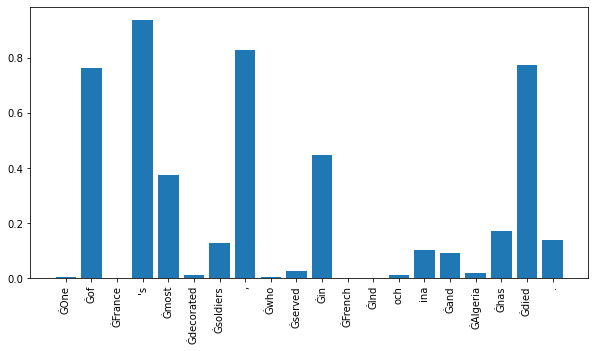

 Masked input:   be one of the
 Summary:  There are so many ways in which people can make a positive impact on the world of sport. 



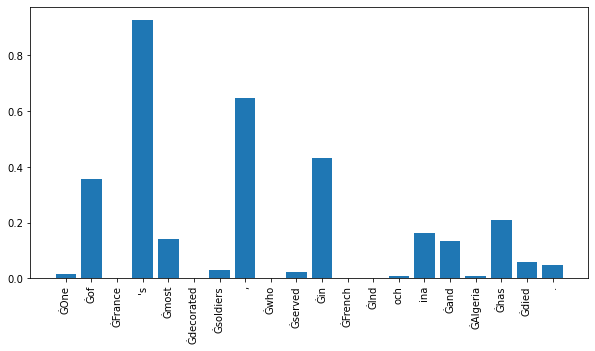

 Masked input:   most decorated soldiers in France and had received
 Summary:   The Duke of Wellington was one of France's most decorated soldiers. 



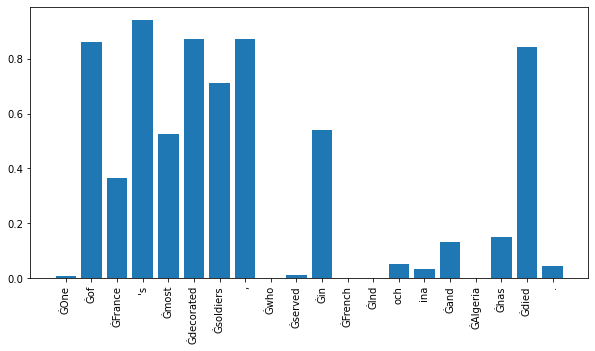

 Masked input:   most decorated soldiers in
 Summary:   The Duke and Duchess of Cambridge are among the most decorated soldiers in the history of the British Army. 



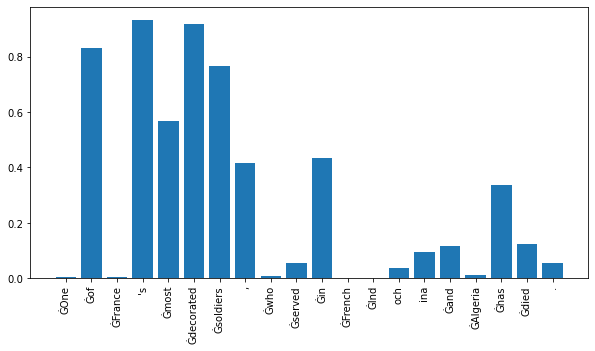

 Masked input:   France and had received
 Summary:   The Duke of Cambridge has died at the age of 91. 



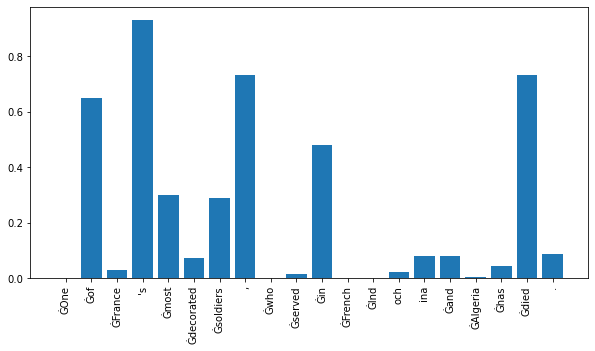

 Masked input:   medals from both France and Britain for his wartime service.
 Summary:   The Duke of Cambridge has been awarded a knighthood for services to France and Britain during World War Two. 



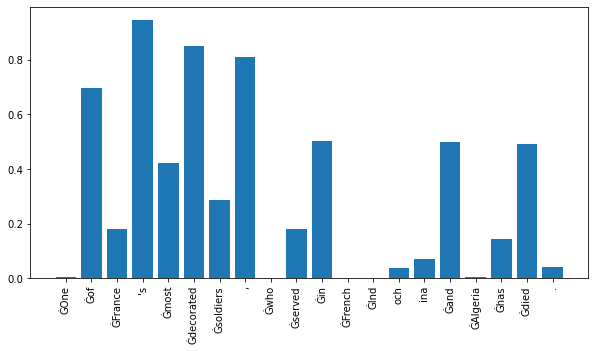

 Masked input:   medals from both France
 Summary:  All photographs courtesy of AFP, EPA, Getty Images and Reuters 



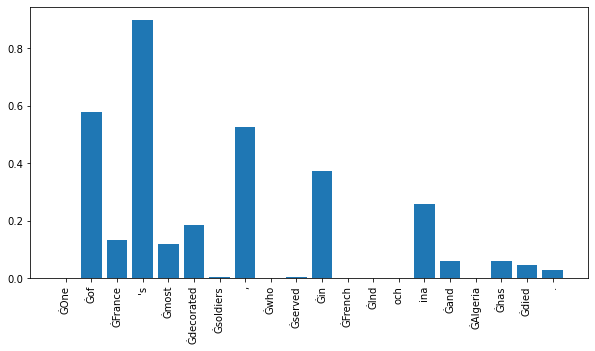

 Masked input:   medals from
 Summary:   Olympic gold medallists from the Rio Games have been announced. 



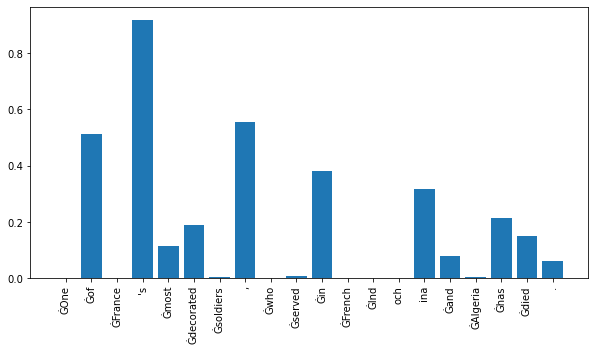

 Masked input:   both France
 Summary:  France has won the European Championship for the second time in three years. 



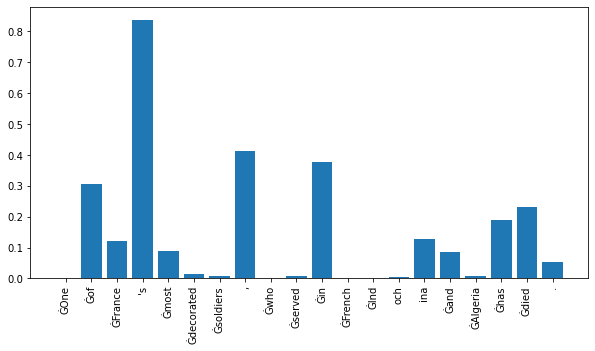

 Masked input:   and Britain for his wartime service.
 Summary:   The Duke of Edinburgh has been honoured by the Queen for his services to the armed forces. 



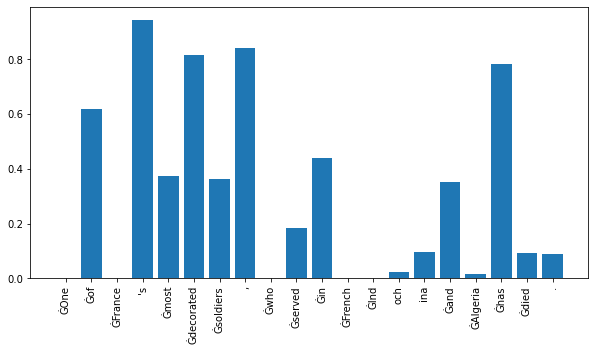

 Masked input:   and Britain for his
 Summary:  Former Prime Minister David Cameron has paid tribute to Britain's Prime Minister Theresa May. 



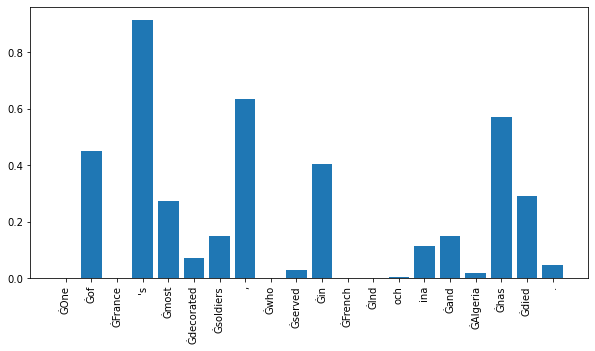

 Masked input:   wartime service.
 Summary:  World War Two: The Battle of the Somme. 



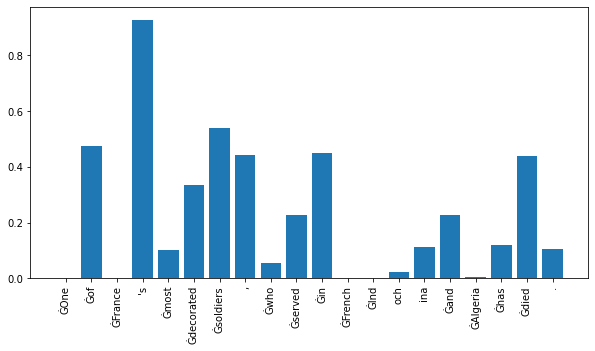

 Masked input:  

 Summary:  Questions are still being asked on social media about the impact of the EU referendum. 



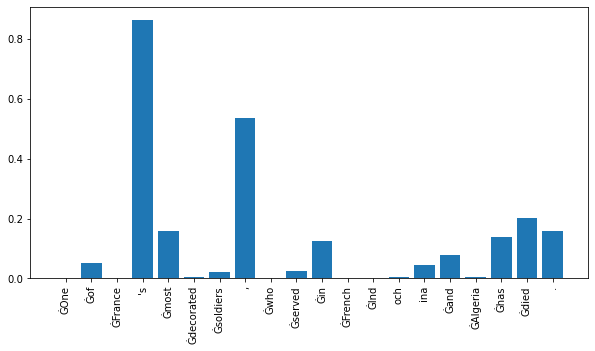

 Masked input:  Gen Marcel Bigeard, 94, died on Friday, his wife told news agency Agence France-Presse.Gen Bigeard was a commanding officer during the battle of Dien Bien Phu and the Battle of Algiers.In 2000 he caused controversy in France by telling a newspaper that torture was a "necessary evil" in Algeria.Gen Bigeard began his military career as an enlisted man, and retired from the army as State Secretary for Defence.He was called up into the army at the outbreak of World War II and was captured in the Battle of France in 1940.He managed to escape and joined the Free French in North Africa. From there he was parachuted back in to France to fight with the Resistance.It was in French Indochina that Gen Bigeard began to make his name as a commander in a Paratroop regiment.He survived the 1954 Battle of Dien Bien Phu, where French troops were surrounded and defeated by the forces of the Vietnamese Communists, the Viet Minh.He was then sent to Algeria where he led the "irregular" count

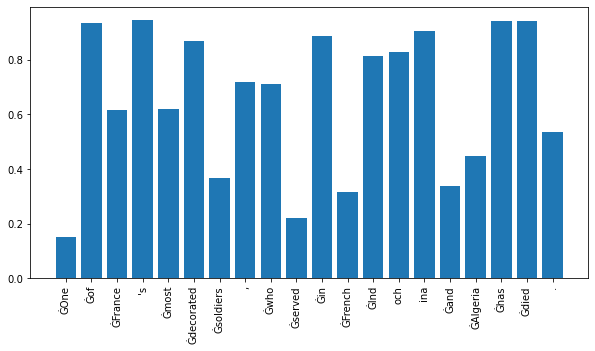

 Masked input:  Gen Marcel Bigeard, 94, died on Friday, his wife told news agency Agence France-Presse.Gen Bigeard was a commanding officer during the battle of Dien Bien Phu and the Battle of Algiers.In 2000 he caused controversy in France by telling a newspaper that torture was a "necessary evil" in Algeria.Gen Bigeard began his military career as an enlisted man, and retired from the army as State Secretary for Defence.He was called up into the army at the outbreak of World War II and was captured in the Battle of France in 1940.He managed to escape and joined the Free French in North Africa. From there he was parachuted back in to France to fight with the Resistance.It was in French Indochina that Gen Bigeard began to make his name as a commander in a Paratroop regiment.He survived the 1954 Battle of Dien Bien Phu, where French troops were surrounded and defeated by the forces of the Vietnamese Communists, the Viet Minh.He was then sent to Algeria where he led the "irregular" count

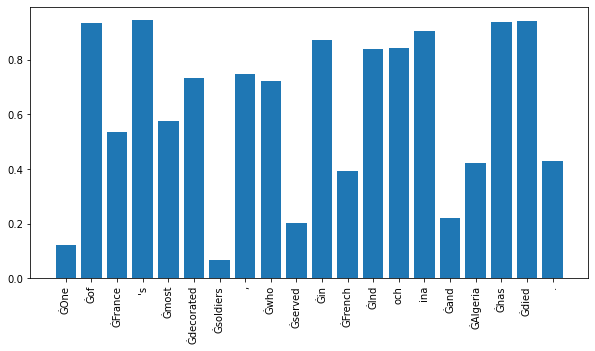

 Masked input:  Gen Marcel Bigeard, 94, died on Friday, his wife told news agency Agence France-Presse.Gen Bigeard was a commanding officer during the battle of Dien Bien Phu and the Battle of Algiers.In 2000 he caused controversy in France by telling a newspaper that torture was a "necessary evil" in Algeria.Gen Bigeard began his military career as an enlisted man, and retired from the army as State Secretary for Defence.
 Summary:   A former French general who served in Vietnam and Algeria during World War Two has died. 



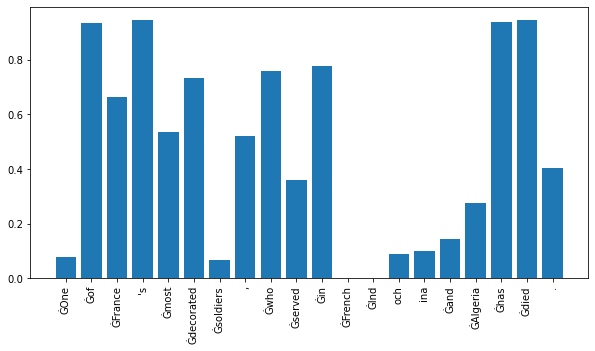

 Masked input:  He was called up into the army at the outbreak of World War II and was captured in the Battle of France in 1940.He managed to escape and joined the Free French in North Africa. From there he was parachuted back in to France to fight with the Resistance.It was in French Indochina that Gen Bigeard began to make his name as a commander in a Paratroop regiment.He survived the 1954 Battle of Dien Bien Phu, where French troops were surrounded and defeated by the forces of the Vietnamese Communists, the Viet Minh.He was then sent to Algeria where he led the "irregular" counter-insurgency campaign against the National Liberation Front (FLN)
 Summary:  French general Bernard Bigeard, who has died at the age of 93, was one of France's most decorated military commanders. 



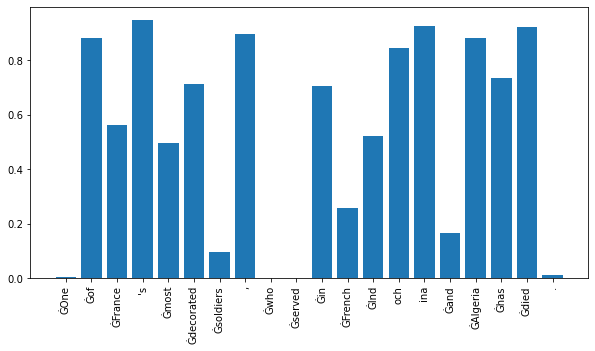

 Masked input:   during the 1957 Battle of Algiers.He later told Le Monde newspaper that it was "necessary" to torture suspected FLN sympathisers to extract information about bombings carried out by the Algerian insurgents.In 1975 he was appointed State Secretary for Defence by President Valery Giscard d'Estaing.He retired from the army in 1976.He was believed to be one of the most decorated soldiers in France and had received medals from both France and Britain for his wartime service.

 Summary:   The former French army chief of staff, Jean-Louis Dauriac, has died at the age of 89. 



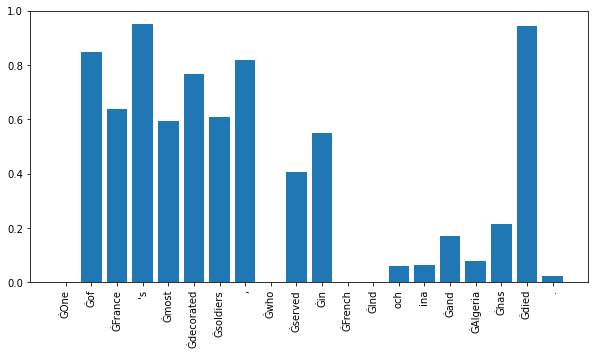

 Masked input:   during the 1957 Battle of Algiers.He later told Le Monde newspaper that it was "necessary" to torture suspected FLN sympathisers to extract information about bombings carried out by the Algerian insurgents.
 Summary:   Former Algerian Prime Minister Jean-Bedel has died at the age of 89 after suffering a stroke. 



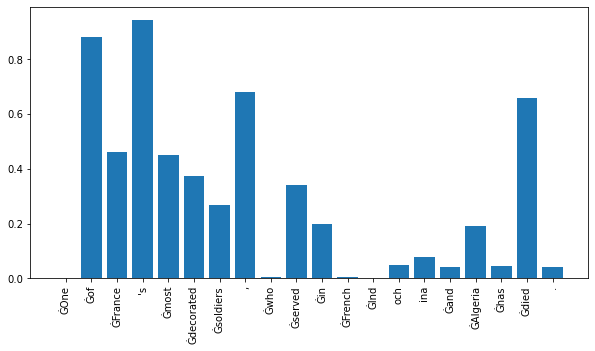

 Masked input:  In 1975 he was appointed State Secretary for Defence by President Valery Giscard d'Estaing.He retired from the army in 1976.He was believed to be one of the most decorated soldiers in France and had received medals from both France and Britain for his wartime service.

 Summary:   The former French army chief of staff and World War Two veteran, Jean-Louis Dauphine, has died at the age of 91. 



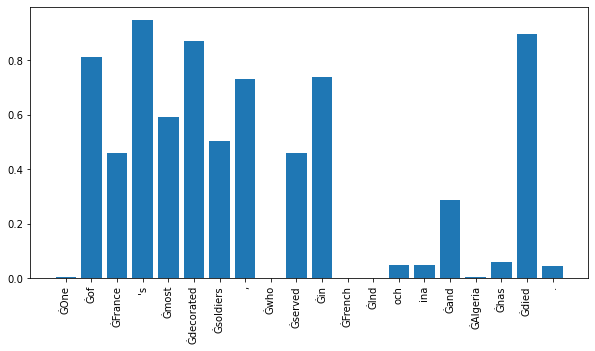

IndexError: row index (681) out of range

In [27]:
d=0
d_limit=7
M = len(fm)
clust_index=M-2
reference_evaluation(M)
masking_experiment(clust_index,d,d_limit,np.array(feature_names),M)

In [ ]:
French general Bernard Bigeard, who has died at the age of 93, was one of France's most decorated military commanders. 

The former French army general, Gen Bernard Bigeard, has died at the age of 93. 



In [ ]:
One of France's most decorated soldiers, who served in French Indochina and Algeria, has died.

One of France's most decorated military commanders, who served in French Indochina during the war with the Viet Minh, has died.

The former French army chief of staff, Jean-Louis Dauriac, has died at the age of 89.

In [103]:
mask_dict

{'<s> Gen  Marcel  Big e ard ,  94 ,  died  on  Friday ,  his  wife  told  news  agency  Ag ence  France - Pres se . Gen  Big e ard  was  a  commanding  officer  during  the  battle  of  D ien  B ien  Ph u  and  the  Battle  of  Al g iers . In  2000  he  caused  controversy  in  France  by  telling  a  newspaper  that  torture  was  a  " necessary  evil "  in  Algeria . Gen  Big e ard  began  his  military  career  as  an  enlisted  man ,  and  retired  from  the  army  as  State  Secretary  for  Defence . He  was  called  up  into  the  army  at  the  outbreak  of  World  War  II  and  was  captured  in  the  Battle  of  France  in  1940 . He  managed  to  escape  and  joined  the  Free  French  in  North  Africa .  From  there  he  was  parach uted  back  in  to  France  to  fight  with  the  Resistance . It  was  in  French  Ind och ina  that  Gen  Big e ard  began  to  make  his  name  as  a  commander  in  a  Par atro op  regiment . He  survived  the  1954  Battle  of  D ien  B ie

In [41]:
attention_mask = mask_dict['He  was  called  up  into  the  army  at  the  outbreak  of  World  War  II  and  was  captured  in  the  Battle  of  France  in  1940 . He  managed  to  escape  and  joined  the  Free  French  in  North  Africa .  From  there  he  was  parach uted  back  in  to  France  to  fight  with  the  Resistance .']

In [42]:
attention_mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [43]:
attention_mask=torch.tensor(attention_mask).unsqueeze(0).cuda()

In [44]:
attention_mask

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Masked input with attention mask: He was called up into the army at the outbreak of World War II and was captured in the Battle of France in 1940.He managed to escape and joined the Free French in North Africa. From there he was parachuted back in to France to fight with the Resistance.


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Keyword arguments {'min_length': 0} not recognized.


 Summary:   One of France's most decorated soldiers, who served in French Indochina and Algeria, has died. 



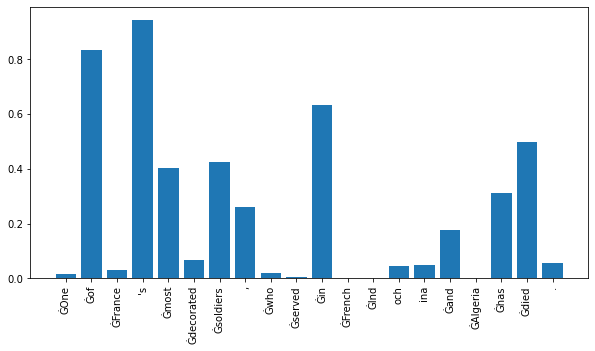

summary: He was captured in the Battle of France in 1940 and joined the Free French in North Africa to fight with the Resistance.


tensor([  894,    21,  4705,    11,     5,  9846,     9,  1470,    11, 16863,
            8,  1770,     5,  3130,  1515,    11,   369,  1327,     7,  1032,
           19,     5, 26839,     4], device='cuda:0')

In [45]:
summarize(dataset['document'][150],model,tokenizer,attention_mask)